SIMULASI ALGORITMA DDASA

Sensor Suhu

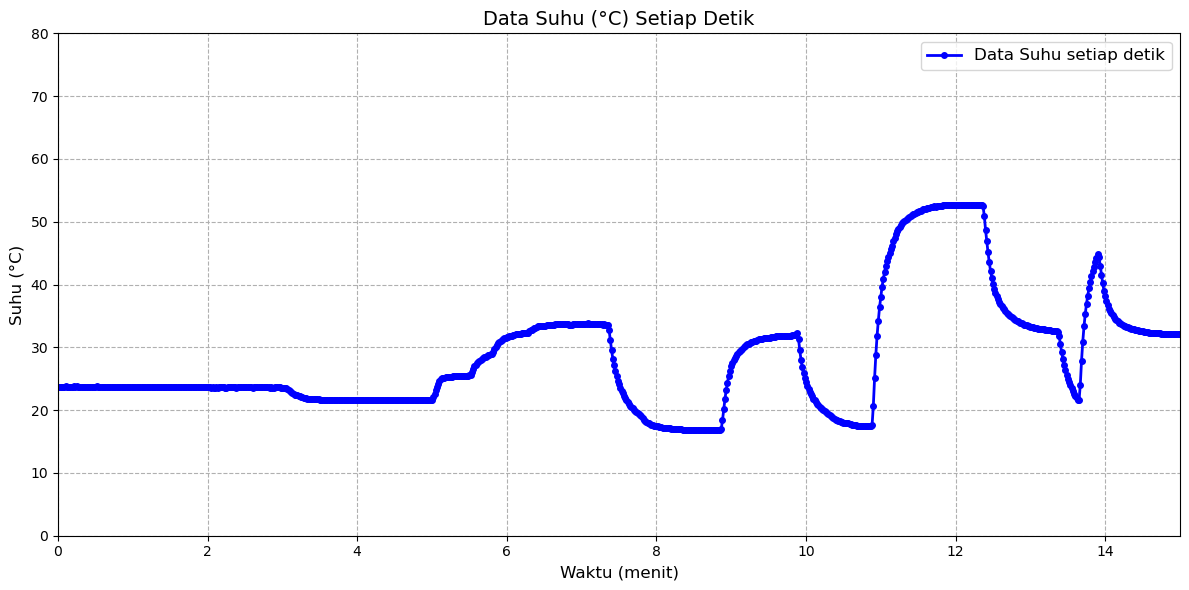

In [1]:
import numpy as np
import matplotlib.pyplot as plt

with open('Data_1s_Suhu.txt', 'r') as f:
    data = [float(line.strip().strip(',')) for line in f if line.strip()]

time_axis = np.arange(len(data)) / 60 

plt.figure(figsize=(12, 6))
plt.plot(time_axis, data, 'b-o', markersize=4, linewidth=2, label='Data Suhu setiap detik')

plt.xlabel('Waktu (menit)', fontsize=12)
plt.ylabel('Suhu (°C)', fontsize=12)
plt.title('Data Suhu (°C) Setiap Detik', fontsize=14)
plt.grid(True, linestyle='--', alpha=1)
plt.legend(fontsize=12)

plt.xlim(0, 15)
plt.ylim(0, 80)

plt.tight_layout()
plt.show()

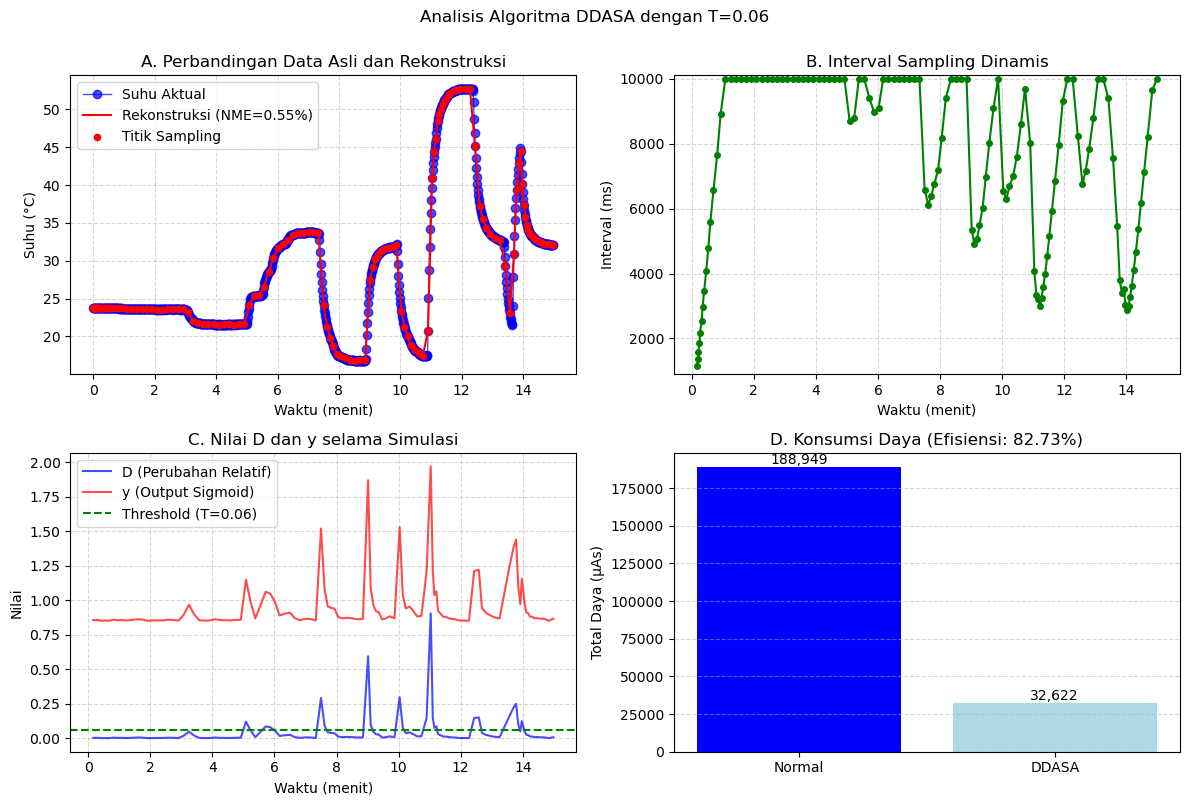

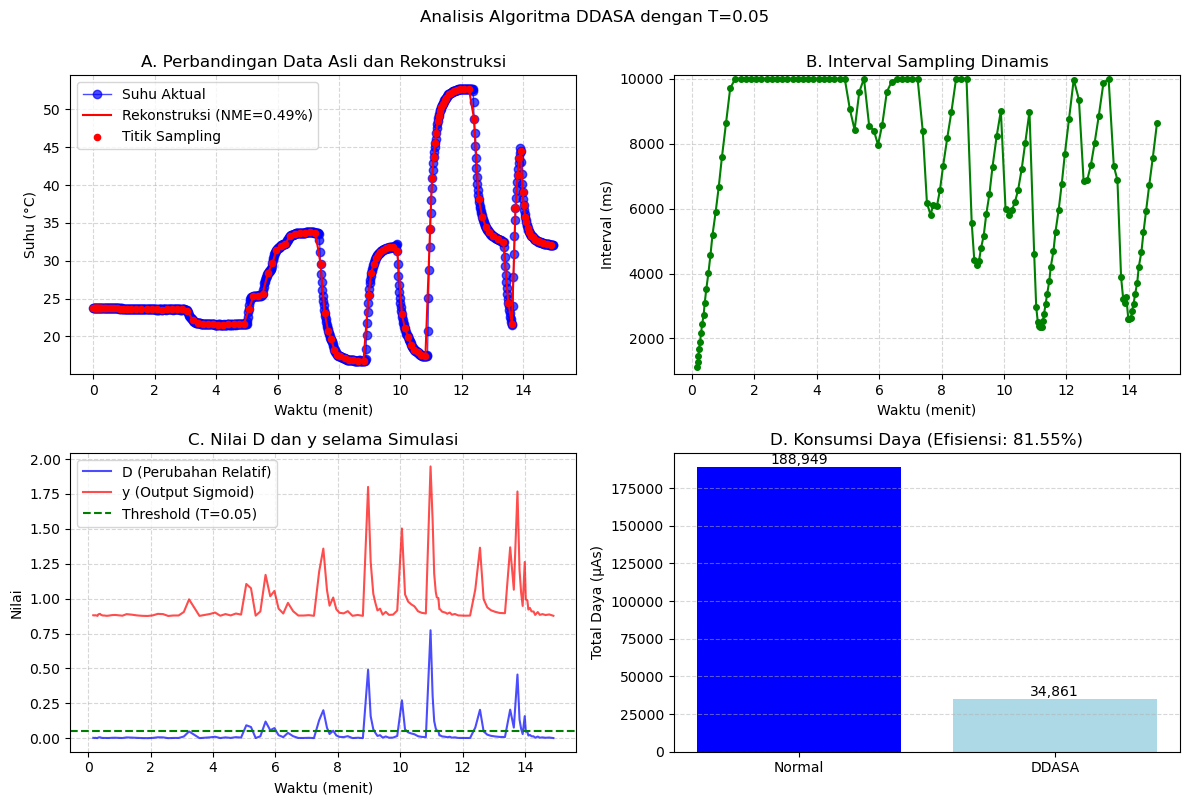

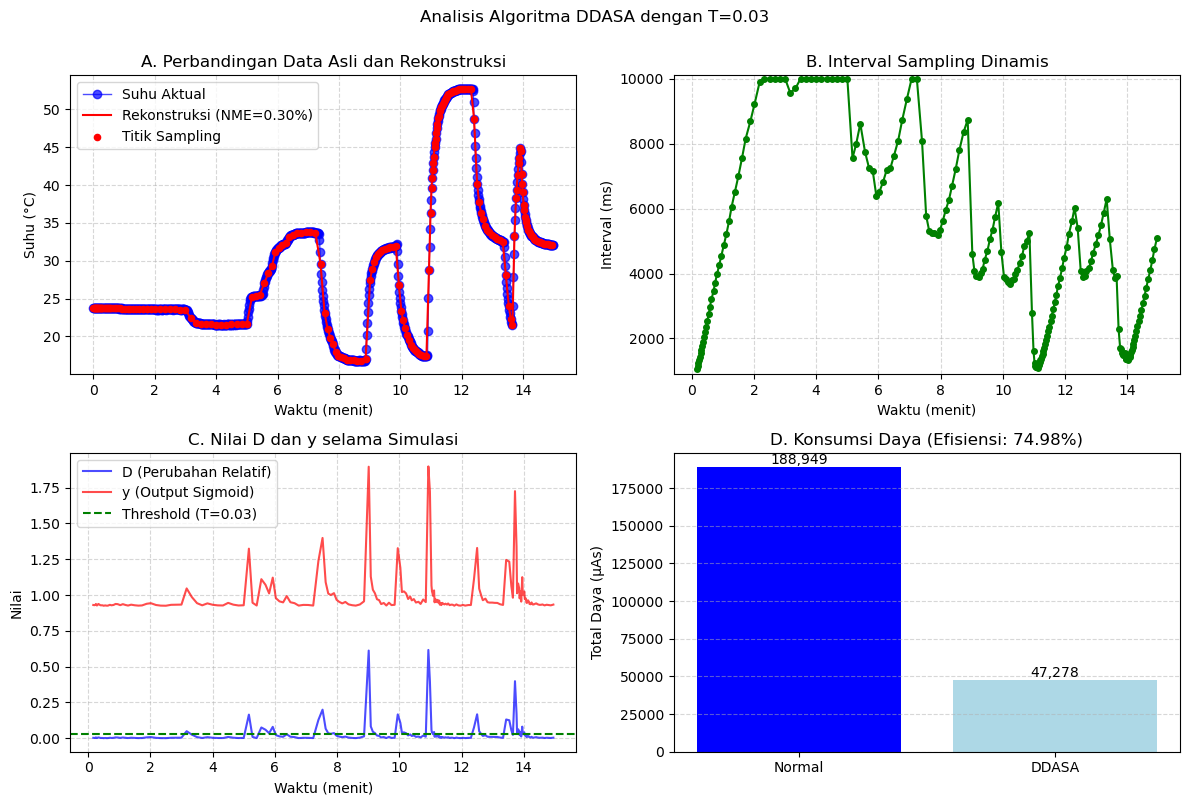

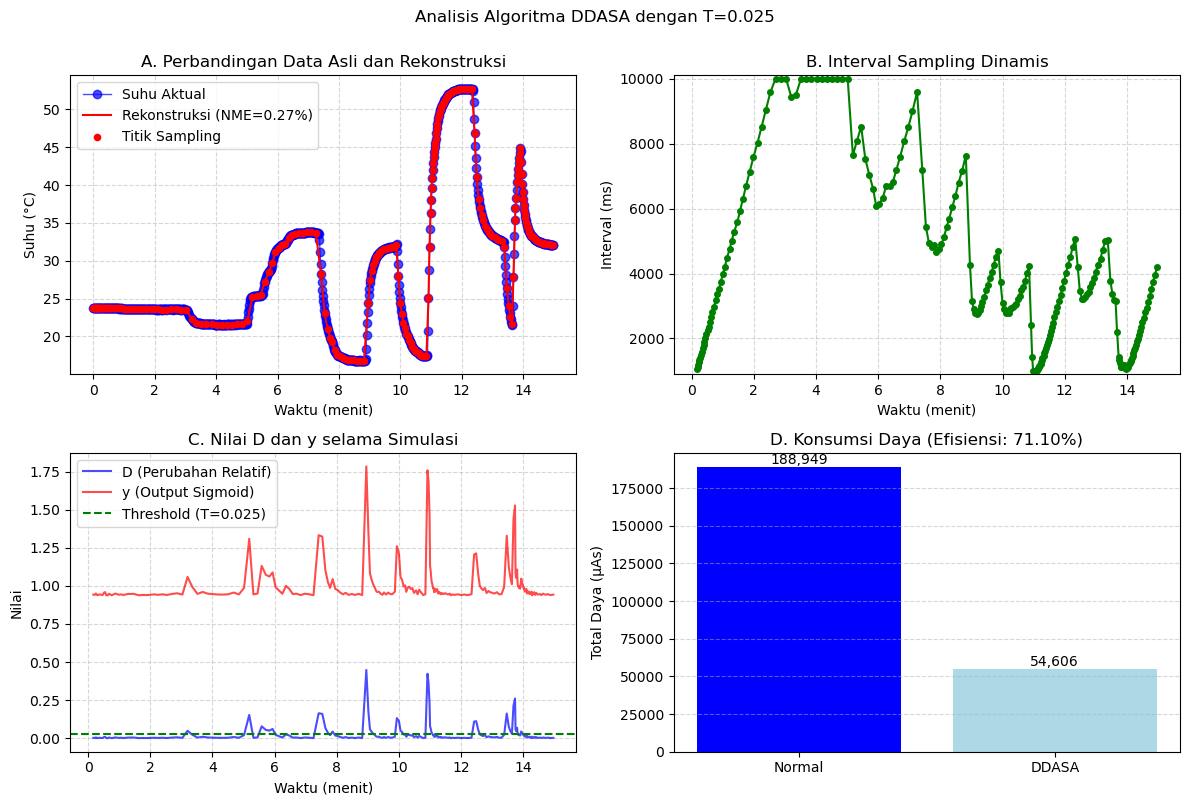

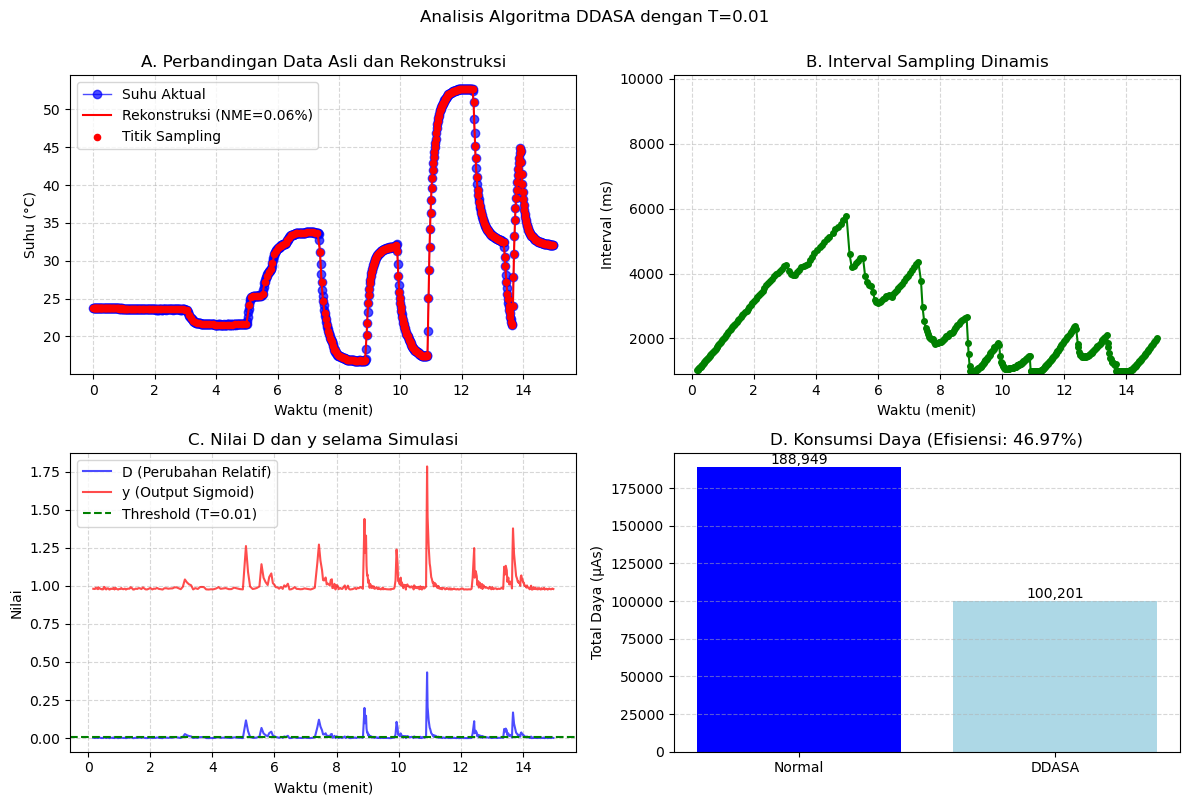


Ringkasan Hasil untuk Semua Nilai T:
T	Samples	NME(%)	Efisiensi(%)	Daya Normal(µA)		Daya DDASA(µA) 
----------------------------------------------------------------------------------------------------
0.06	132	0.55	82.73		188,949			32,622
0.05	143	0.49	81.55		188,949			34,861
0.03	204	0.30	74.98		188,949			47,278
0.025	240	0.27	71.10		188,949			54,606
0.01	464	0.06	46.97		188,949			100,201


In [2]:
from math import exp
import numpy as np
import matplotlib.pyplot as plt

with open('Data_1s_Suhu.txt', 'r') as f:
    data = [float(line.strip().strip(',')) for line in f if line.strip()]

np.random.seed(42)
noise = np.random.normal(0, 0.05, len(data))
noisy_data = [x + noise[i] for i, x in enumerate(data)]

N = 10                  
T_values = [0.06, 0.05, 0.03, 0.025, 0.01]               
initial_interval = 1000  # ms
min_interval = 1000      # ms
max_interval = 10000     # ms
idle_current = 6.4       # µA 
active_current = 277.8     # µA 
delta_current = active_current - idle_current  

def sigmoid(D, T):
    return 2.0 / (1 + exp(-5*(D - T)))

def calculate_D(new_temp, prev_temp, history):
    avg = np.mean(history) 
    if avg != 0: 
        D = abs(new_temp - prev_temp) / avg
    else:
        D = 0
    return D

def simulate_ddasa(data, T):
    intervals = []
    sampling_points = list(range(N))
    D_values = []  
    y_values = []  
    history = data[:N]
    prev_temp = history[-1]
    current_interval = initial_interval
    accumulated_time = 0
    time_step = 1000  
    sample_count = N
    total_operation_time = (len(data) - 1) * 1000  

    for i in range(N, len(data)):
        new_temp = data[i]
        accumulated_time += time_step
        
        if accumulated_time < current_interval:
            continue
        
        accumulated_time -= current_interval
        
        D = calculate_D(new_temp, prev_temp, history)
        y = sigmoid(D, T)
        
        D_values.append(D)
        y_values.append(y)
        sampling_points.append(i)
        sample_count += 1
        
        new_interval = current_interval / y
        new_interval = max(min_interval, min(max_interval, new_interval))
        intervals.append(new_interval)
        current_interval = new_interval
        
        history.pop(0)
        history.append(new_temp)
        prev_temp = new_temp
    
    return sample_count, intervals, sampling_points, D_values, y_values, total_operation_time

def calculate_nme(original, sampling_points, N):
    data_min, data_max = np.min(original), np.max(original)
    original_normalized = (original - data_min) / (data_max - data_min)
    
    reconstructed_normalized = np.interp(
        np.arange(len(original)), 
        sampling_points, 
        original_normalized[sampling_points]
    )
    
    error = np.abs(reconstructed_normalized[N:] - original_normalized[N:])
    nme = np.mean(error) * 100

    reconstructed = reconstructed_normalized * (data_max - data_min) + data_min
    
    return nme, reconstructed

def calculate_power_efficiency(
    total_time_ms,
    n_normal,          
    n_ddasa,           
    idle_current,
    active_current,
    t_active=0.75      
):
    total_time_sec = total_time_ms / 1000
   
    energy_normal = (idle_current * total_time_sec) + (active_current - idle_current) * n_normal * t_active
    energy_ddasa = (idle_current * total_time_sec) + (active_current - idle_current) * n_ddasa * t_active
    
    efficiency = (1 - energy_ddasa / energy_normal) * 100
    return efficiency, energy_normal, energy_ddasa

results = {}

for T in T_values:
    sample_count, intervals, sampling_points, D_values, y_values, total_time_ms = simulate_ddasa(noisy_data, T)
    nme, reconstructed = calculate_nme(np.array(data), sampling_points, N)
    n_normal = len(data)
    n_ddasa = sample_count
    efficiency, power_normal, power_ddasa = calculate_power_efficiency(
        total_time_ms = total_time_ms,
        n_normal = n_normal,
        n_ddasa = n_ddasa, 
        idle_current = idle_current, 
        active_current = active_current,
        t_active = 0.75
    )
    
    results[T] = {
        'sample_count': sample_count,
        'intervals': intervals,
        'sampling_points': sampling_points,
        'D_values': D_values,
        'y_values': y_values,
        'nme': nme,
        'reconstructed': reconstructed,
        'efficiency': efficiency,
        'power_normal': power_normal,
        'power_ddasa': power_ddasa
    }

for T in T_values:
    res = results[T]
    time_axis = np.arange(len(data)) / 60  # Konversi ke menit
    sampling_time_axis = np.array(res['sampling_points'])/60
    
    # Buat figure untuk setiap nilai T
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Analisis Algoritma DDASA dengan T={T}', y=1, fontsize=12)
    
    # Grafik 1 (kiri atas): Perbandingan data asli dan rekonstruksi
    plt.subplot(2, 2, 1)
    plt.plot(time_axis, data, 'b-o', label='Suhu Aktual', alpha=0.7, linewidth=1)
    plt.plot(time_axis, res['reconstructed'], 'r-', label=f'Rekonstruksi (NME={res["nme"]:.2f}%)', linewidth=1.5)
    plt.scatter(
        sampling_time_axis,
        np.array(data)[res['sampling_points']], 
        color='red', s=20, label='Titik Sampling', zorder=3
    )
    plt.title('A. Perbandingan Data Asli dan Rekonstruksi')
    plt.xlabel('Waktu (menit)')
    plt.ylabel('Suhu (°C)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    # Grafik 2 (kanan atas): Interval sampling
    plt.subplot(2, 2, 2)
    if res['intervals']:  
        adaptive_sampling_time = np.array(res['sampling_points'][N:]) / 60
        plt.plot(adaptive_sampling_time, res['intervals'], 'g-', marker='o', markersize=4)
    plt.title('B. Interval Sampling Dinamis')
    plt.xlabel('Waktu (menit)')
    plt.ylabel('Interval (ms)')
    plt.ylim(min_interval - 100, max_interval + 100)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Grafik 3 (kiri bawah): Nilai D dan y
    plt.subplot(2, 2, 3)
    if res['D_values']:  
        adaptive_time_axis = np.array(res['sampling_points'][N:]) / 60
        plt.plot(adaptive_time_axis, res['D_values'], 'b-', label='D (Perubahan Relatif)', alpha=0.7)
        plt.plot(adaptive_time_axis, res['y_values'], 'r-', label='y (Output Sigmoid)', alpha=0.7)
    plt.axhline(y=T, color='g', linestyle='--', label=f'Threshold (T={T})')
    plt.title('C. Nilai D dan y selama Simulasi')
    plt.xlabel('Waktu (menit)')
    plt.ylabel('Nilai')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    # Grafik 4 (kanan bawah): Breakdown konsumsi daya
    plt.subplot(2, 2, 4)
    components = ['Normal', 'DDASA']
    power_values = [res['power_normal'], res['power_ddasa']]
    
    bars = plt.bar(components, power_values, color=['blue', 'lightblue'])
    plt.title(f'D. Konsumsi Daya (Efisiensi: {res["efficiency"]:.2f}%)')
    plt.ylabel('Total Daya (µAs)')
    
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}',
                ha='center', va='bottom')
    
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Tampilkan tabel ringkasan
print("\nRingkasan Hasil untuk Semua Nilai T:")
print("="*100)
print("T\tSamples\tNME(%)\tEfisiensi(%)\tDaya Normal(µA)\t\tDaya DDASA(µA) ")
print("-"*100)
for T in T_values:
    res = results[T]
    print(f"{T}\t{res['sample_count']}\t{res['nme']:.2f}\t{res['efficiency']:.2f}\t\t{res['power_normal']:,.0f}\t\t\t{res['power_ddasa']:,.0f}")
print("="*100)

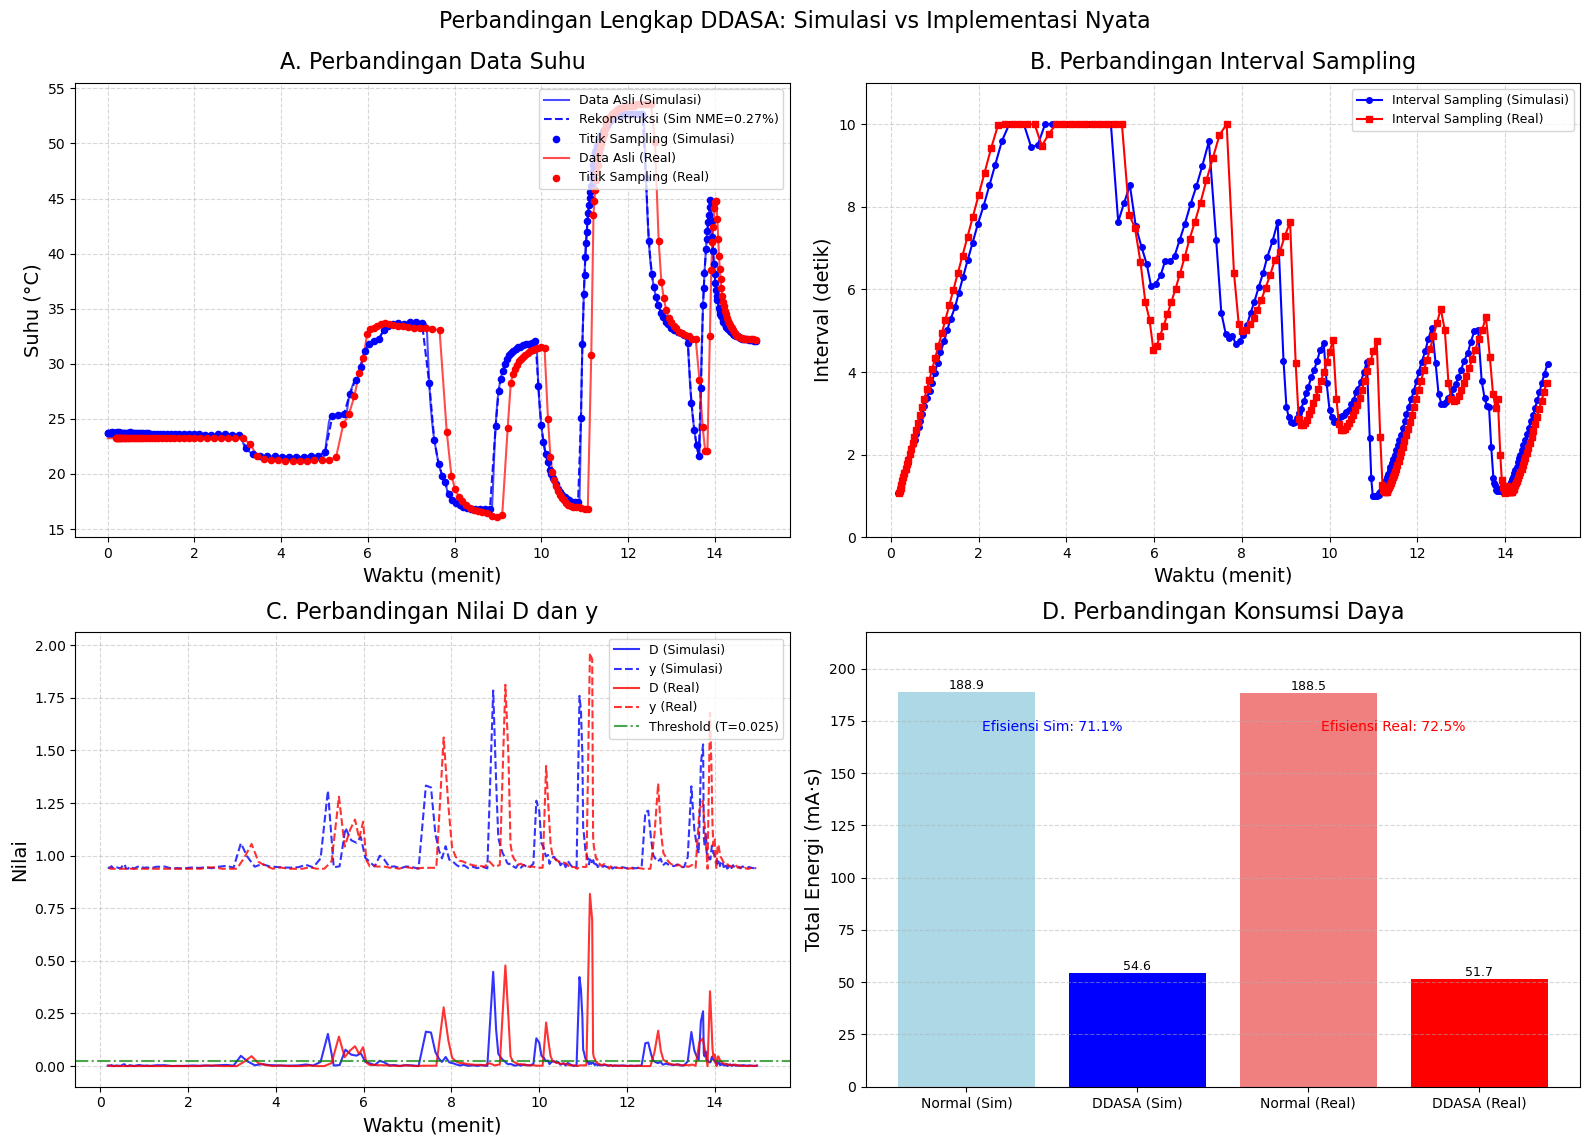


PERBANDINGAN KINERJA DDASA SUHU (T=0.025)
+--------------------+------------+----------------------+
|       Metric       |  Simulasi  |  Implementasi Nyata  |
+====================+============+======================+
|   Jumlah Sampel    |    240     |         226          |
+--------------------+------------+----------------------+
|      NME (%)       |   0.27%    |        5.84%         |
+--------------------+------------+----------------------+
|   Efisiensi (%)    |   71.10%   |        72.55%        |
+--------------------+------------+----------------------+
| Daya Normal (mA·s) |   188.9    |        188.5         |
+--------------------+------------+----------------------+
| Daya DDASA (mA·s)  |    54.6    |         51.7         |
+--------------------+------------+----------------------+


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from datetime import datetime, timedelta, date
from tabulate import tabulate

def parse_real_data(file_content):
    real_data_all_temps = [] 
    real_all_times = []      
    real_ddasa_recorded_temps = []
    real_ddasa_times = []
    real_ddasa_D_values = []
    real_ddasa_y_values = []
    real_ddasa_intervals = []
    actual_sampling_indices_in_full_data = []

    lines = [line for line in file_content.split('\n') if '-> Suhu:' in line]
    if not lines:
        raise ValueError("Tidak ditemukan data yang sesuai format")
    
    start_time_obj = None
    rollover_days = 0
    prev_datetime_obj = None 
    
    for line_idx, line in enumerate(lines):
        try:
            time_part_full = line.split('->')[0].strip()
            if ']' in time_part_full: 
                time_part_cleaned = time_part_full.split(']', 1)[1].strip()
            else:
                time_part_cleaned = time_part_full 

            current_time_parsed = None
            try:
                current_time_parsed = datetime.strptime(time_part_cleaned, '%H:%M:%S.%f').time()
            except ValueError:
                current_time_parsed = datetime.strptime(time_part_cleaned, '%H:%M:%S').time()
            
            current_date_to_use = date(2000, 1, 1) + timedelta(days=rollover_days) 
            current_datetime = datetime.combine(current_date_to_use, current_time_parsed)
            
            if prev_datetime_obj:
                if current_time_parsed < prev_datetime_obj.time() and \
                   (prev_datetime_obj - datetime.combine(prev_datetime_obj.date(), current_time_parsed)).total_seconds() > 12 * 3600:
                    rollover_days += 1
                    current_date_to_use = date(2000, 1, 1) + timedelta(days=rollover_days)
                    current_datetime = datetime.combine(current_date_to_use, current_time_parsed)
            
            if start_time_obj is None:
                start_time_obj = current_datetime 
            
            delta_seconds = (current_datetime - start_time_obj).total_seconds()
            real_all_times.append(delta_seconds)
            prev_datetime_obj = current_datetime
            
            data_part_str = line.split('-> Suhu:')[1].strip()
            split_data_parts = data_part_str.split('|')
            
            temp = float(split_data_parts[0].strip())
            real_data_all_temps.append(temp)
            
            current_idx_in_all_temps = len(real_data_all_temps) - 1

            if len(split_data_parts) > 1: 
                actual_sampling_indices_in_full_data.append(current_idx_in_all_temps)
                real_ddasa_recorded_temps.append(temp) 
                real_ddasa_times.append(delta_seconds) 
                real_ddasa_D_values.append(float(split_data_parts[1].replace('D:', '').strip()))
                real_ddasa_y_values.append(float(split_data_parts[2].replace('y(D):', '').strip()))
                real_ddasa_intervals.append(float(split_data_parts[3].replace('Interval:', '').replace('ms', '').strip()))
                
        except Exception as e:
            print(f"Gagal parsing baris {line_idx + 1}: {line}\nError: {str(e)}")
            continue
            
    return {
        'temperatures': real_data_all_temps,    
        'times': real_all_times,                
        'ddasa_recorded_temps': real_ddasa_recorded_temps, 
        'ddasa_times': real_ddasa_times,                   
        'ddasa_intervals': real_ddasa_intervals,
        'ddasa_D_values': real_ddasa_D_values,
        'ddasa_y_values': real_ddasa_y_values,
        'sampling_indices': actual_sampling_indices_in_full_data 
    }

# Baca data real dari file
with open('Data_DDASA_Suhu.txt', 'r') as f:
    real_content = f.read()
real_results = parse_real_data(real_content)

# Baca data untuk simulasi
with open('Data_1s_Suhu.txt', 'r') as f:
    sim_data = [float(line.strip().strip(',')) for line in f if line.strip()]

np.random.seed(42)
noise = np.random.normal(0, 0.05, len(sim_data))
noisy_data = [x + noise[i] for i, x in enumerate(sim_data)]

N = 10  
T = 0.025
initial_interval = 1000  # ms
min_interval = 1000      # ms
max_interval = 10000     # ms
idle_current = 6.4       # µA 
active_current = 277.8     # µA 
t_active = 0.75          # Durasi sampling (detik)

def sigmoid(D_val, T_val):
    return 2.0 / (1 + exp(-5*(D_val - T_val)))

def calculate_D(new_temp, prev_temp, history):
    if not history: 
        return 0
    avg = np.mean(history)
    D_val = abs(new_temp - prev_temp) / avg if avg != 0 else 0
    return D_val

def simulate_ddasa(data, T_threshold):
    intervals = []
    sampling_points = list(range(N))  # Sertakan 10 titik awal
    D_values = []  
    y_values = []  
    history = data[:N]
    prev_temp = history[-1]
    current_interval = initial_interval
    accumulated_time = 0
    time_step = 1000
    sample_count = N  # Hitung 10 titik awal

    for i in range(N, len(data)):
        new_temp = data[i]
        accumulated_time += time_step 

        if accumulated_time < current_interval:
            continue
            
        accumulated_time -= current_interval
        
        D = calculate_D(new_temp, prev_temp, history)
        y = sigmoid(D, T_threshold)
        
        D_values.append(D)
        y_values.append(y)
        sampling_points.append(i)
        sample_count += 1
        
        new_interval = current_interval / y
        new_interval = max(min_interval, min(max_interval, new_interval))
        intervals.append(new_interval)
        
        current_interval = new_interval 

        history.pop(0)
        history.append(new_temp)
        prev_temp = new_temp
    
    return sample_count, intervals, sampling_points, D_values, y_values

def calculate_direct_nme(ground_truth, recorded_temps, recorded_times, total_points):
    if not recorded_temps or not recorded_times or not ground_truth:
        return 100.0
    
    # Normalisasi data
    data_min = min(min(ground_truth), min(recorded_temps))
    data_max = max(max(ground_truth), max(recorded_temps))
    range_val = data_max - data_min
    
    if range_val == 0:
        return 0.0
    
    errors = []
    for temp, time in zip(recorded_temps, recorded_times):
        # Cari indeks terdekat dalam ground truth
        idx = min(int(time), total_points - 1)
        ground_truth_val = ground_truth[idx]
        
        # Normalisasi nilai
        norm_truth = (ground_truth_val - data_min) / range_val
        norm_recorded = (temp - data_min) / range_val
        
        # Hitung error absolut
        errors.append(abs(norm_truth - norm_recorded))
    
    # Hitung NME (mulai setelah 10 titik pertama)
    start_index = min(10, len(errors))
    return np.mean(errors[start_index:]) * 100

def calculate_power_efficiency_corrected(
    total_time_sec,
    n_normal,          # Jumlah sampling mode normal
    n_ddasa,           # Jumlah sampling mode DDASA
    idle_curr,
    active_curr,
    t_active=0.75      # Durasi sampling (detik)
):
    # Hitung energi (µA·detik)
    energy_normal = idle_curr * total_time_sec + (active_curr - idle_curr) * n_normal * t_active
    energy_ddasa = idle_curr * total_time_sec + (active_curr - idle_curr) * n_ddasa * t_active
    
    if energy_normal == 0:
        efficiency = 0
    else:
        efficiency = (1 - energy_ddasa / energy_normal) * 100
    return efficiency, energy_normal, energy_ddasa

def calculate_nme(original, sampling_points, N):
    data_min, data_max = np.min(original), np.max(original)
    original_normalized = (original - data_min) / (data_max - data_min)
    
    reconstructed_normalized = np.interp(
        np.arange(len(original)), 
        sampling_points, 
        original_normalized[sampling_points]
    )
    
    error = np.abs(reconstructed_normalized[N:] - original_normalized[N:])
    nme = np.mean(error) * 100

    reconstructed = reconstructed_normalized * (data_max - data_min) + data_min
    
    return nme, reconstructed
    
sim_sample_count, sim_intervals, sim_sampling_indices, sim_D_values, sim_y_values = simulate_ddasa(noisy_data, T)
sim_nme, sim_reconstructed = calculate_nme(np.array(sim_data), sim_sampling_indices, N)

real_direct_nme = calculate_direct_nme(
    ground_truth=sim_data,
    recorded_temps=real_results['ddasa_recorded_temps'],
    recorded_times=real_results['ddasa_times'],
    total_points=len(sim_data)
)

total_time_sim_sec = len(sim_data) - 1  # Total waktu simulasi (detik)
n_normal_sim = len(sim_data)            # Jumlah sampling mode normal
sim_efficiency, sim_power_normal, sim_power_ddasa = calculate_power_efficiency_corrected(
    total_time_sec=total_time_sim_sec,
    n_normal=n_normal_sim,
    n_ddasa=sim_sample_count,
    idle_curr=idle_current,
    active_curr=active_current,
    t_active=t_active
)

# jumlah titik inisialisasi
if real_results['sampling_indices']:
    N_init_real_count = real_results['sampling_indices'][0]
else:
    N_init_real_count = len(real_results['temperatures'])

# Total sampel real
num_dynamic_real_samples = len(real_results['ddasa_intervals'])
total_real_samples = N_init_real_count + num_dynamic_real_samples

# Hitung efisiensi daya real
total_time_real_sec = real_results['times'][-1] if real_results['times'] else 0
n_normal_real = total_time_real_sec + 1  # Sampling normal = total waktu + 1

real_efficiency, real_power_normal, real_power_ddasa = calculate_power_efficiency_corrected(
    total_time_sec=total_time_real_sec,
    n_normal=n_normal_real,
    n_ddasa=total_real_samples,
    idle_curr=idle_current,
    active_curr=active_current,
    t_active=t_active
)

plt.figure(figsize=(16, 12))
plt.suptitle('Perbandingan Lengkap DDASA: Simulasi vs Implementasi Nyata', fontsize=16, y=0.95)

# 1. Perbandingan data suhu
ax1 = plt.subplot(2, 2, 1)
# Data simulasi
sim_time_min = np.arange(len(sim_data)) / 60.0
plt.plot(sim_time_min, sim_data, 'b-', label='Data Asli (Simulasi)', alpha=0.7, linewidth=1.5)
plt.plot(sim_time_min, sim_reconstructed, 'b--', label=f'Rekonstruksi (Sim NME={sim_nme:.2f}%)', alpha=0.9, linewidth=1.5)

# Titik sampling simulasi
plt.scatter(
    np.array(sim_sampling_indices)/60.0, 
    np.array(sim_data)[sim_sampling_indices], 
    color='blue', s=20, label='Titik Sampling (Simulasi)', zorder=3
)

# Data nyata
real_time_min = np.array(real_results['times']) / 60.0
plt.plot(real_time_min, real_results['temperatures'], 'r-', label='Data Asli (Real)', alpha=0.7, linewidth=1.5)

# Titik sampling nyata
plt.scatter(
    np.array(real_results['ddasa_times'])/60.0, 
    real_results['ddasa_recorded_temps'], 
    color='red', s=20, label='Titik Sampling (Real)', zorder=3
)

plt.title('A. Perbandingan Data Suhu', pad=10,fontsize=16)
plt.xlabel('Waktu (menit)', fontsize=14)
plt.ylabel('Suhu (°C)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9, loc='upper right')

# 2. Perbandingan interval sampling
ax2 = plt.subplot(2, 2, 2)
# Simulasi: hanya titik adaptif (setelah N)
sim_adaptive_times = np.array(sim_sampling_indices[N:]) / 60.0
plt.plot(sim_adaptive_times, np.array(sim_intervals)/1000, 'b-', marker='o', markersize=4, 
         label='Interval Sampling (Simulasi)')

# Nyata: semua titik sampling DDASA
plt.plot(np.array(real_results['ddasa_times'])/60.0, np.array(real_results['ddasa_intervals'])/1000, 
         'r-', marker='s', markersize=4, label='Interval Sampling (Real)')

plt.title('B. Perbandingan Interval Sampling', pad=10,fontsize=16)
plt.xlabel('Waktu (menit)', fontsize=14)
plt.ylabel('Interval (detik)', fontsize=14)
plt.ylim(min_interval/1000 - 1, max_interval/1000 + 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9)

# 3. Perbandingan nilai D dan y
ax3 = plt.subplot(2, 2, 3)
# Simulasi: D dan y
plt.plot(sim_adaptive_times, sim_D_values, 'b-', label='D (Simulasi)', alpha=0.8, linewidth=1.5)
plt.plot(sim_adaptive_times, sim_y_values, 'b--', label='y (Simulasi)', alpha=0.8, linewidth=1.5)

# Nyata: D dan y
real_ddasa_times_min = np.array(real_results['ddasa_times']) / 60.0
plt.plot(real_ddasa_times_min, real_results['ddasa_D_values'], 'r-', label='D (Real)', alpha=0.8, linewidth=1.5)
plt.plot(real_ddasa_times_min, real_results['ddasa_y_values'], 'r--', label='y (Real)', alpha=0.8, linewidth=1.5)

plt.axhline(y=T, color='g', linestyle='-.', label=f'Threshold (T={T})', linewidth=1.5, alpha=0.7)
plt.title('C. Perbandingan Nilai D dan y', pad=10,fontsize=16)
plt.xlabel('Waktu (menit)', fontsize=14)
plt.ylabel('Nilai', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9, loc='upper right')

# 4. Perbandingan konsumsi daya
ax4 = plt.subplot(2, 2, 4)
components = ['Normal (Sim)', 'DDASA (Sim)', 'Normal (Real)', 'DDASA (Real)']
power_values = [
    sim_power_normal/1000, 
    sim_power_ddasa/1000, 
    real_power_normal/1000, 
    real_power_ddasa/1000
]
colors = ['lightblue', 'blue', 'lightcoral', 'red']

bars = plt.bar(components, power_values, color=colors)
plt.title('D. Perbandingan Konsumsi Daya', pad=10,fontsize=16)
plt.ylabel('Total Energi (mA·s)', fontsize=14)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}',
            ha='center', va='bottom', fontsize=9)
    
plt.text(0.5, max(power_values)*0.9, f'Efisiensi Sim: {sim_efficiency:.1f}%', 
         ha='center', fontsize=10, color='blue')
plt.text(2.5, max(power_values)*0.9, f'Efisiensi Real: {real_efficiency:.1f}%', 
         ha='center', fontsize=10, color='red')

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, max(power_values) * 1.15)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('perbandingan_komprehensif.png', dpi=300, bbox_inches='tight')
plt.show()

summary_data = [
    ["Jumlah Sampel", f"{sim_sample_count}", f"{total_real_samples}"],
    ["NME (%)", f"{sim_nme:.2f}%", f"{real_direct_nme:.2f}%"],
    ["Efisiensi (%)", f"{sim_efficiency:.2f}%", f"{real_efficiency:.2f}%"],
    ["Daya Normal (mA·s)", f"{sim_power_normal/1000:.1f}", f"{real_power_normal/1000:.1f}"],
    ["Daya DDASA (mA·s)", f"{sim_power_ddasa/1000:.1f}", f"{real_power_ddasa/1000:.1f}"]
]

print("\nPERBANDINGAN KINERJA DDASA SUHU (T=0.025)")
print(tabulate(summary_data, headers=["Metric", "Simulasi", "Implementasi Nyata"], 
               tablefmt="grid", stralign="center", numalign="center"))

Sensor pH

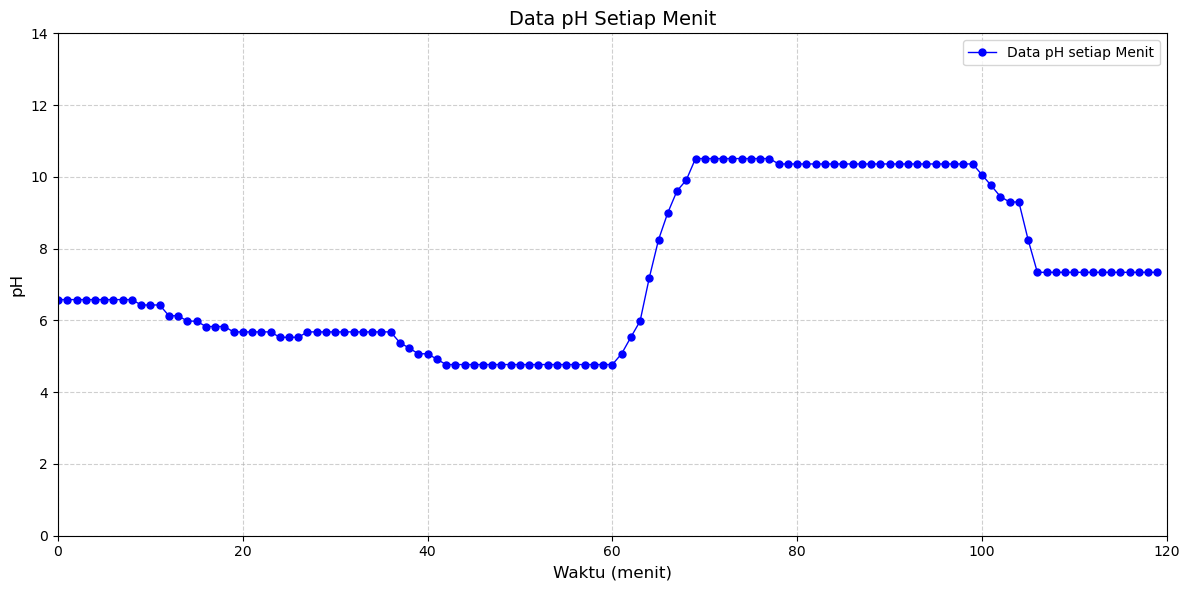

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Data
with open('Data_1s_pH_new.txt', 'r') as f:
    data = [float(line.strip().strip(',')) for line in f if line.strip()]

time_axis = np.arange(len(data))  

plt.figure(figsize=(12, 6))
plt.plot(time_axis, data, 'b-o', markersize=5, linewidth=1, label='Data pH setiap Menit')

plt.xlabel('Waktu (menit)', fontsize=12)
plt.ylabel('pH', fontsize=12)
plt.title('Data pH Setiap Menit', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

plt.xlim(0, 120)
plt.ylim(0, 14)

plt.tight_layout()
plt.show()

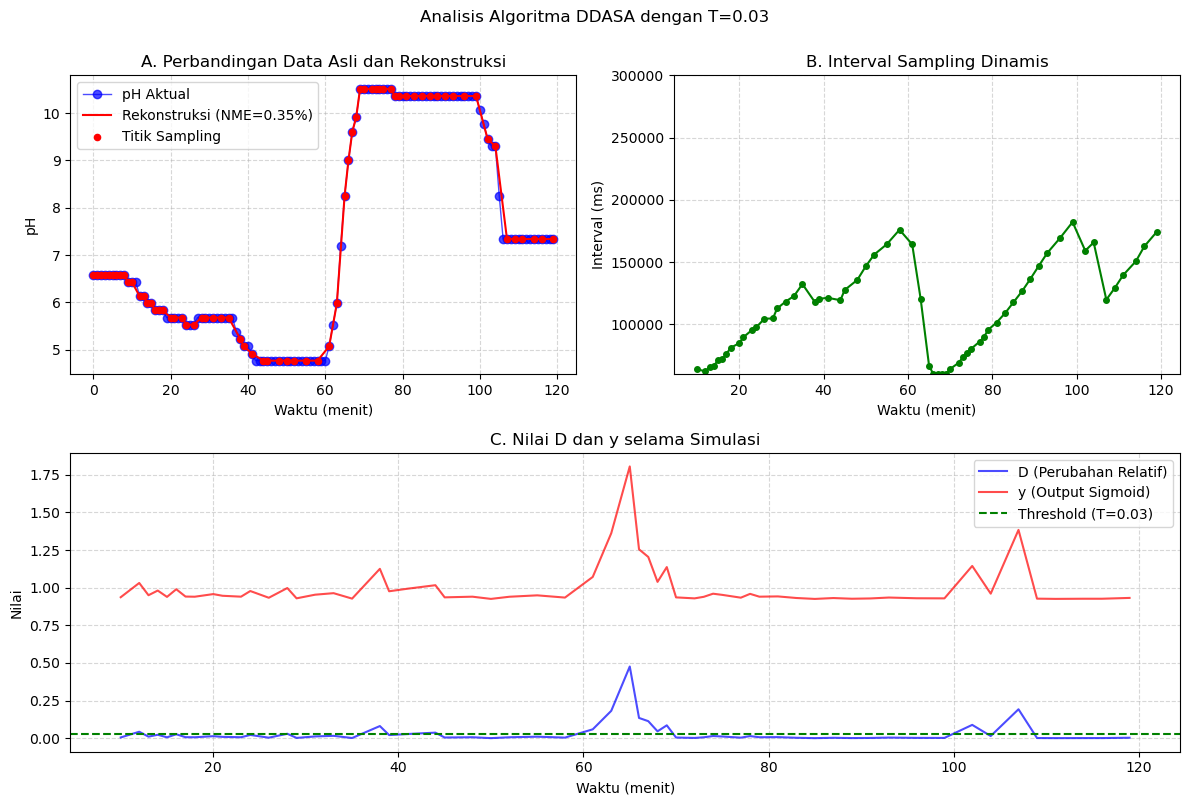

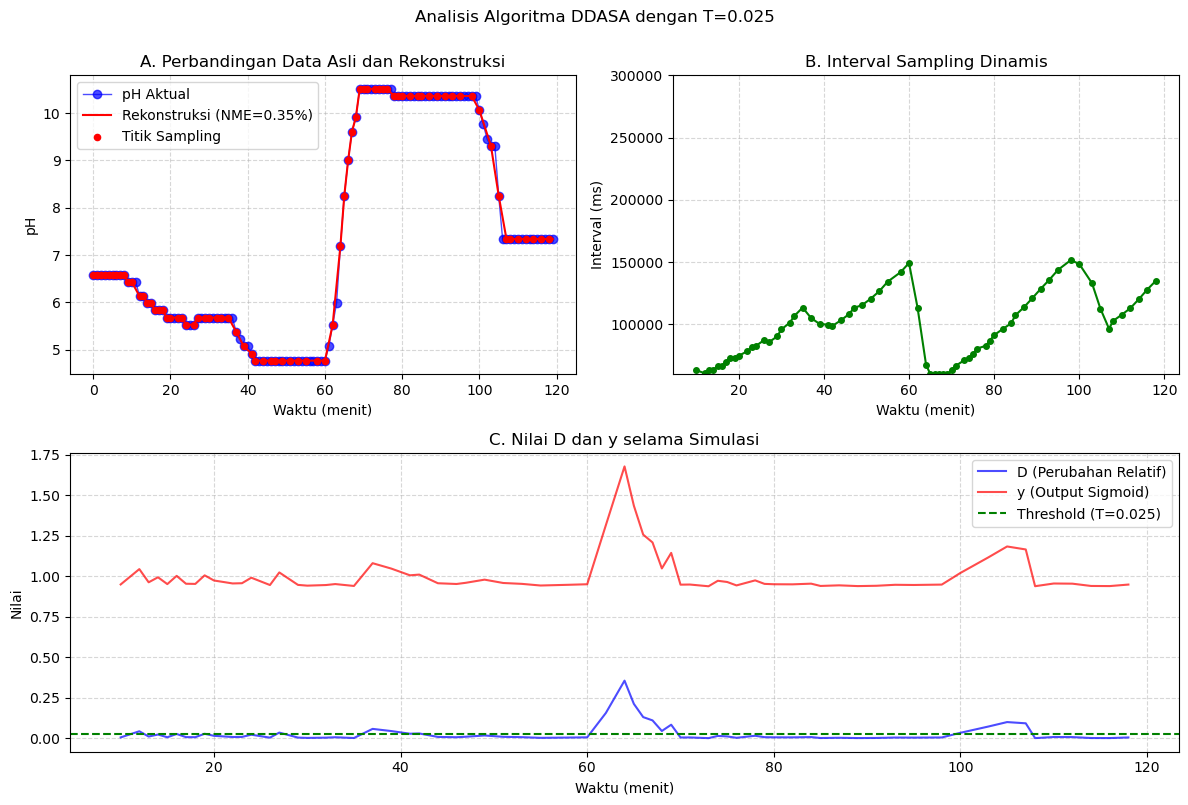

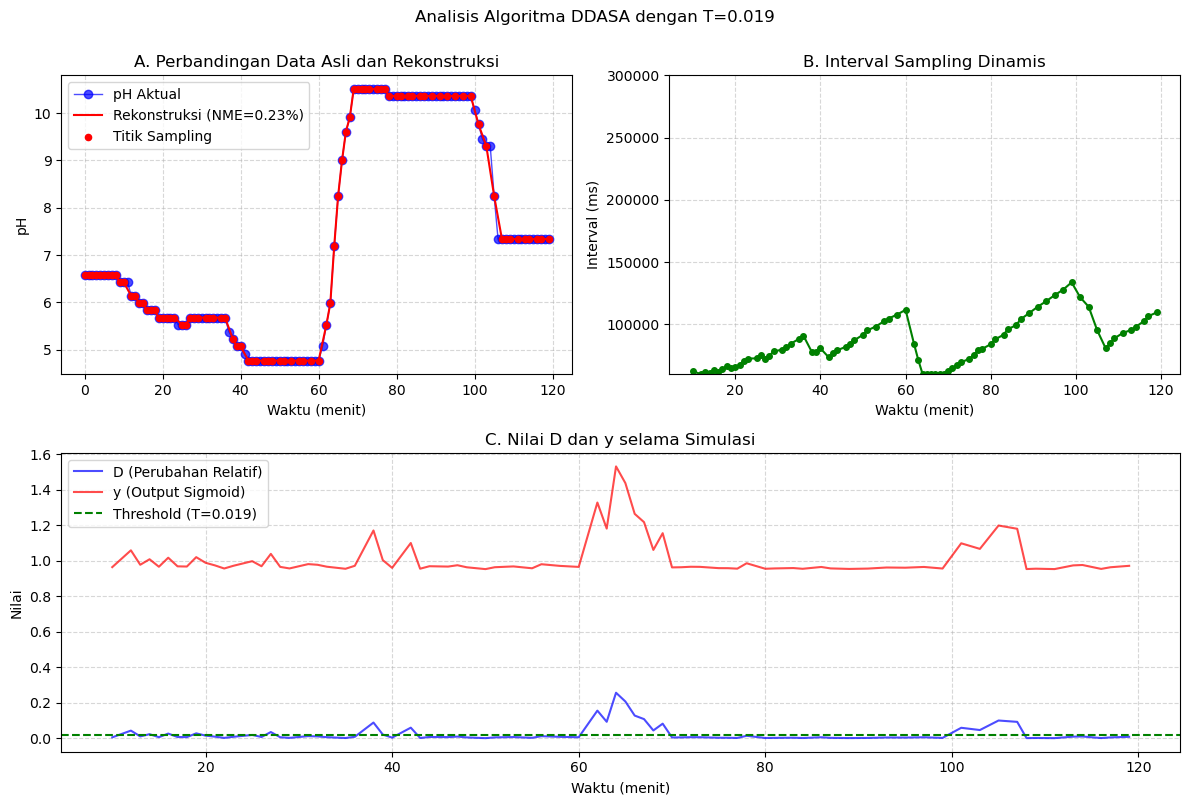

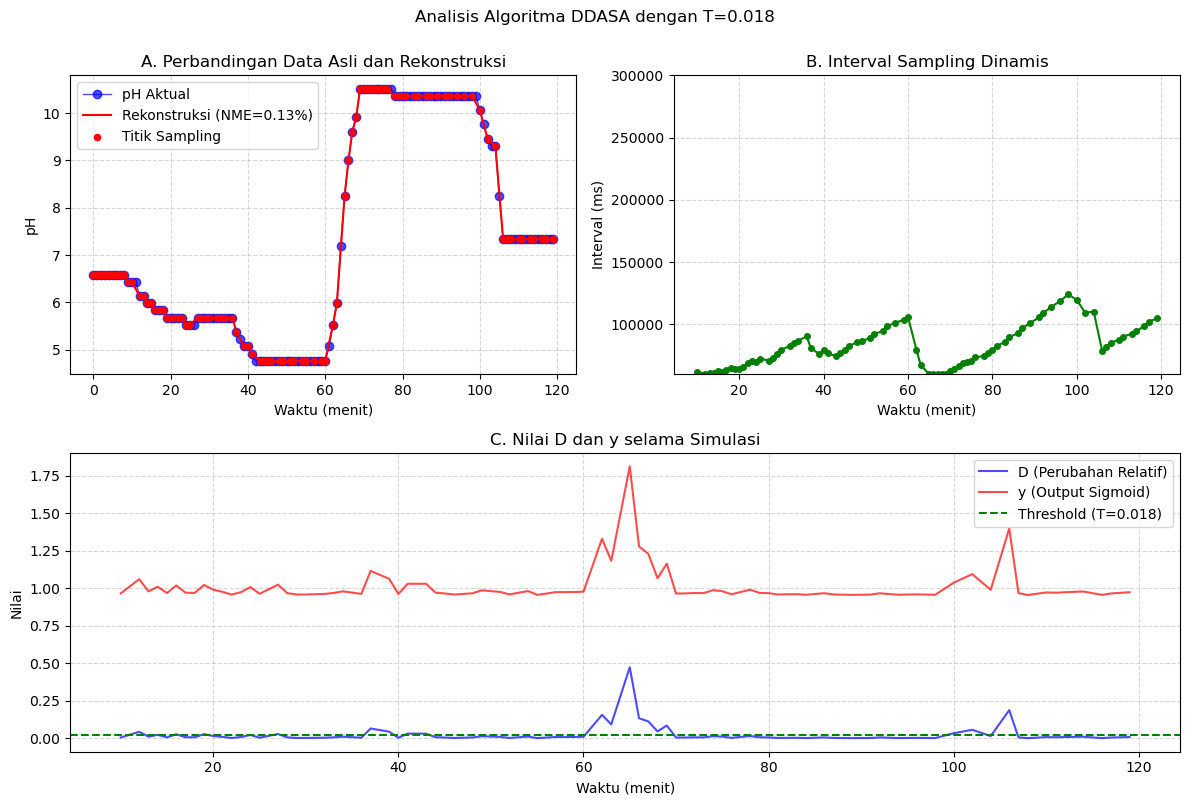

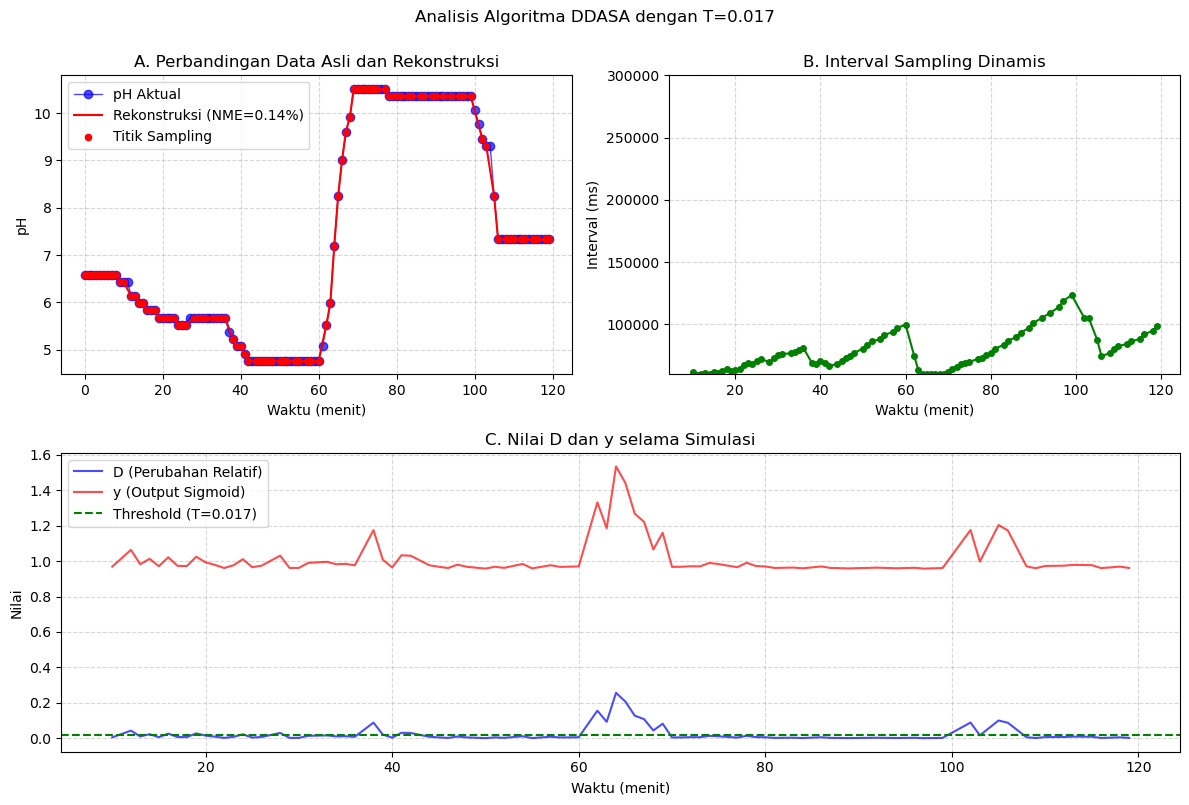

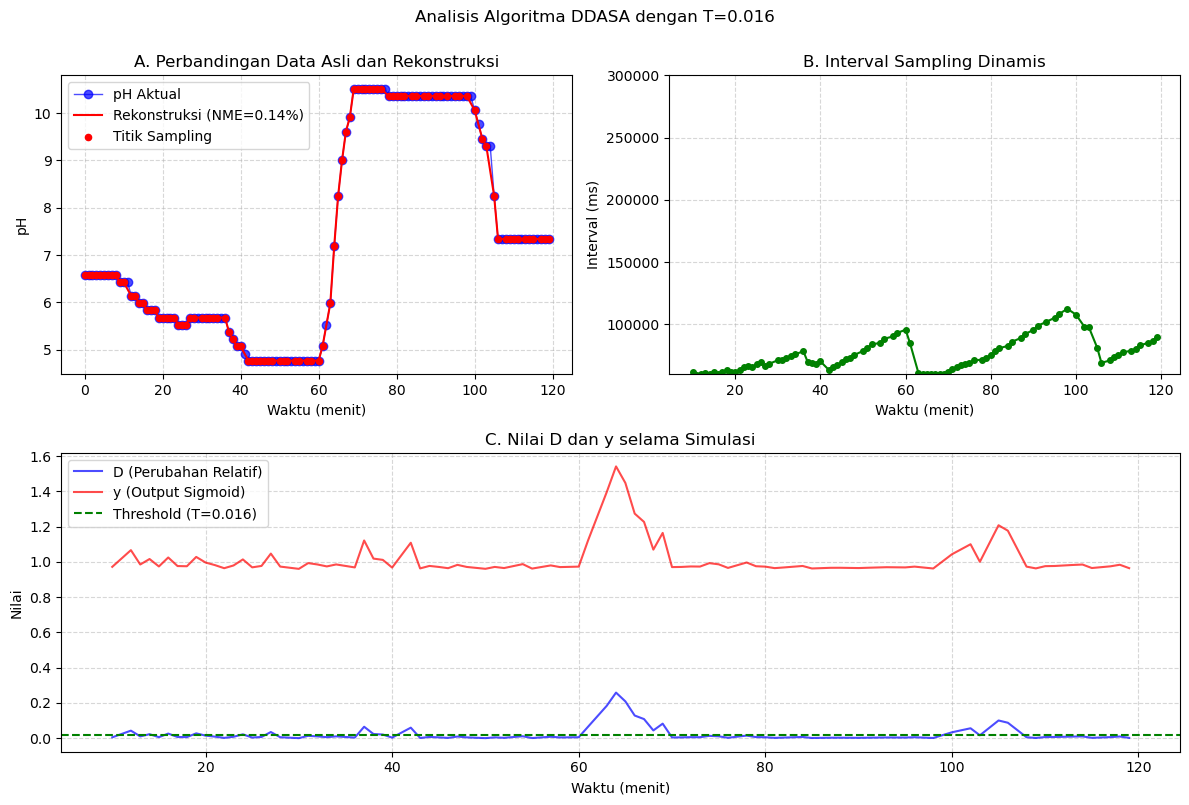

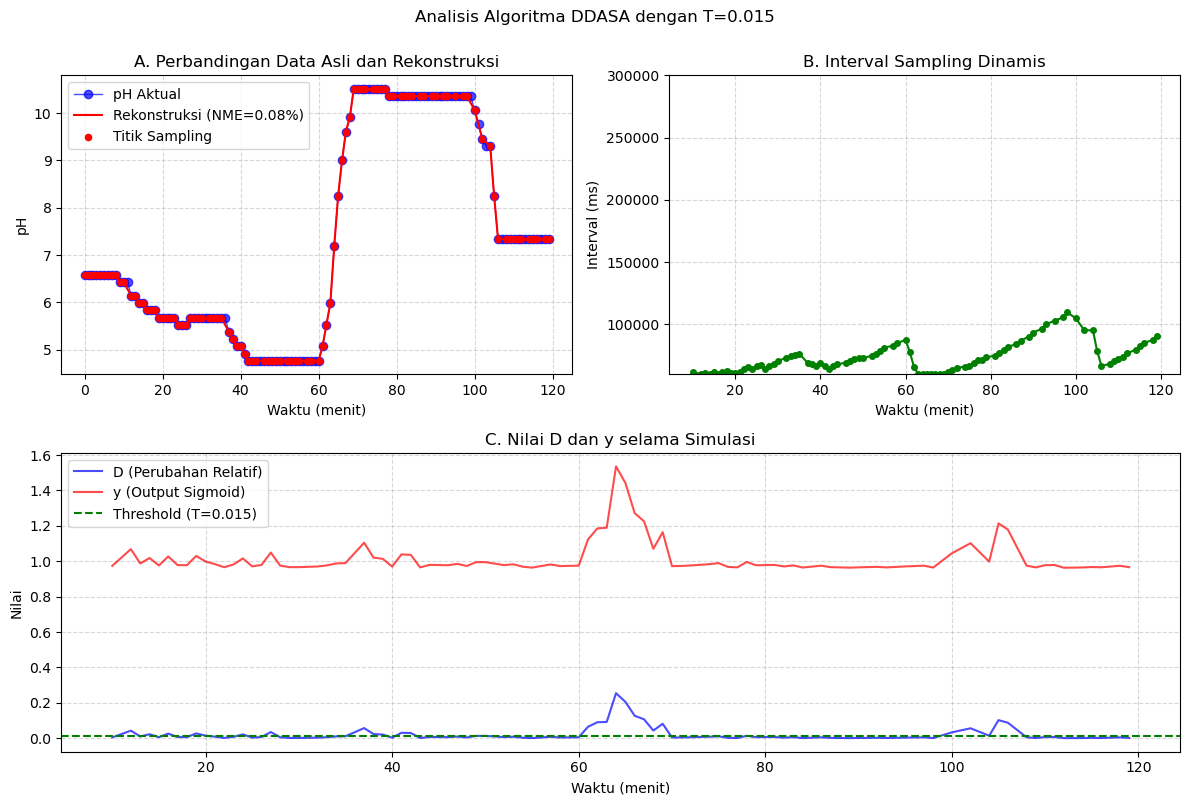

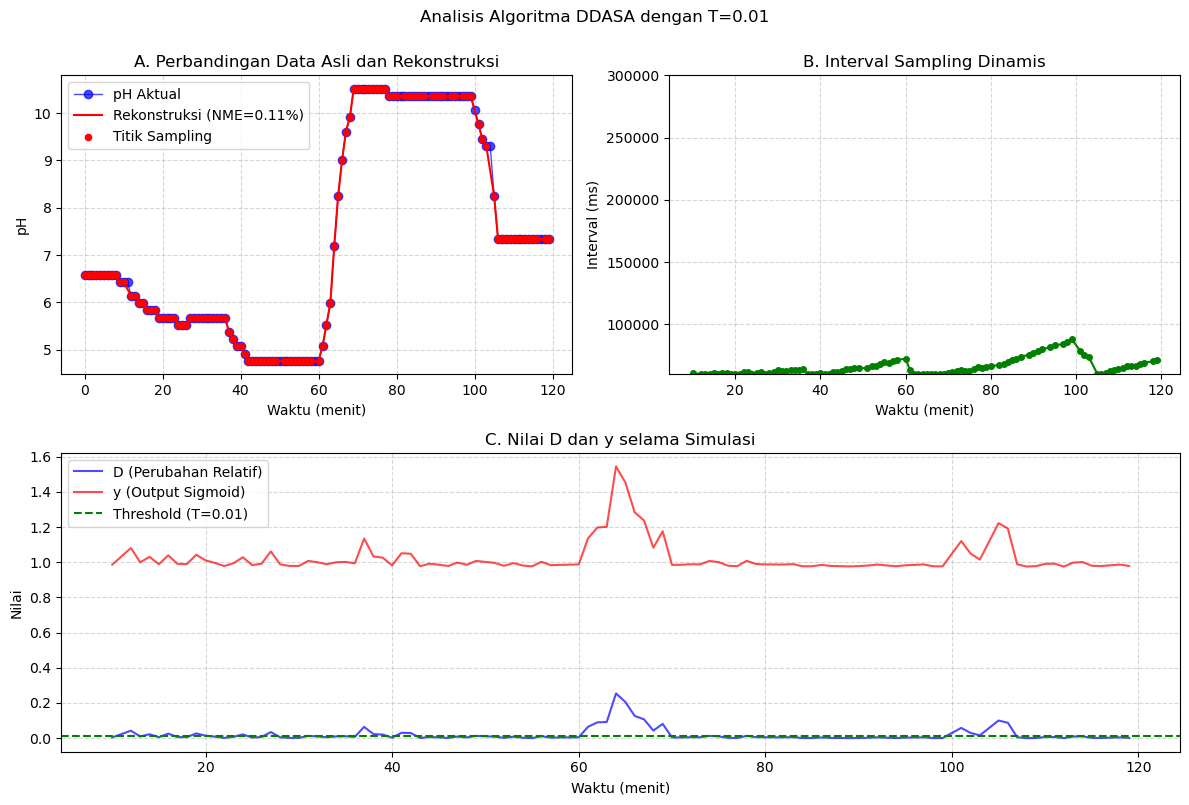


Ringkasan Hasil untuk Semua Nilai T:
T	Samples	NME(%)	Efisiensi(%)	Daya Normal(µA)		Daya DDASA(µA) 
----------------------------------------------------------------------------------------------------
0.03	70	0.35	0.00		67,045,800			67,045,300
0.025	78	0.35	0.00		67,045,800			67,045,380
0.019	89	0.23	0.00		67,045,800			67,045,490
0.018	91	0.13	0.00		67,045,800			67,045,510
0.017	95	0.14	0.00		67,045,800			67,045,550
0.016	98	0.14	0.00		67,045,800			67,045,580
0.015	100	0.08	0.00		67,045,800			67,045,600
0.01	110	0.11	0.00		67,045,800			67,045,700


In [5]:
from math import exp
import numpy as np
import matplotlib.pyplot as plt

with open('Data_1s_pH_new.txt', 'r') as f:
    data = [float(line.strip().strip(',')) for line in f if line.strip()]

np.random.seed(42)
noise = np.random.normal(0, 0.03, len(data))
noisy_data = [x + noise[i] for i, x in enumerate(data)]

N = 10                  
T_values = [0.03, 0.025, 0.019, 0.018, 0.017, 0.016, 0.015, 0.01]               
initial_interval = 60000  # ms
min_interval = 60000     # ms
max_interval = 300000    # ms
idle_current = 9390       # µA 
active_current = 9400     # µA 
delta_current = active_current - idle_current  

def sigmoid(D, T):
    return 2.0 / (1 + exp(-5*(D - T)))

def calculate_D(new_pH, prev_pH, history):
    avg = np.mean(history) 
    if avg != 0: 
        D = abs(new_pH - prev_pH) / avg
    else:
        D = 0
    return D

def simulate_ddasa(data, T):
    intervals = []
    sampling_points = list(range(N))
    D_values = []  
    y_values = []  
    history = data[:N]
    prev_pH = history[-1]
    current_interval = initial_interval
    accumulated_time = 0
    time_step = 60000  
    sample_count = N
    total_operation_time = (len(data) - 1) * 60000  

    for i in range(N, len(data)):
        new_pH = data[i]
        accumulated_time += time_step
        
        if accumulated_time < current_interval:
            continue
        
        accumulated_time -= current_interval
        
        D = calculate_D(new_pH, prev_pH, history)
        y = sigmoid(D, T)
        
        D_values.append(D)
        y_values.append(y)
        sampling_points.append(i)
        sample_count += 1
        
        new_interval = current_interval / y
        new_interval = max(min_interval, min(max_interval, new_interval))
        intervals.append(new_interval)
        current_interval = new_interval
        
        history.pop(0)
        history.append(new_pH)
        prev_pH = new_pH
    
    return sample_count, intervals, sampling_points, D_values, y_values, total_operation_time

def calculate_nme(original, sampling_points, N):
    data_min, data_max = np.min(original), np.max(original)
    original_normalized = (original - data_min) / (data_max - data_min)
    
    reconstructed_normalized = np.interp(
        np.arange(len(original)), 
        sampling_points, 
        original_normalized[sampling_points]
    )
    
    error = np.abs(reconstructed_normalized[N:] - original_normalized[N:])
    nme = np.mean(error) * 100

    reconstructed = reconstructed_normalized * (data_max - data_min) + data_min
    
    return nme, reconstructed

def calculate_power_efficiency(
    total_time_ms,
    n_normal,          
    n_ddasa,           
    idle_current,
    active_current,
    t_active=1      
):
    total_time_sec = total_time_ms / 1000
   
    energy_normal = (idle_current * total_time_sec) + (active_current - idle_current) * n_normal * t_active
    energy_ddasa = (idle_current * total_time_sec) + (active_current - idle_current) * n_ddasa * t_active
    
    efficiency = (1 - energy_ddasa / energy_normal) * 100
    return efficiency, energy_normal, energy_ddasa

results = {}

for T in T_values:
    sample_count, intervals, sampling_points, D_values, y_values, total_time_ms = simulate_ddasa(noisy_data, T)
    nme, reconstructed = calculate_nme(np.array(data), sampling_points, N)
    n_normal = len(data)
    n_ddasa = sample_count
    efficiency, power_normal, power_ddasa = calculate_power_efficiency(
        total_time_ms = total_time_ms,
        n_normal = n_normal,
        n_ddasa = n_ddasa, 
        idle_current = idle_current, 
        active_current = active_current,
        t_active = 1
    )
    
    results[T] = {
        'sample_count': sample_count,
        'intervals': intervals,
        'sampling_points': sampling_points,
        'D_values': D_values,
        'y_values': y_values,
        'nme': nme,
        'reconstructed': reconstructed,
        'efficiency': efficiency,
        'power_normal': power_normal,
        'power_ddasa': power_ddasa
    }

for T in T_values:
    res = results[T]
    time_axis = np.arange(len(data))
    sampling_time_axis = np.array(res['sampling_points'])
    
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Analisis Algoritma DDASA dengan T={T}', y=1, fontsize=12)
    
    # Grafik 1 (kiri atas): Perbandingan data asli dan rekonstruksi
    plt.subplot(2, 2, 1)
    plt.plot(time_axis, data, 'b-o', label='pH Aktual', alpha=0.7, linewidth=1)
    plt.plot(time_axis, res['reconstructed'], 'r-', label=f'Rekonstruksi (NME={res["nme"]:.2f}%)', linewidth=1.5)
    plt.scatter(
        sampling_time_axis,
        np.array(data)[res['sampling_points']], 
        color='red', s=20, label='Titik Sampling', zorder=3
    )
    plt.title('A. Perbandingan Data Asli dan Rekonstruksi')
    plt.xlabel('Waktu (menit)')
    plt.ylabel('pH')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    # Grafik 2 (kanan atas): Interval sampling
    plt.subplot(2, 2, 2)
    if res['intervals']:  
        adaptive_sampling_time = np.array(res['sampling_points'][N:]) 
        plt.plot(adaptive_sampling_time, res['intervals'], 'g-', marker='o', markersize=4)
    plt.title('B. Interval Sampling Dinamis')
    plt.xlabel('Waktu (menit)')
    plt.ylabel('Interval (ms)')
    plt.ylim(min_interval - 100, max_interval + 100)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Grafik 3 (kiri bawah): Nilai D dan y
    plt.subplot(2, 1, 2)
    if res['D_values']:  
        adaptive_time_axis = np.array(res['sampling_points'][N:])
        plt.plot(adaptive_time_axis, res['D_values'], 'b-', label='D (Perubahan Relatif)', alpha=0.7)
        plt.plot(adaptive_time_axis, res['y_values'], 'r-', label='y (Output Sigmoid)', alpha=0.7)
    plt.axhline(y=T, color='g', linestyle='--', label=f'Threshold (T={T})')
    plt.title('C. Nilai D dan y selama Simulasi')
    plt.xlabel('Waktu (menit)')
    plt.ylabel('Nilai')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Tampilkan tabel ringkasan
print("\nRingkasan Hasil untuk Semua Nilai T:")
print("="*100)
print("T\tSamples\tNME(%)\tEfisiensi(%)\tDaya Normal(µA)\t\tDaya DDASA(µA) ")
print("-"*100)
for T in T_values:
    res = results[T]
    print(f"{T}\t{res['sample_count']}\t{res['nme']:.2f}\t{res['efficiency']:.2f}\t\t{res['power_normal']:,.0f}\t\t\t{res['power_ddasa']:,.0f}")
print("="*100)

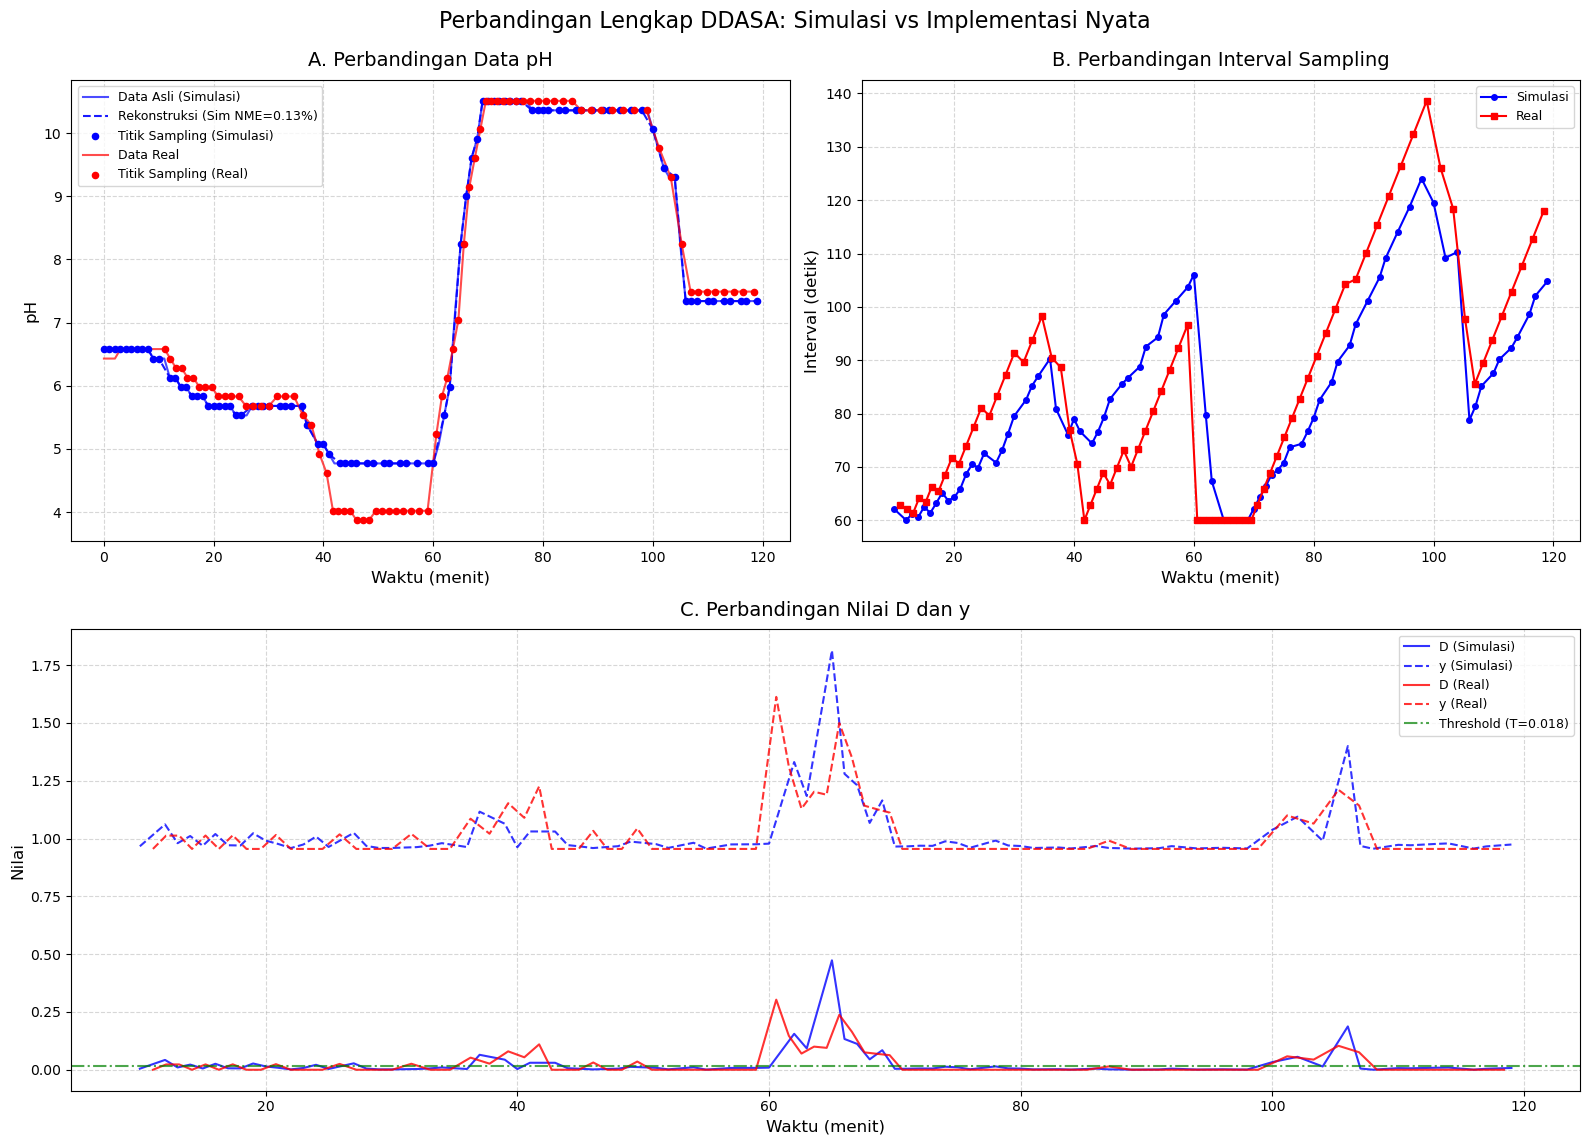


PERBANDINGAN KINERJA DDASA (pH)
+--------------------+------------+----------------------+
| Parameter          | Simulasi   | Implementasi Nyata   |
+====================+============+======================+
| Threshold (T)      | 0.018      | 0.018                |
+--------------------+------------+----------------------+
| Jumlah Sampel      | 91         | 89                   |
+--------------------+------------+----------------------+
| NME (%)            | 0.13       | 4.57                 |
+--------------------+------------+----------------------+
| Efisiensi Daya (%) | 0.00       | -0.00                |
+--------------------+------------+----------------------+
| Daya Normal (mA·s) | 67045.8    | 66715.1              |
+--------------------+------------+----------------------+
| Daya DDASA (mA·s)  | 67045.5    | 66715.2              |
+--------------------+------------+----------------------+
| Penghematan Daya   | 0.3 mA·s   | -0.1 mA·s            |
+--------------------+-

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from datetime import datetime, timedelta, date
from tabulate import tabulate

def parse_real_data(file_content):
    real_data_all_pH = [] 
    real_all_times = []     
    real_ddasa_recorded_pH = []
    real_ddasa_times = []
    real_ddasa_D_values = []
    real_ddasa_y_values = []
    real_ddasa_intervals = []
    actual_sampling_indices_in_full_data = []

    lines = [line for line in file_content.split('\n') if '-> pH:' in line]
    if not lines:
        raise ValueError("Tidak ditemukan data yang sesuai format")
    
    start_time_obj = None
    rollover_days = 0
    prev_datetime_obj = None 
    
    for line_idx, line in enumerate(lines):
        try:
            time_part_full = line.split('->')[0].strip()
            if ']' in time_part_full: 
                time_part_cleaned = time_part_full.split(']', 1)[1].strip()
            else:
                time_part_cleaned = time_part_full 

            current_time_parsed = None
            try:
                current_time_parsed = datetime.strptime(time_part_cleaned, '%H:%M:%S.%f').time()
            except ValueError:
                current_time_parsed = datetime.strptime(time_part_cleaned, '%H:%M:%S').time()
            
            current_date_to_use = date(2000, 1, 1) + timedelta(days=rollover_days) 
            current_datetime = datetime.combine(current_date_to_use, current_time_parsed)
            
            if prev_datetime_obj:
                if current_time_parsed < prev_datetime_obj.time() and \
                   (prev_datetime_obj - datetime.combine(prev_datetime_obj.date(), current_time_parsed)).total_seconds() > 12 * 3600:
                    rollover_days += 1
                    current_date_to_use = date(2000, 1, 1) + timedelta(days=rollover_days)
                    current_datetime = datetime.combine(current_date_to_use, current_time_parsed)
            
            if start_time_obj is None:
                start_time_obj = current_datetime 
            
            delta_seconds = (current_datetime - start_time_obj).total_seconds()
            real_all_times.append(delta_seconds)
            prev_datetime_obj = current_datetime
            
            data_part_str = line.split('-> pH:')[1].strip()
            split_data_parts = data_part_str.split('|')
            
            pH = float(split_data_parts[0].strip())
            real_data_all_pH.append(pH)
            
            current_idx_in_all_pH = len(real_data_all_pH) - 1

            if len(split_data_parts) > 1: 
                actual_sampling_indices_in_full_data.append(current_idx_in_all_pH)
                real_ddasa_recorded_pH.append(pH) 
                real_ddasa_times.append(delta_seconds) 
                real_ddasa_D_values.append(float(split_data_parts[1].replace('D:', '').strip()))
                real_ddasa_y_values.append(float(split_data_parts[2].replace('y(D):', '').strip()))
                real_ddasa_intervals.append(float(split_data_parts[3].replace('Interval:', '').replace('ms', '').strip()))
                
        except Exception as e:
            print(f"Gagal parsing baris {line_idx + 1}: {line}\nError: {str(e)}")
            continue
            
    return {
        'pH': real_data_all_pH,    
        'times': real_all_times,            
        'ddasa_recorded_pH': real_ddasa_recorded_pH, 
        'ddasa_times': real_ddasa_times,                
        'ddasa_intervals': real_ddasa_intervals,
        'ddasa_D_values': real_ddasa_D_values,
        'ddasa_y_values': real_ddasa_y_values,
        'sampling_indices': actual_sampling_indices_in_full_data 
    }

def sigmoid(D, T):
    return 2.0 / (1 + exp(-5*(D - T)))

def calculate_D(new_pH, prev_pH, history):
    avg = np.mean(history) 
    if avg != 0: 
        D = abs(new_pH - prev_pH) / avg
    else:
        D = 0
    return D

def simulate_ddasa(data, T):
    intervals = []
    sampling_points = list(range(N))
    D_values = []  
    y_values = []  
    history = data[:N]
    prev_pH = history[-1]
    current_interval = initial_interval
    accumulated_time = 0
    time_step = 60000  
    sample_count = N
    total_operation_time = (len(data) - 1) * 60000  

    for i in range(N, len(data)):
        new_pH = data[i]
        accumulated_time += time_step
        
        if accumulated_time < current_interval:
            continue
        
        accumulated_time -= current_interval
        
        D = calculate_D(new_pH, prev_pH, history)
        y = sigmoid(D, T)
        
        D_values.append(D)
        y_values.append(y)
        sampling_points.append(i)
        sample_count += 1
        
        new_interval = current_interval / y
        new_interval = max(min_interval, min(max_interval, new_interval))
        intervals.append(new_interval)
        current_interval = new_interval
        
        history.pop(0)
        history.append(new_pH)
        prev_pH = new_pH
    
    return sample_count, intervals, sampling_points, D_values, y_values, total_operation_time

def calculate_nme(original, sampling_points, N):
    data_min, data_max = np.min(original), np.max(original)
    original_normalized = (original - data_min) / (data_max - data_min)
    
    reconstructed_normalized = np.interp(
        np.arange(len(original)), 
        sampling_points, 
        original_normalized[sampling_points]
    )
    
    error = np.abs(reconstructed_normalized[N:] - original_normalized[N:])
    nme = np.mean(error) * 100

    reconstructed = reconstructed_normalized * (data_max - data_min) + data_min
    
    return nme, reconstructed

def calculate_power_efficiency(
    total_time_ms,
    n_normal,        
    n_ddasa,          
    idle_current,
    active_current,
    t_active=1   
):
    total_time_sec = total_time_ms / 1000
    
    energy_normal = (idle_current * total_time_sec) + (active_current - idle_current) * n_normal * t_active
    energy_ddasa = (idle_current * total_time_sec) + (active_current - idle_current) * n_ddasa * t_active
    
    efficiency = (1 - energy_ddasa / energy_normal) * 100
    return efficiency, energy_normal, energy_ddasa

# Baca data real dari file
with open('Data_DDASA_pH_new.txt', 'r') as f:
    real_content = f.read()
real_results = parse_real_data(real_content)

# Baca data untuk simulasi
with open('Data_1s_pH_new.txt', 'r') as f:
    data = [float(line.strip().strip(',')) for line in f if line.strip()]

np.random.seed(42)
noise = np.random.normal(0, 0.03, len(data))
noisy_data = [x + noise[i] for i, x in enumerate(data)]

N = 10              
T = 0.018  # Nilai threshold spesifik untuk simulasi
initial_interval = 60000  # ms
min_interval = 60000      # ms
max_interval = 300000     # ms
idle_current = 9390        # µA 
active_current = 9400    # µA 
t_active = 1           # Durasi sampling aktif (detik)

sim_sample_count, sim_intervals, sim_sampling_indices, sim_D_values, sim_y_values, total_time_ms = simulate_ddasa(noisy_data, T)
sim_nme, sim_reconstructed = calculate_nme(np.array(data), sim_sampling_indices, N)
n_normal_sim = len(data)
n_ddasa_sim = sim_sample_count
sim_efficiency, sim_power_normal, sim_power_ddasa = calculate_power_efficiency(
    total_time_ms=total_time_ms,
    n_normal=n_normal_sim,
    n_ddasa=n_ddasa_sim,
    idle_current=idle_current,
    active_current=active_current,
    t_active=t_active
)

total_time_real_sec = real_results['times'][-1] if real_results['times'] else 0

n_normal_real = int(total_time_real_sec/90) + 1

total_real_samples = len(real_results['pH'])

real_efficiency, real_power_normal, real_power_ddasa = calculate_power_efficiency(
    total_time_ms=total_time_real_sec * 1000, 
    n_normal=n_normal_real,
    n_ddasa=total_real_samples,
    idle_current=idle_current,
    active_current=active_current,
    t_active=t_active
)

def calculate_direct_nme(ground_truth, recorded_pH, recorded_times, total_points):
    if not recorded_times or not ground_truth:
        return 0.0
    
    time_step = 60  # detik
    recorded_indices = [int(t / time_step) for t in recorded_times]
    
    recorded_indices = [idx for idx in recorded_indices if idx < len(ground_truth)]
    
    if not recorded_indices:
        return 0.0
    
    sampled_values = np.array(recorded_pH[:len(recorded_indices)])
    actual_values = np.array(ground_truth)[recorded_indices]
    
    data_min = min(ground_truth)
    data_max = max(ground_truth)
    
    if data_max == data_min:
        return 0.0
    
    actual_normalized = (actual_values - data_min) / (data_max - data_min)
    sampled_normalized = (sampled_values - data_min) / (data_max - data_min)
    
    error = np.abs(actual_normalized - sampled_normalized)
    nme = np.mean(error) * 100
    
    return nme

real_direct_nme = calculate_direct_nme(
    ground_truth=data,
    recorded_pH=real_results['ddasa_recorded_pH'],
    recorded_times=real_results['ddasa_times'],
    total_points=len(data)
)

plt.figure(figsize=(16, 12))
plt.suptitle('Perbandingan Lengkap DDASA: Simulasi vs Implementasi Nyata', fontsize=16, y=0.95)

# 1. Perbandingan data pH
ax1 = plt.subplot(2, 2, 1)
# Data simulasi
sim_time_min = np.arange(len(data)) * 1  # Konversi ke menit
plt.plot(sim_time_min, data, 'b-', label='Data Asli (Simulasi)', alpha=0.7, linewidth=1.5)
plt.plot(sim_time_min, sim_reconstructed, 'b--', label=f'Rekonstruksi (Sim NME={sim_nme:.2f}%)', alpha=0.9, linewidth=1.5)

# Titik sampling simulasi
plt.scatter(
    np.array(sim_sampling_indices) * 1 ,
    np.array(data)[sim_sampling_indices], 
    color='blue', s=20, label='Titik Sampling (Simulasi)', zorder=3
)

# Data real
real_time_min = np.array(real_results['times']) / 60  # Konversi detik ke menit
plt.plot(real_time_min, real_results['pH'], 'r-', label='Data Real', alpha=0.7, linewidth=1.5)

plt.scatter(
    np.array(real_results['ddasa_times']) / 60, 
    real_results['ddasa_recorded_pH'], 
    color='red', s=20, label='Titik Sampling (Real)', zorder=3
)

plt.title('A. Perbandingan Data pH', pad=10, fontsize=14)
plt.xlabel('Waktu (menit)', fontsize=12)
plt.ylabel('pH', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9, loc='best')

# 2. Perbandingan interval sampling
ax2 = plt.subplot(2, 2, 2)
# Simulasi: hanya titik adaptif (setelah N)
sim_adaptive_times = np.array(sim_sampling_indices[N:]) * 1 
plt.plot(sim_adaptive_times, np.array(sim_intervals)/1000, 'b-', marker='o', markersize=4, 
         label='Simulasi')

plt.plot(np.array(real_results['ddasa_times']) / 60, np.array(real_results['ddasa_intervals'])/1000, 
         'r-', marker='s', markersize=4, label='Real')

plt.title('B. Perbandingan Interval Sampling', pad=10, fontsize=14)
plt.xlabel('Waktu (menit)', fontsize=12)
plt.ylabel('Interval (detik)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9)

# 3. Perbandingan nilai D dan y
ax3 = plt.subplot(2, 1, 2)
# Simulasi: D dan y
plt.plot(sim_adaptive_times, sim_D_values, 'b-', label='D (Simulasi)', alpha=0.8, linewidth=1.5)
plt.plot(sim_adaptive_times, sim_y_values, 'b--', label='y (Simulasi)', alpha=0.8, linewidth=1.5)

real_ddasa_time_min = np.array(real_results['ddasa_times']) / 60
plt.plot(real_ddasa_time_min, real_results['ddasa_D_values'], 'r-', label='D (Real)', alpha=0.8, linewidth=1.5)
plt.plot(real_ddasa_time_min, real_results['ddasa_y_values'], 'r--', label='y (Real)', alpha=0.8, linewidth=1.5)

plt.axhline(y=T, color='g', linestyle='-.', label=f'Threshold (T={T})', linewidth=1.5, alpha=0.7)
plt.title('C. Perbandingan Nilai D dan y', pad=10, fontsize=14)
plt.xlabel('Waktu (menit)', fontsize=12)
plt.ylabel('Nilai', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9, loc='best')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('perbandingan_komprehensif.png', dpi=300, bbox_inches='tight')
plt.show()

summary_data = [
    ["Parameter", "Simulasi", "Implementasi Nyata"],
    ["Threshold (T)", f"{T}", f"{T}"],
    ["Jumlah Sampel", f"{sim_sample_count}", f"{total_real_samples}"],
    ["NME (%)", f"{sim_nme:.2f}", f"{real_direct_nme:.2f}"],
    ["Efisiensi Daya (%)", f"{sim_efficiency:.2f}", f"{real_efficiency:.2f}"],
    ["Daya Normal (mA·s)", f"{sim_power_normal/1000:.1f}", f"{real_power_normal/1000:.1f}"],
    ["Daya DDASA (mA·s)", f"{sim_power_ddasa/1000:.1f}", f"{real_power_ddasa/1000:.1f}"],
    ["Penghematan Daya", f"{(sim_power_normal - sim_power_ddasa)/1000:.1f} mA·s", 
     f"{(real_power_normal - real_power_ddasa)/1000:.1f} mA·s"]
]

print("\nPERBANDINGAN KINERJA DDASA (pH)")
print(tabulate(summary_data, headers="firstrow", tablefmt="grid"))

Sensor DO

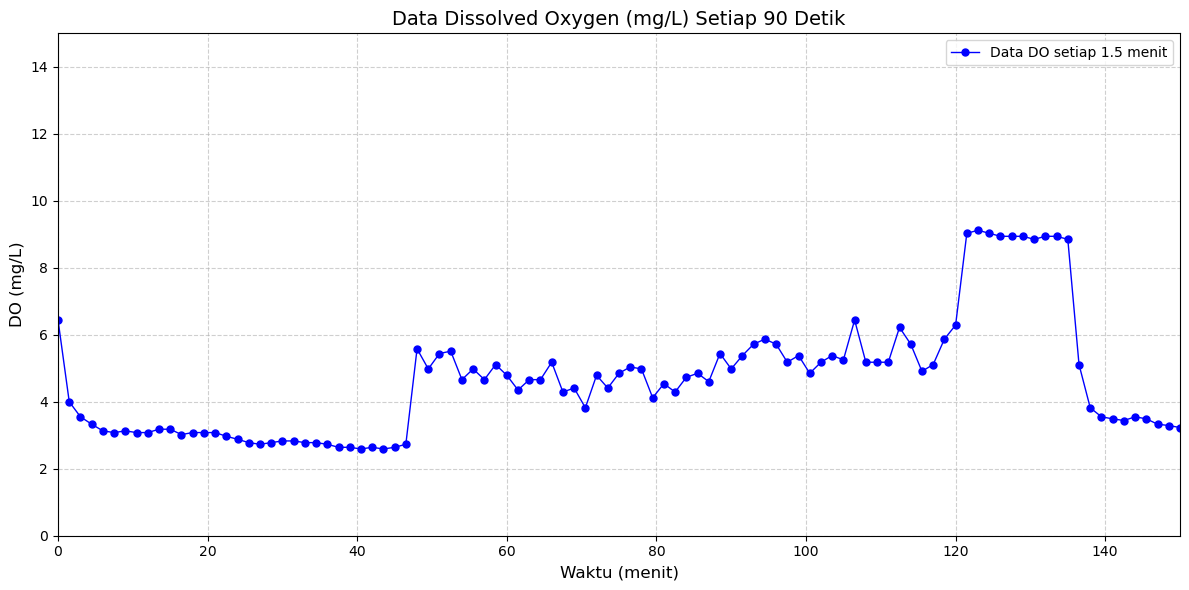

In [7]:
import numpy as np
import matplotlib.pyplot as plt

with open('Data_1s_DO.txt', 'r') as f:
    data = [float(line.strip().strip(',')) for line in f if line.strip()]

time_axis = np.arange(len(data)) * 1.5 

plt.figure(figsize=(12, 6))
plt.plot(time_axis, data, 'b-o', markersize=5, linewidth=1, label='Data DO setiap 1.5 menit')

plt.xlabel('Waktu (menit)', fontsize=12)
plt.ylabel('DO (mg/L)', fontsize=12)
plt.title('Data Dissolved Oxygen (mg/L) Setiap 90 Detik', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

plt.xlim(0, 150)
plt.ylim(0, 15)

plt.tight_layout()
plt.show()

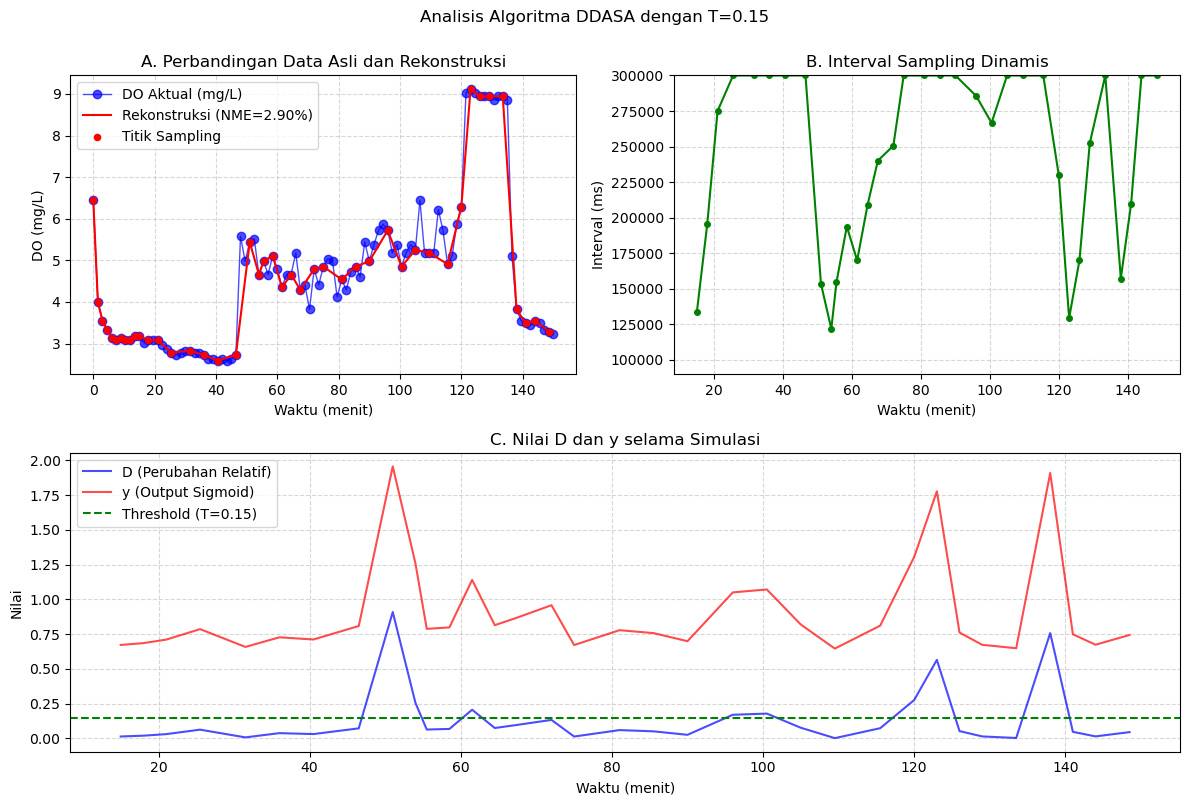

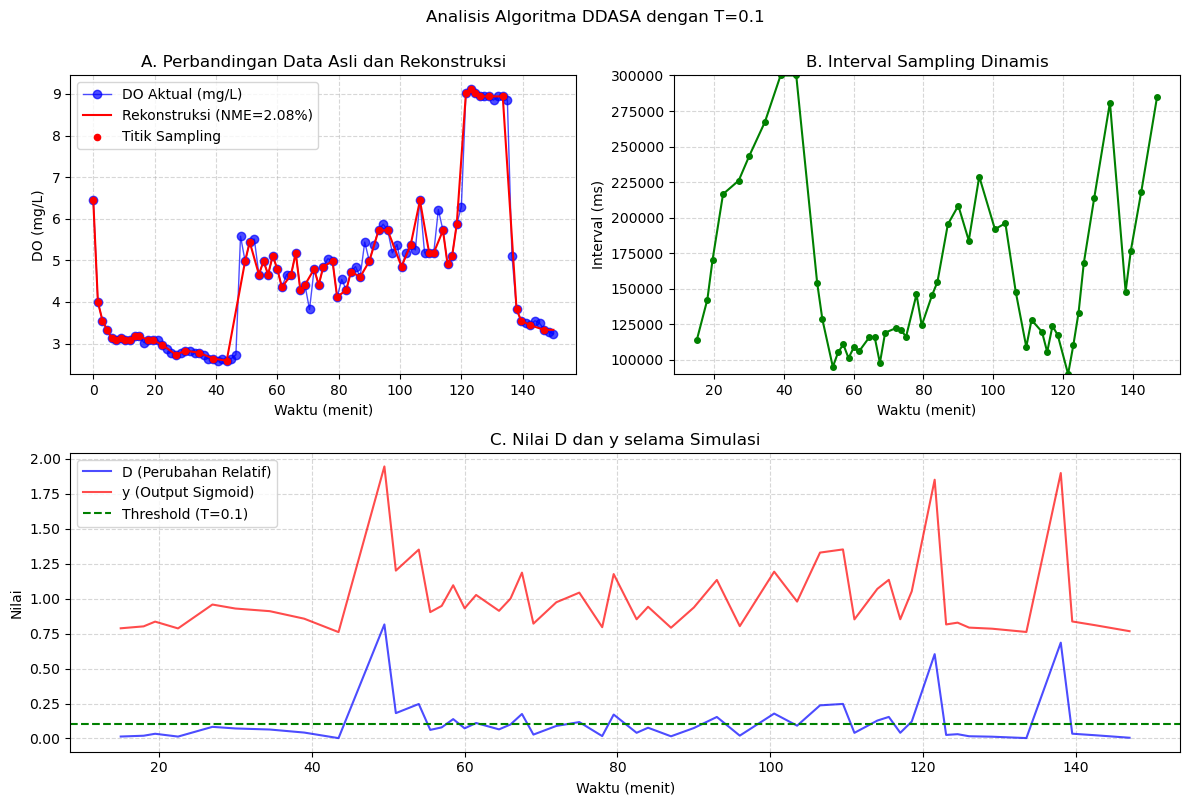

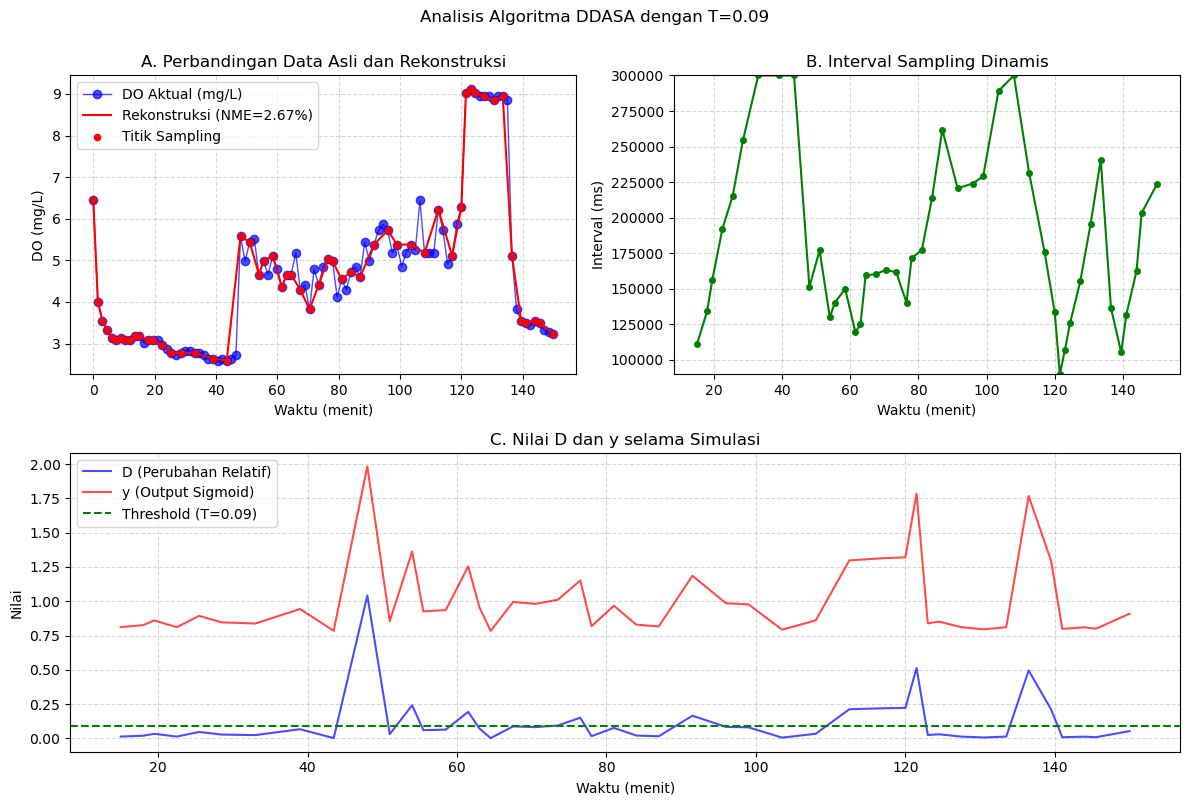

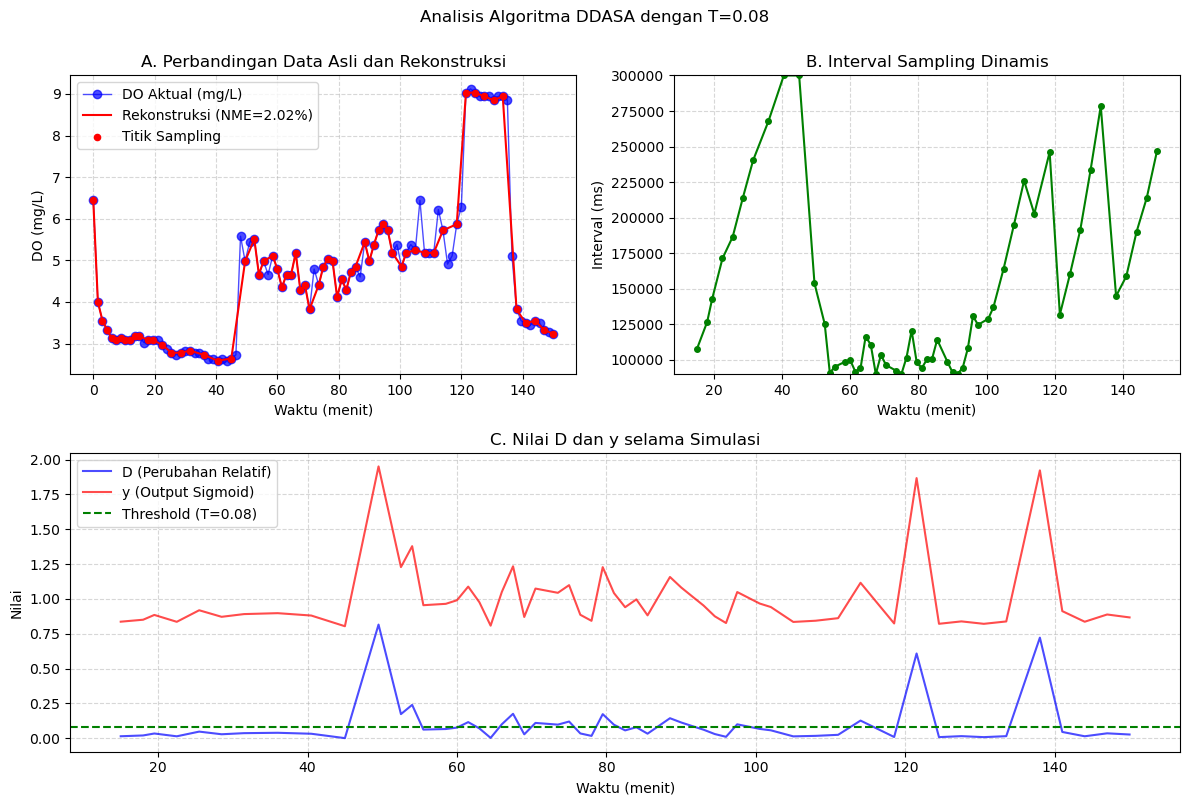

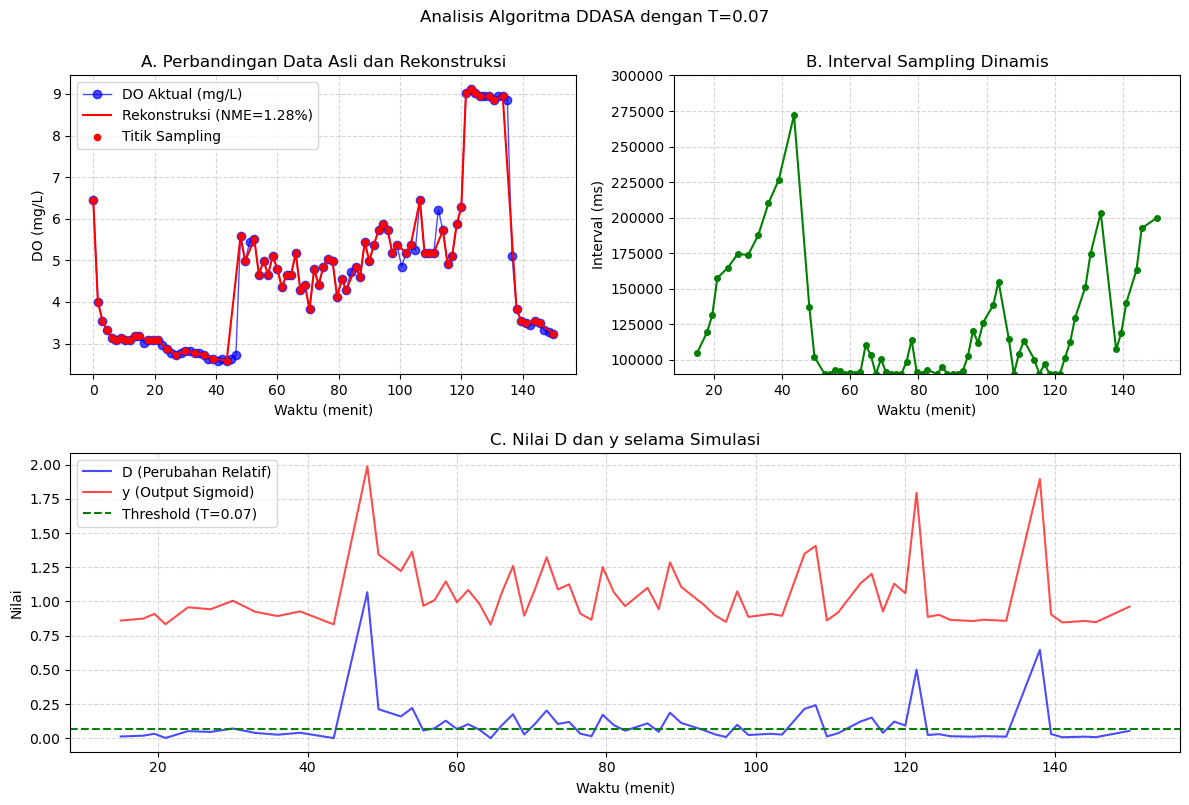

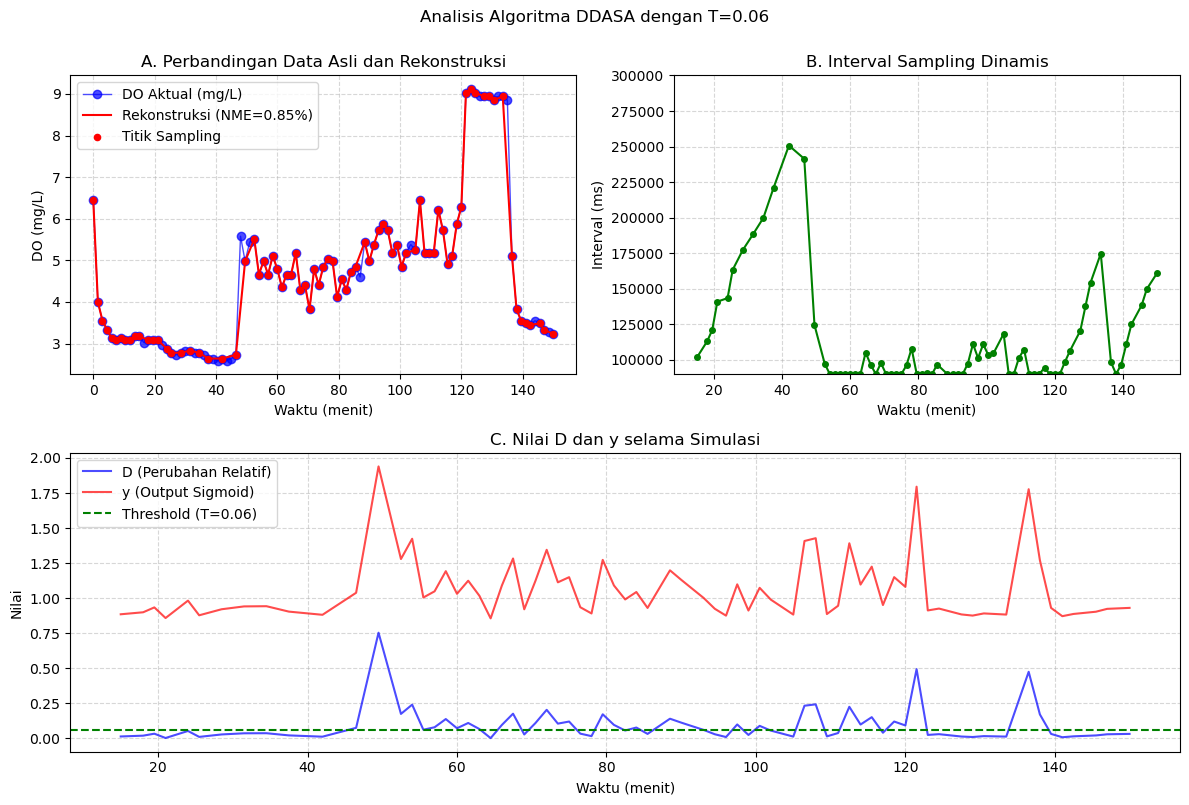

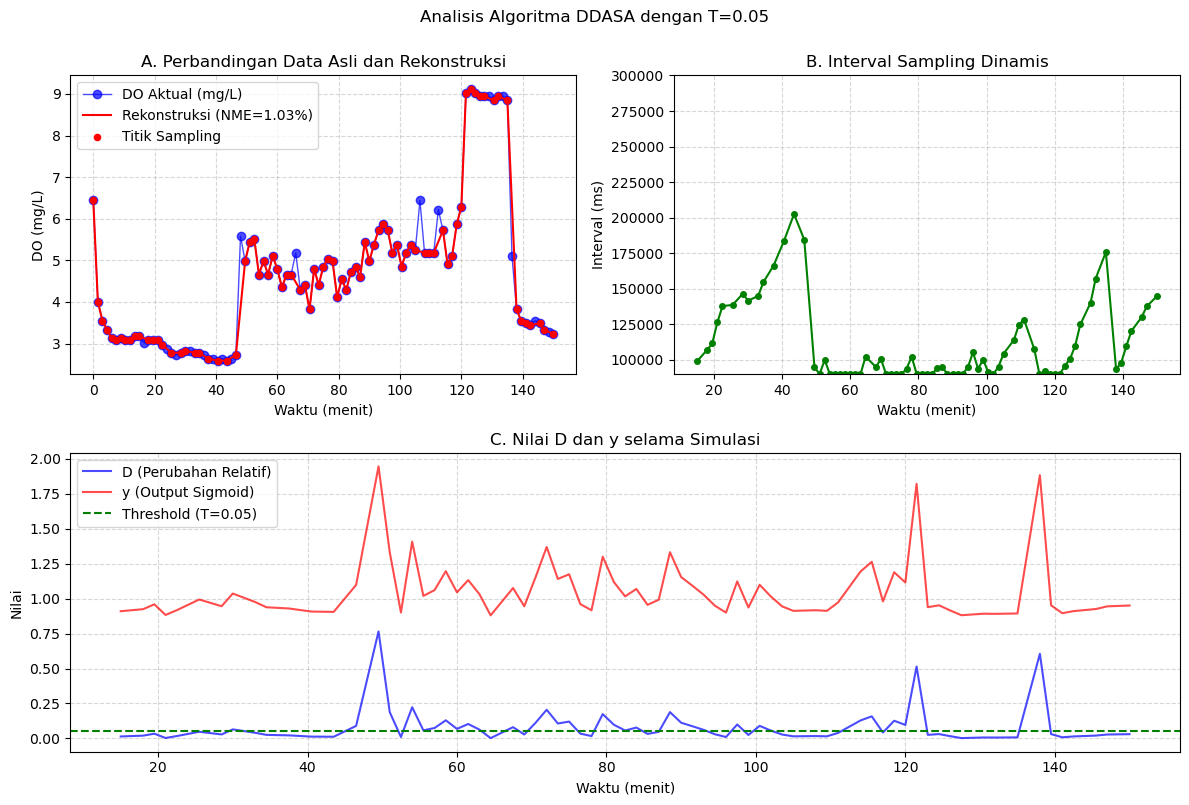

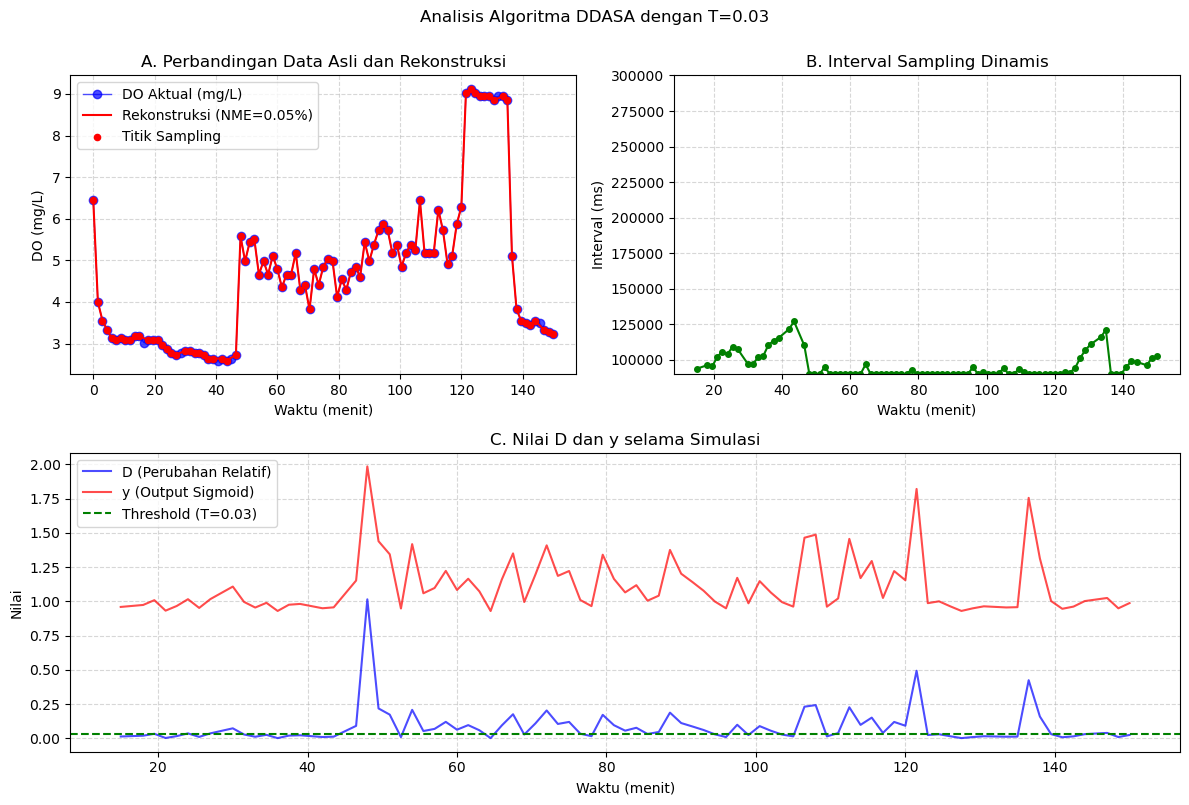

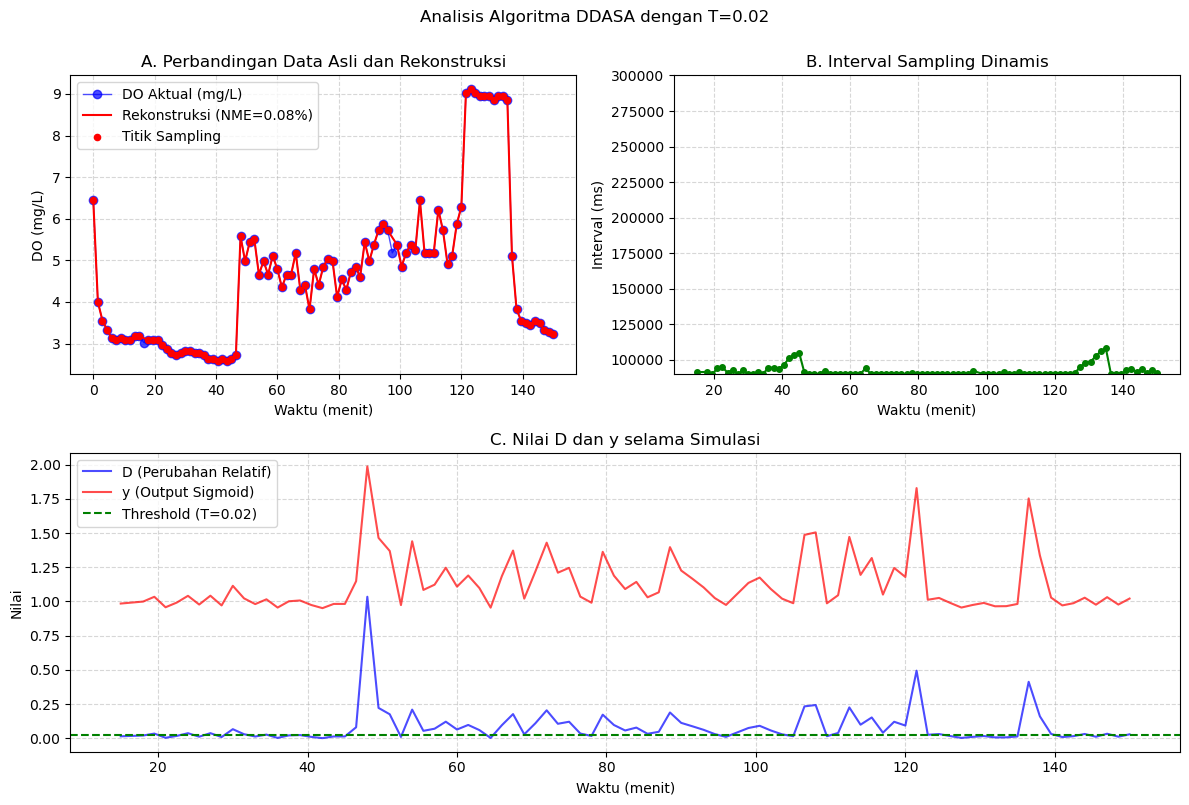

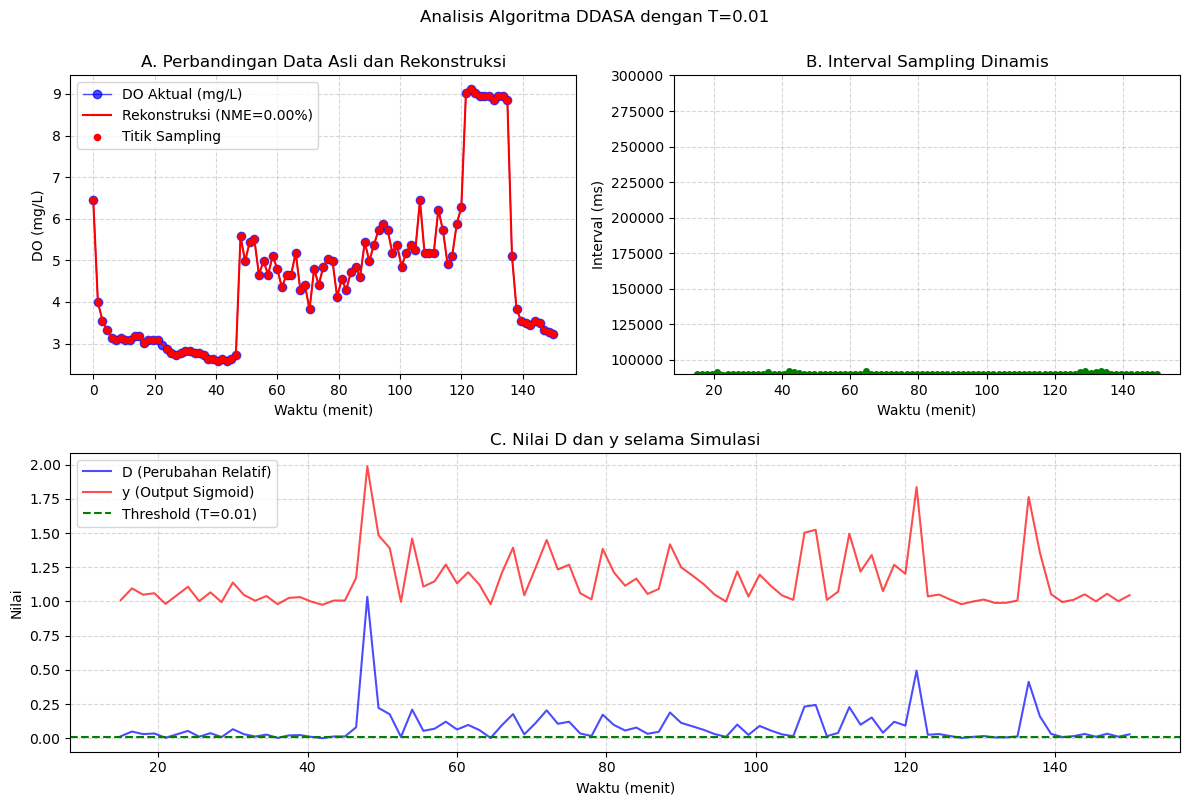


Ringkasan Hasil untuk Semua Nilai T:
T	Samples	NME(%)	Efisiensi(%)	Daya Normal(µA)		Daya DDASA(µA) 
----------------------------------------------------------------------------------------------------
0.15	44	2.90	0.00		13,698,101			13,698,044
0.1	61	2.08	0.00		13,698,101			13,698,061
0.09	55	2.67	0.00		13,698,101			13,698,055
0.08	66	2.02	0.00		13,698,101			13,698,066
0.07	78	1.28	0.00		13,698,101			13,698,078
0.06	82	0.85	0.00		13,698,101			13,698,082
0.05	84	1.03	0.00		13,698,101			13,698,084
0.03	95	0.05	0.00		13,698,101			13,698,095
0.02	99	0.08	0.00		13,698,101			13,698,099
0.01	100	0.00	0.00		13,698,101			13,698,100


In [8]:
from math import exp
import numpy as np
import matplotlib.pyplot as plt

with open('Data_1s_DO.txt', 'r') as f:
    data = [float(line.strip().strip(',')) for line in f if line.strip()]

np.random.seed(42)
noise = np.random.normal(0, 0.05, len(data))
noisy_data = [x + noise[i] for i, x in enumerate(data)]

N = 10                  
T_values = [0.15, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.03, 0.02, 0.01]               
initial_interval = 90000  # ms
min_interval = 90000     # ms
max_interval = 300000    # ms
idle_current = 1522       # µA 
active_current = 1523     # µA 
delta_current = active_current - idle_current  

def sigmoid(D, T):
    return 2.0 / (1 + exp(-5*(D - T)))

def calculate_D(new_DO, prev_DO, history):
    avg = np.mean(history) 
    if avg != 0: 
        D = abs(new_DO - prev_DO) / avg
    else:
        D = 0
    return D

def simulate_ddasa(data, T):
    intervals = []
    sampling_points = list(range(N))
    D_values = []  
    y_values = []  
    history = data[:N]
    prev_DO = history[-1]
    current_interval = initial_interval
    accumulated_time = 0
    time_step = 90000  
    sample_count = N
    total_operation_time = (len(data) - 1) * 90000  

    for i in range(N, len(data)):
        new_DO = data[i]
        accumulated_time += time_step
        
        if accumulated_time < current_interval:
            continue
        
        accumulated_time -= current_interval
        
        D = calculate_D(new_DO, prev_DO, history)
        y = sigmoid(D, T)
        
        D_values.append(D)
        y_values.append(y)
        sampling_points.append(i)
        sample_count += 1
        
        new_interval = current_interval / y
        new_interval = max(min_interval, min(max_interval, new_interval))
        intervals.append(new_interval)
        current_interval = new_interval
        
        history.pop(0)
        history.append(new_DO)
        prev_DO = new_DO
    
    return sample_count, intervals, sampling_points, D_values, y_values, total_operation_time

def calculate_nme(original, sampling_points, N):
    data_min, data_max = np.min(original), np.max(original)
    original_normalized = (original - data_min) / (data_max - data_min)
    
    reconstructed_normalized = np.interp(
        np.arange(len(original)), 
        sampling_points, 
        original_normalized[sampling_points]
    )
    
    error = np.abs(reconstructed_normalized[N:] - original_normalized[N:])
    nme = np.mean(error) * 100

    reconstructed = reconstructed_normalized * (data_max - data_min) + data_min
    
    return nme, reconstructed

def calculate_power_efficiency(
    total_time_ms,
    n_normal,          
    n_ddasa,           
    idle_current,
    active_current,
    t_active=1    
):
    total_time_sec = total_time_ms / 1000
   
    energy_normal = (idle_current * total_time_sec) + (active_current - idle_current) * n_normal * t_active
    energy_ddasa = (idle_current * total_time_sec) + (active_current - idle_current) * n_ddasa * t_active
    
    efficiency = (1 - energy_ddasa / energy_normal) * 100
    return efficiency, energy_normal, energy_ddasa

results = {}

for T in T_values:
    sample_count, intervals, sampling_points, D_values, y_values, total_time_ms = simulate_ddasa(noisy_data, T)
    nme, reconstructed = calculate_nme(np.array(data), sampling_points, N)
    n_normal = len(data)
    n_ddasa = sample_count
    efficiency, power_normal, power_ddasa = calculate_power_efficiency(
        total_time_ms = total_time_ms,
        n_normal = n_normal,
        n_ddasa = n_ddasa, 
        idle_current = idle_current, 
        active_current = active_current,
        t_active = 1
    )
    
    results[T] = {
        'sample_count': sample_count,
        'intervals': intervals,
        'sampling_points': sampling_points,
        'D_values': D_values,
        'y_values': y_values,
        'nme': nme,
        'reconstructed': reconstructed,
        'efficiency': efficiency,
        'power_normal': power_normal,
        'power_ddasa': power_ddasa
    }

for T in T_values:
    res = results[T]
    time_axis = np.arange(len(data)) *1.5  
    sampling_time_axis = np.array(res['sampling_points'])*1.5
    
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Analisis Algoritma DDASA dengan T={T}', y=1, fontsize=12)
    
    # Grafik 1 (kiri atas): Perbandingan data asli dan rekonstruksi
    plt.subplot(2, 2, 1)
    plt.plot(time_axis, data, 'b-o', label='DO Aktual (mg/L)', alpha=0.7, linewidth=1)
    plt.plot(time_axis, res['reconstructed'], 'r-', label=f'Rekonstruksi (NME={res["nme"]:.2f}%)', linewidth=1.5)
    plt.scatter(
        sampling_time_axis,
        np.array(data)[res['sampling_points']], 
        color='red', s=20, label='Titik Sampling', zorder=3
    )
    plt.title('A. Perbandingan Data Asli dan Rekonstruksi')
    plt.xlabel('Waktu (menit)')
    plt.ylabel('DO (mg/L)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    # Grafik 2 (kanan atas): Interval sampling
    plt.subplot(2, 2, 2)
    if res['intervals']:  
        adaptive_sampling_time = np.array(res['sampling_points'][N:]) * 1.5
        plt.plot(adaptive_sampling_time, res['intervals'], 'g-', marker='o', markersize=4)
    plt.title('B. Interval Sampling Dinamis')
    plt.xlabel('Waktu (menit)')
    plt.ylabel('Interval (ms)')
    plt.ylim(min_interval - 100, max_interval + 100)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Grafik 3 (kiri bawah): Nilai D dan y
    plt.subplot(2, 1, 2)
    if res['D_values']:  
        adaptive_time_axis = np.array(res['sampling_points'][N:]) * 1.5
        plt.plot(adaptive_time_axis, res['D_values'], 'b-', label='D (Perubahan Relatif)', alpha=0.7)
        plt.plot(adaptive_time_axis, res['y_values'], 'r-', label='y (Output Sigmoid)', alpha=0.7)
    plt.axhline(y=T, color='g', linestyle='--', label=f'Threshold (T={T})')
    plt.title('C. Nilai D dan y selama Simulasi')
    plt.xlabel('Waktu (menit)')
    plt.ylabel('Nilai')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

print("\nRingkasan Hasil untuk Semua Nilai T:")
print("="*100)
print("T\tSamples\tNME(%)\tEfisiensi(%)\tDaya Normal(µA)\t\tDaya DDASA(µA) ")
print("-"*100)
for T in T_values:
    res = results[T]
    print(f"{T}\t{res['sample_count']}\t{res['nme']:.2f}\t{res['efficiency']:.2f}\t\t{res['power_normal']:,.0f}\t\t\t{res['power_ddasa']:,.0f}")
print("="*100)

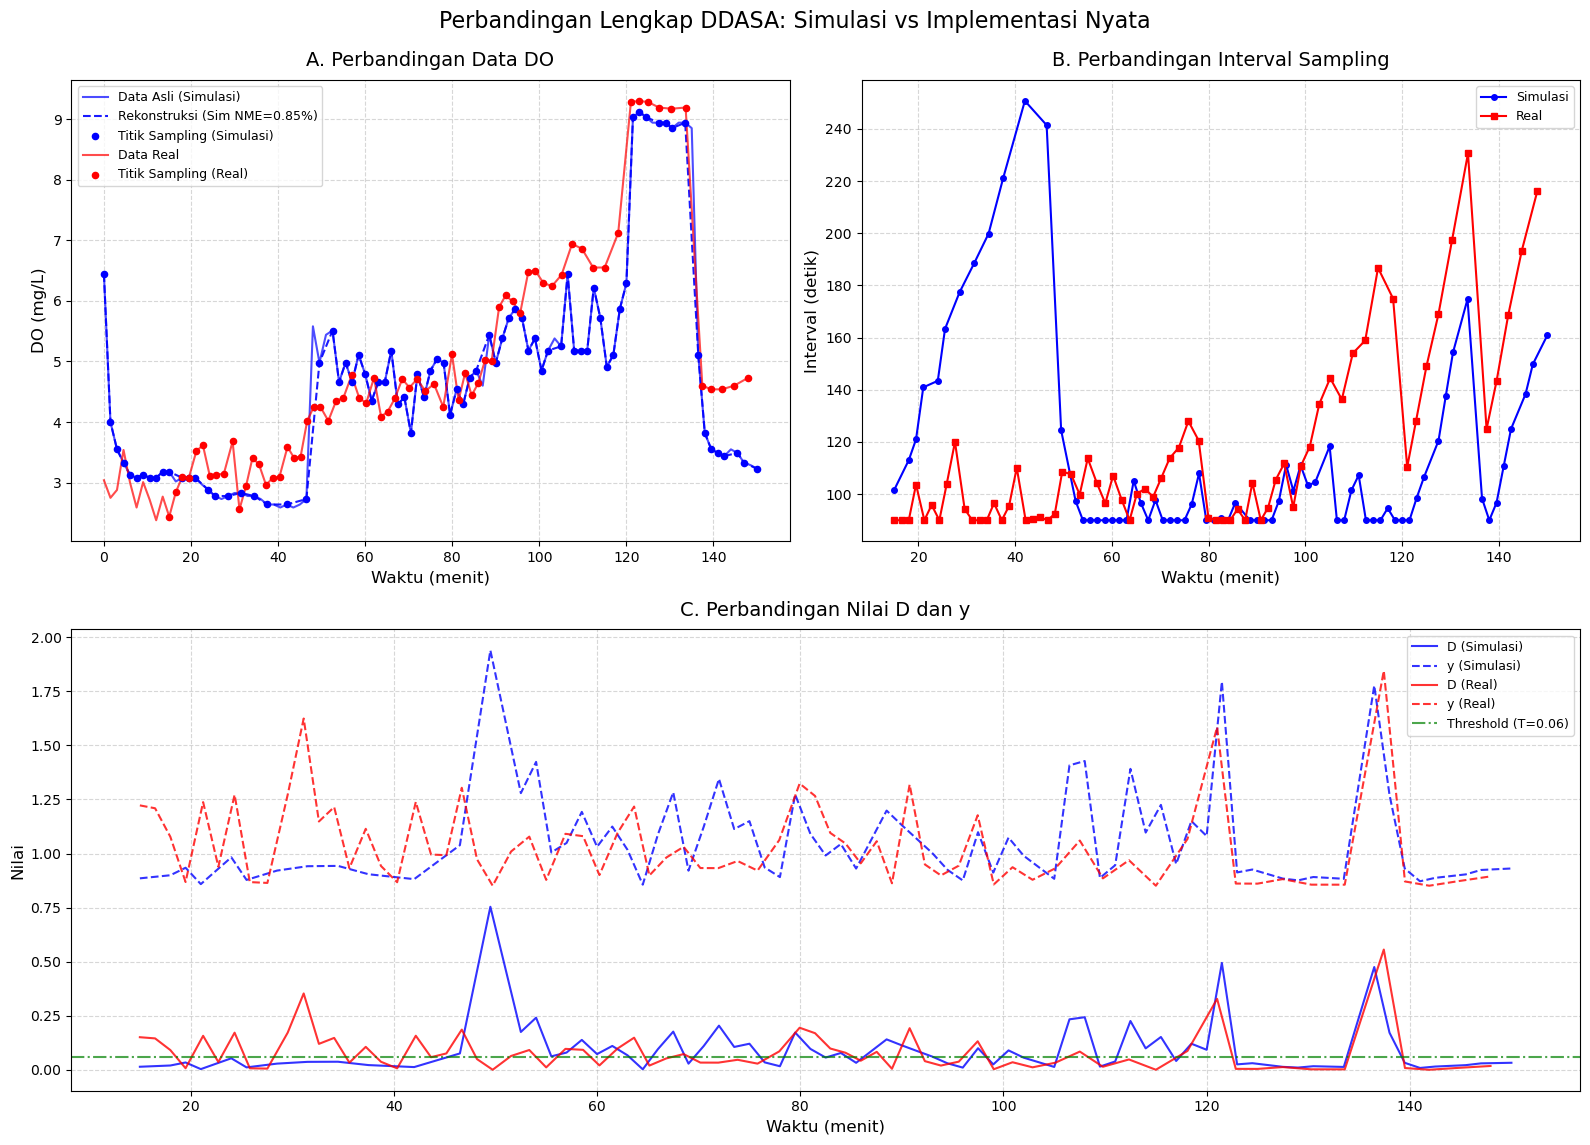


PERBANDINGAN KINERJA DDASA (DO)
+--------------------+------------+----------------------+
| Parameter          | Simulasi   | Implementasi Nyata   |
+====================+============+======================+
| Threshold (T)      | 0.06       | 0.06                 |
+--------------------+------------+----------------------+
| Jumlah Sampel      | 82         | 81                   |
+--------------------+------------+----------------------+
| NME (%)            | 0.85       | 10.35                |
+--------------------+------------+----------------------+
| Efisiensi Daya (%) | 0.00       | 0.00                 |
+--------------------+------------+----------------------+
| Daya Normal (mA·s) | 13698.1    | 13510.4              |
+--------------------+------------+----------------------+
| Daya DDASA (mA·s)  | 13698.1    | 13510.4              |
+--------------------+------------+----------------------+
| Penghematan Daya   | 0.0 mA·s   | 0.0 mA·s             |
+--------------------+-

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from datetime import datetime, timedelta, date
from tabulate import tabulate

def parse_real_data(file_content):
    real_data_all_DO = [] 
    real_all_times = []     
    real_ddasa_recorded_DO = []
    real_ddasa_times = []
    real_ddasa_D_values = []
    real_ddasa_y_values = []
    real_ddasa_intervals = []
    actual_sampling_indices_in_full_data = []

    lines = [line for line in file_content.split('\n') if '-> DO:' in line]
    if not lines:
        raise ValueError("Tidak ditemukan data yang sesuai format")
    
    start_time_obj = None
    rollover_days = 0
    prev_datetime_obj = None 
    
    for line_idx, line in enumerate(lines):
        try:
            time_part_full = line.split('->')[0].strip()
            if ']' in time_part_full: 
                time_part_cleaned = time_part_full.split(']', 1)[1].strip()
            else:
                time_part_cleaned = time_part_full 

            current_time_parsed = None
            try:
                current_time_parsed = datetime.strptime(time_part_cleaned, '%H:%M:%S.%f').time()
            except ValueError:
                current_time_parsed = datetime.strptime(time_part_cleaned, '%H:%M:%S').time()
            
            current_date_to_use = date(2000, 1, 1) + timedelta(days=rollover_days) 
            current_datetime = datetime.combine(current_date_to_use, current_time_parsed)
            
            if prev_datetime_obj:
                if current_time_parsed < prev_datetime_obj.time() and \
                   (prev_datetime_obj - datetime.combine(prev_datetime_obj.date(), current_time_parsed)).total_seconds() > 12 * 3600:
                    rollover_days += 1
                    current_date_to_use = date(2000, 1, 1) + timedelta(days=rollover_days)
                    current_datetime = datetime.combine(current_date_to_use, current_time_parsed)
            
            if start_time_obj is None:
                start_time_obj = current_datetime 
            
            delta_seconds = (current_datetime - start_time_obj).total_seconds()
            real_all_times.append(delta_seconds)
            prev_datetime_obj = current_datetime
            
            data_part_str = line.split('-> DO:')[1].strip()
            split_data_parts = data_part_str.split('|')
            
            DO = float(split_data_parts[0].strip())
            real_data_all_DO.append(DO)
            
            current_idx_in_all_DO = len(real_data_all_DO) - 1

            if len(split_data_parts) > 1: 
                actual_sampling_indices_in_full_data.append(current_idx_in_all_DO)
                real_ddasa_recorded_DO.append(DO) 
                real_ddasa_times.append(delta_seconds) 
                real_ddasa_D_values.append(float(split_data_parts[1].replace('D:', '').strip()))
                real_ddasa_y_values.append(float(split_data_parts[2].replace('y(D):', '').strip()))
                real_ddasa_intervals.append(float(split_data_parts[3].replace('Interval:', '').replace('ms', '').strip()))
                
        except Exception as e:
            print(f"Gagal parsing baris {line_idx + 1}: {line}\nError: {str(e)}")
            continue
            
    return {
        'DO': real_data_all_DO,    
        'times': real_all_times,            
        'ddasa_recorded_DO': real_ddasa_recorded_DO, 
        'ddasa_times': real_ddasa_times,                
        'ddasa_intervals': real_ddasa_intervals,
        'ddasa_D_values': real_ddasa_D_values,
        'ddasa_y_values': real_ddasa_y_values,
        'sampling_indices': actual_sampling_indices_in_full_data 
    }

def sigmoid(D, T):
    return 2.0 / (1 + exp(-5*(D - T)))

def calculate_D(new_DO, prev_DO, history):
    avg = np.mean(history) 
    if avg != 0: 
        D = abs(new_DO - prev_DO) / avg
    else:
        D = 0
    return D

def simulate_ddasa(data, T):
    intervals = []
    sampling_points = list(range(N))
    D_values = []  
    y_values = []  
    history = data[:N]
    prev_DO = history[-1]
    current_interval = initial_interval
    accumulated_time = 0
    time_step = 90000  
    sample_count = N
    total_operation_time = (len(data) - 1) * 90000  

    for i in range(N, len(data)):
        new_DO = data[i]
        accumulated_time += time_step
        
        if accumulated_time < current_interval:
            continue
        
        accumulated_time -= current_interval
        
        D = calculate_D(new_DO, prev_DO, history)
        y = sigmoid(D, T)
        
        D_values.append(D)
        y_values.append(y)
        sampling_points.append(i)
        sample_count += 1
        
        new_interval = current_interval / y
        new_interval = max(min_interval, min(max_interval, new_interval))
        intervals.append(new_interval)
        current_interval = new_interval
        
        history.pop(0)
        history.append(new_DO)
        prev_DO = new_DO
    
    return sample_count, intervals, sampling_points, D_values, y_values, total_operation_time

def calculate_nme(original, sampling_points, N):
    data_min, data_max = np.min(original), np.max(original)
    original_normalized = (original - data_min) / (data_max - data_min)
    
    reconstructed_normalized = np.interp(
        np.arange(len(original)), 
        sampling_points, 
        original_normalized[sampling_points]
    )
    
    error = np.abs(reconstructed_normalized[N:] - original_normalized[N:])
    nme = np.mean(error) * 100

    reconstructed = reconstructed_normalized * (data_max - data_min) + data_min
    
    return nme, reconstructed

def calculate_power_efficiency(
    total_time_ms,
    n_normal,        
    n_ddasa,          
    idle_current,
    active_current,
    t_active=1   
):
    total_time_sec = total_time_ms / 1000
    
    energy_normal = (idle_current * total_time_sec) + (active_current - idle_current) * n_normal * t_active
    energy_ddasa = (idle_current * total_time_sec) + (active_current - idle_current) * n_ddasa * t_active
    
    efficiency = (1 - energy_ddasa / energy_normal) * 100
    return efficiency, energy_normal, energy_ddasa


# Baca data real dari file
with open('Data_DDASA_DO.txt', 'r') as f:
    real_content = f.read()
real_results = parse_real_data(real_content)

# Baca data untuk simulasi
with open('Data_1s_DO.txt', 'r') as f:
    data = [float(line.strip().strip(',')) for line in f if line.strip()]

np.random.seed(42)
noise = np.random.normal(0, 0.05, len(data))
noisy_data = [x + noise[i] for i, x in enumerate(data)]

N = 10              
T = 0.06  # Nilai threshold spesifik untuk simulasi
initial_interval = 90000  # ms
min_interval = 90000      # ms
max_interval = 300000     # ms
idle_current = 1522        # µA 
active_current = 1523    # µA 
t_active = 1           # Durasi sampling aktif (detik)

# Jalankan simulasi
sim_sample_count, sim_intervals, sim_sampling_indices, sim_D_values, sim_y_values, total_time_ms = simulate_ddasa(noisy_data, T)
sim_nme, sim_reconstructed = calculate_nme(np.array(data), sim_sampling_indices, N)
n_normal_sim = len(data)
n_ddasa_sim = sim_sample_count
sim_efficiency, sim_power_normal, sim_power_ddasa = calculate_power_efficiency(
    total_time_ms=total_time_ms,
    n_normal=n_normal_sim,
    n_ddasa=n_ddasa_sim,
    idle_current=idle_current,
    active_current=active_current,
    t_active=t_active
)

total_time_real_sec = real_results['times'][-1] if real_results['times'] else 0

n_normal_real = int(total_time_real_sec/90) + 1

total_real_samples = len(real_results['DO'])

real_efficiency, real_power_normal, real_power_ddasa = calculate_power_efficiency(
    total_time_ms=total_time_real_sec * 1000,  # Konversi ke ms
    n_normal=n_normal_real,
    n_ddasa=total_real_samples,
    idle_current=idle_current,
    active_current=active_current,
    t_active=t_active
)

def calculate_direct_nme(ground_truth, recorded_DO, recorded_times, total_points):
    if not recorded_times or not ground_truth:
        return 0.0
    
    time_step = 90  # detik
    recorded_indices = [int(t / time_step) for t in recorded_times]
    
    recorded_indices = [idx for idx in recorded_indices if idx < len(ground_truth)]
    
    if not recorded_indices:
        return 0.0
    
    sampled_values = np.array(recorded_DO[:len(recorded_indices)])
    actual_values = np.array(ground_truth)[recorded_indices]
    
    data_min = min(ground_truth)
    data_max = max(ground_truth)
    
    if data_max == data_min:
        return 0.0
    
    actual_normalized = (actual_values - data_min) / (data_max - data_min)
    sampled_normalized = (sampled_values - data_min) / (data_max - data_min)
    
    error = np.abs(actual_normalized - sampled_normalized)
    nme = np.mean(error) * 100
    
    return nme

real_direct_nme = calculate_direct_nme(
    ground_truth=data,
    recorded_DO=real_results['ddasa_recorded_DO'],
    recorded_times=real_results['ddasa_times'],
    total_points=len(data)
)

plt.figure(figsize=(16, 12))
plt.suptitle('Perbandingan Lengkap DDASA: Simulasi vs Implementasi Nyata', fontsize=16, y=0.95)

# 1. Perbandingan data DO
ax1 = plt.subplot(2, 2, 1)
# Data simulasi
sim_time_min = np.arange(len(data)) * 1.5  
plt.plot(sim_time_min, data, 'b-', label='Data Asli (Simulasi)', alpha=0.7, linewidth=1.5)
plt.plot(sim_time_min, sim_reconstructed, 'b--', label=f'Rekonstruksi (Sim NME={sim_nme:.2f}%)', alpha=0.9, linewidth=1.5)

# Titik sampling simulasi
plt.scatter(
    np.array(sim_sampling_indices) * 1.5 ,
    np.array(data)[sim_sampling_indices], 
    color='blue', s=20, label='Titik Sampling (Simulasi)', zorder=3
)

# Data real
real_time_min = np.array(real_results['times']) / 60  
plt.plot(real_time_min, real_results['DO'], 'r-', label='Data Real', alpha=0.7, linewidth=1.5)

plt.scatter(
    np.array(real_results['ddasa_times']) / 60, 
    real_results['ddasa_recorded_DO'], 
    color='red', s=20, label='Titik Sampling (Real)', zorder=3
)

plt.title('A. Perbandingan Data DO', pad=10, fontsize=14)
plt.xlabel('Waktu (menit)', fontsize=12)
plt.ylabel('DO (mg/L)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9, loc='best')

# 2. Perbandingan interval sampling
ax2 = plt.subplot(2, 2, 2)
sim_adaptive_times = np.array(sim_sampling_indices[N:]) * 1.5 
plt.plot(sim_adaptive_times, np.array(sim_intervals)/1000, 'b-', marker='o', markersize=4, 
         label='Simulasi')

plt.plot(np.array(real_results['ddasa_times']) / 60, np.array(real_results['ddasa_intervals'])/1000, 
         'r-', marker='s', markersize=4, label='Real')

plt.title('B. Perbandingan Interval Sampling', pad=10, fontsize=14)
plt.xlabel('Waktu (menit)', fontsize=12)
plt.ylabel('Interval (detik)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9)

# 3. Perbandingan nilai D dan y
ax3 = plt.subplot(2, 1, 2)
# Simulasi: D dan y
plt.plot(sim_adaptive_times, sim_D_values, 'b-', label='D (Simulasi)', alpha=0.8, linewidth=1.5)
plt.plot(sim_adaptive_times, sim_y_values, 'b--', label='y (Simulasi)', alpha=0.8, linewidth=1.5)

real_ddasa_time_min = np.array(real_results['ddasa_times']) / 60
plt.plot(real_ddasa_time_min, real_results['ddasa_D_values'], 'r-', label='D (Real)', alpha=0.8, linewidth=1.5)
plt.plot(real_ddasa_time_min, real_results['ddasa_y_values'], 'r--', label='y (Real)', alpha=0.8, linewidth=1.5)

plt.axhline(y=T, color='g', linestyle='-.', label=f'Threshold (T={T})', linewidth=1.5, alpha=0.7)
plt.title('C. Perbandingan Nilai D dan y', pad=10, fontsize=14)
plt.xlabel('Waktu (menit)', fontsize=12)
plt.ylabel('Nilai', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9, loc='best')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('perbandingan_komprehensif.png', dpi=300, bbox_inches='tight')
plt.show()

summary_data = [
    ["Parameter", "Simulasi", "Implementasi Nyata"],
    ["Threshold (T)", f"{T}", f"{T}"],
    ["Jumlah Sampel", f"{sim_sample_count}", f"{total_real_samples}"],
    ["NME (%)", f"{sim_nme:.2f}", f"{real_direct_nme:.2f}"],
    ["Efisiensi Daya (%)", f"{sim_efficiency:.2f}", f"{real_efficiency:.2f}"],
    ["Daya Normal (mA·s)", f"{sim_power_normal/1000:.1f}", f"{real_power_normal/1000:.1f}"],
    ["Daya DDASA (mA·s)", f"{sim_power_ddasa/1000:.1f}", f"{real_power_ddasa/1000:.1f}"],
    ["Penghematan Daya", f"{(sim_power_normal - sim_power_ddasa)/1000:.1f} mA·s", 
     f"{(real_power_normal - real_power_ddasa)/1000:.1f} mA·s"]
]

print("\nPERBANDINGAN KINERJA DDASA (DO)")
print(tabulate(summary_data, headers="firstrow", tablefmt="grid"))

Sensor Turbidity

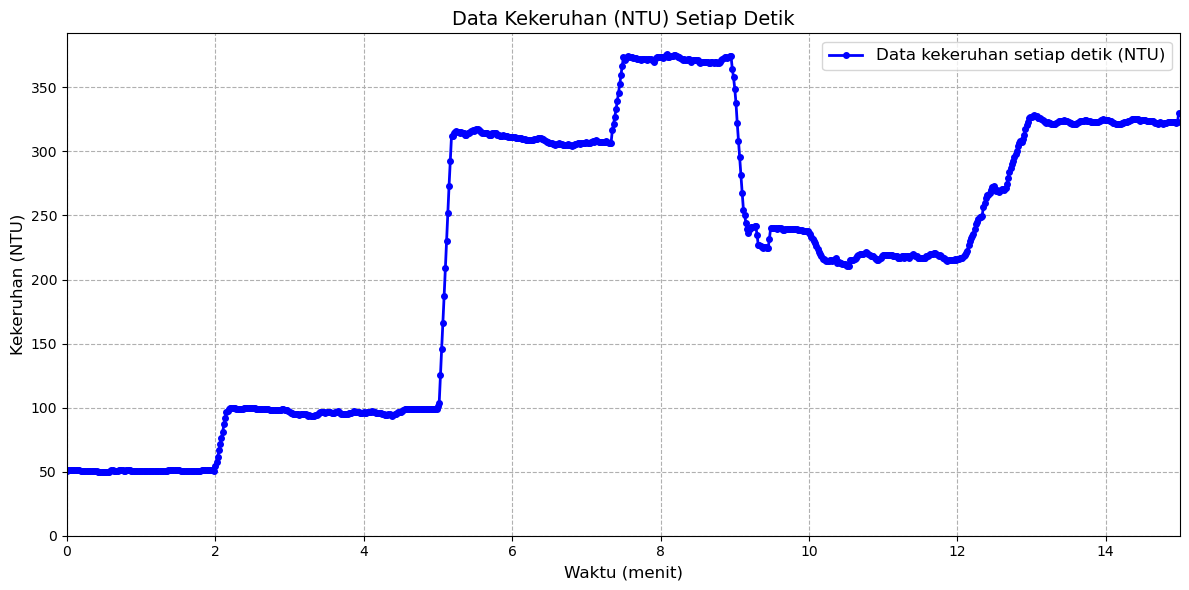

In [10]:
import numpy as np
import matplotlib.pyplot as plt

with open('Data_1s_Turb_new.txt', 'r') as f:
    data = [float(line.strip().strip(',')) for line in f if line.strip()]

time_axis = np.arange(len(data)) / 60 

plt.figure(figsize=(12, 6))
plt.plot(time_axis, data, 'b-o', markersize=4, linewidth=2, label='Data kekeruhan setiap detik (NTU)')

plt.xlabel('Waktu (menit)', fontsize=12)
plt.ylabel('Kekeruhan (NTU)', fontsize=12)
plt.title('Data Kekeruhan (NTU) Setiap Detik', fontsize=14)
plt.grid(True, linestyle='--', alpha=1)
plt.legend(fontsize=12)

plt.xlim(0, 15)
plt.ylim(0, )

plt.tight_layout()
plt.show()

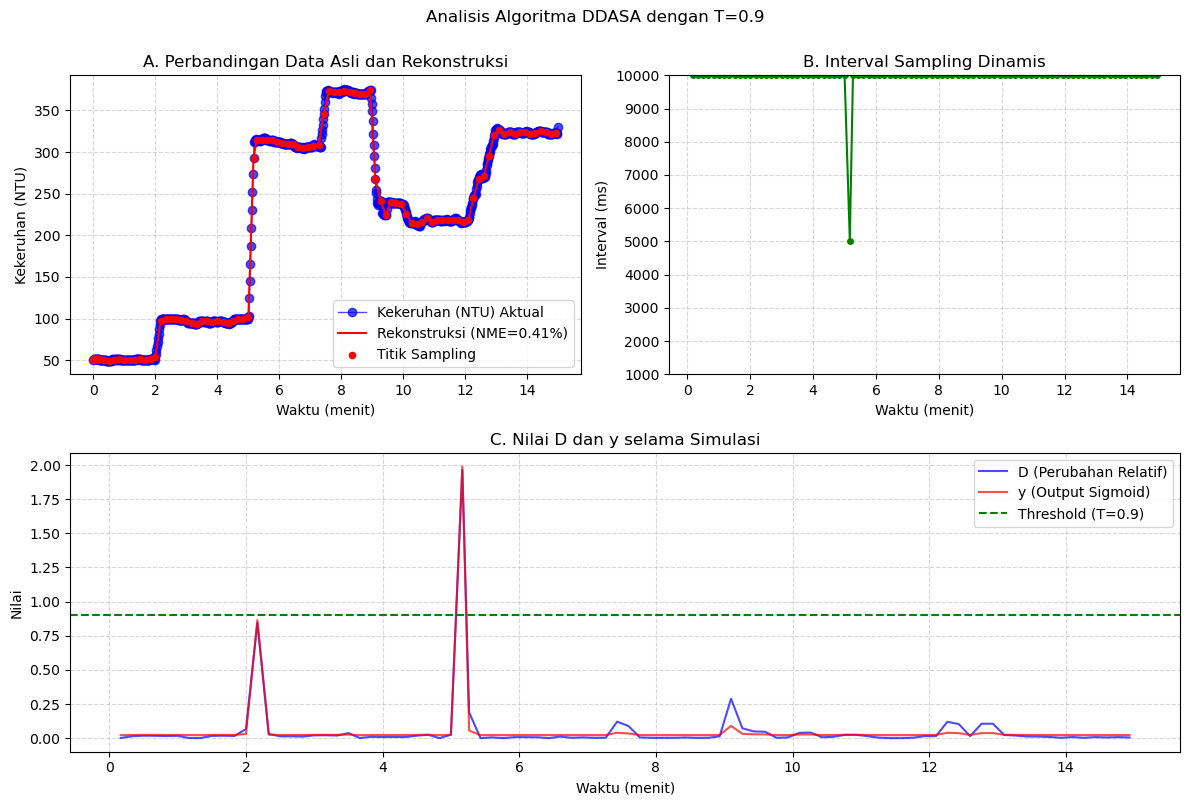

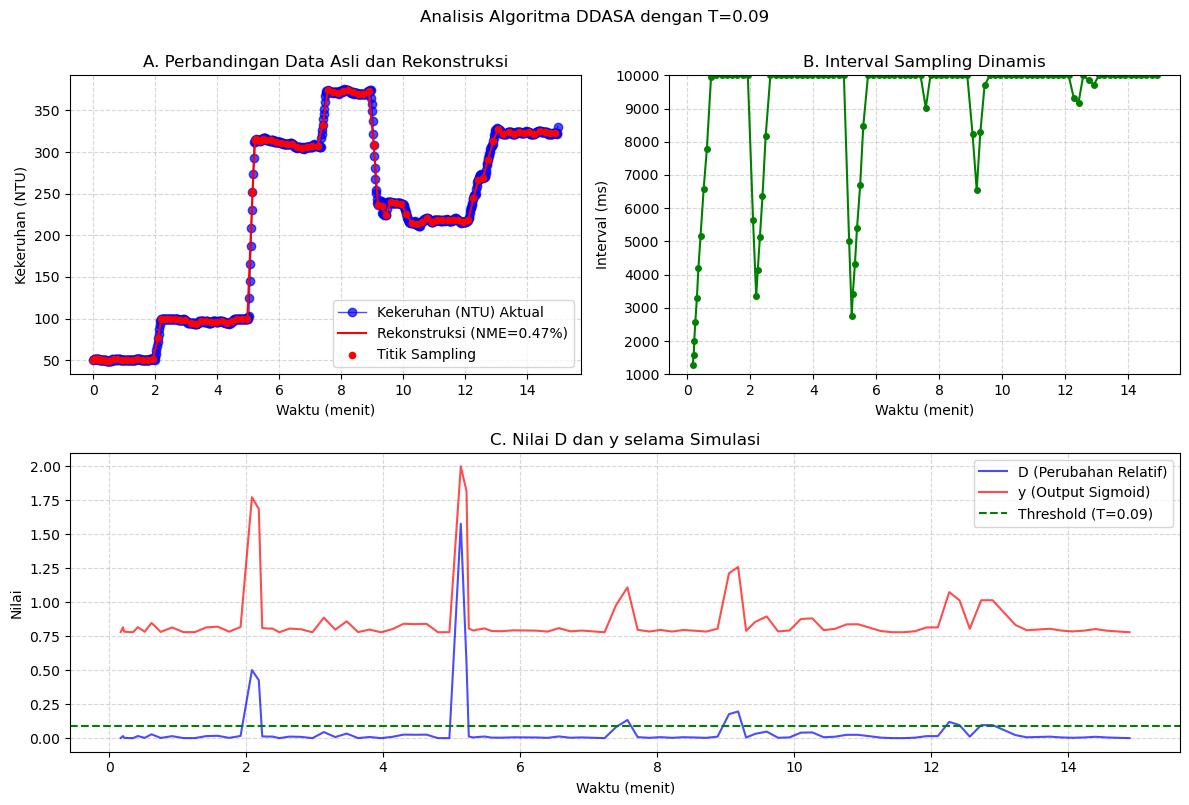

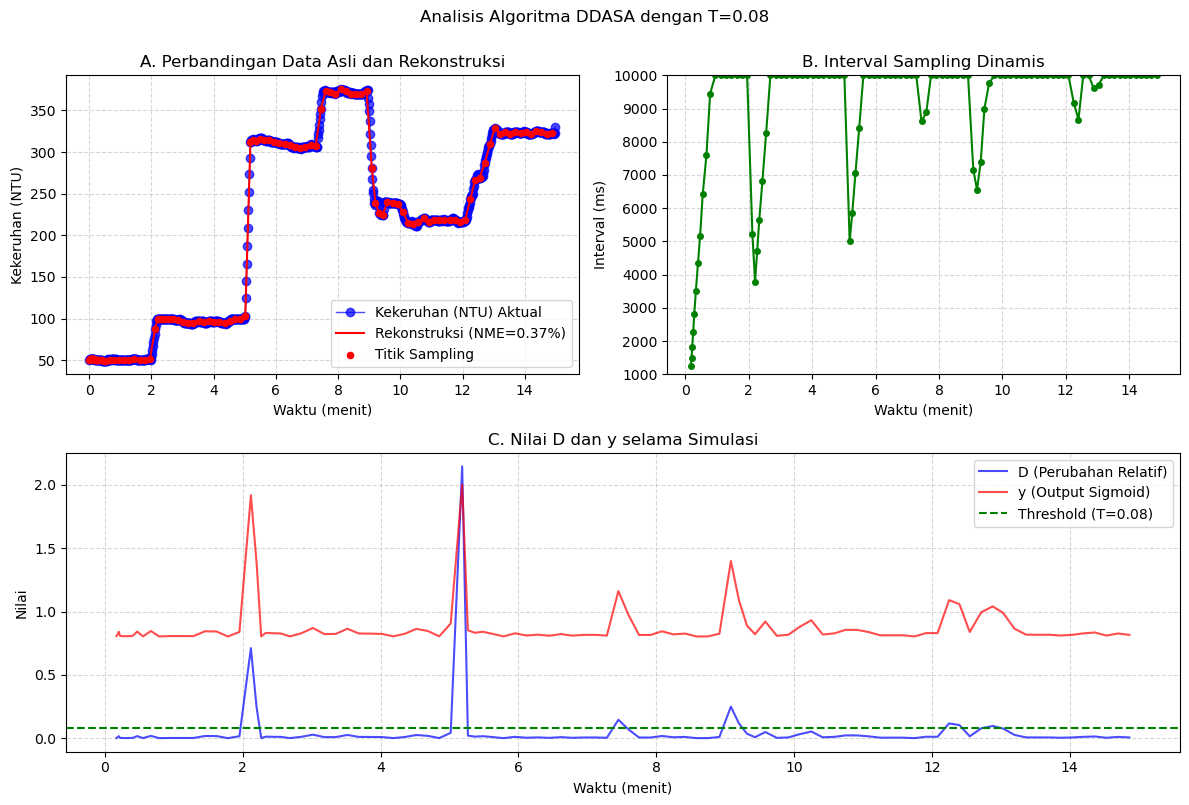

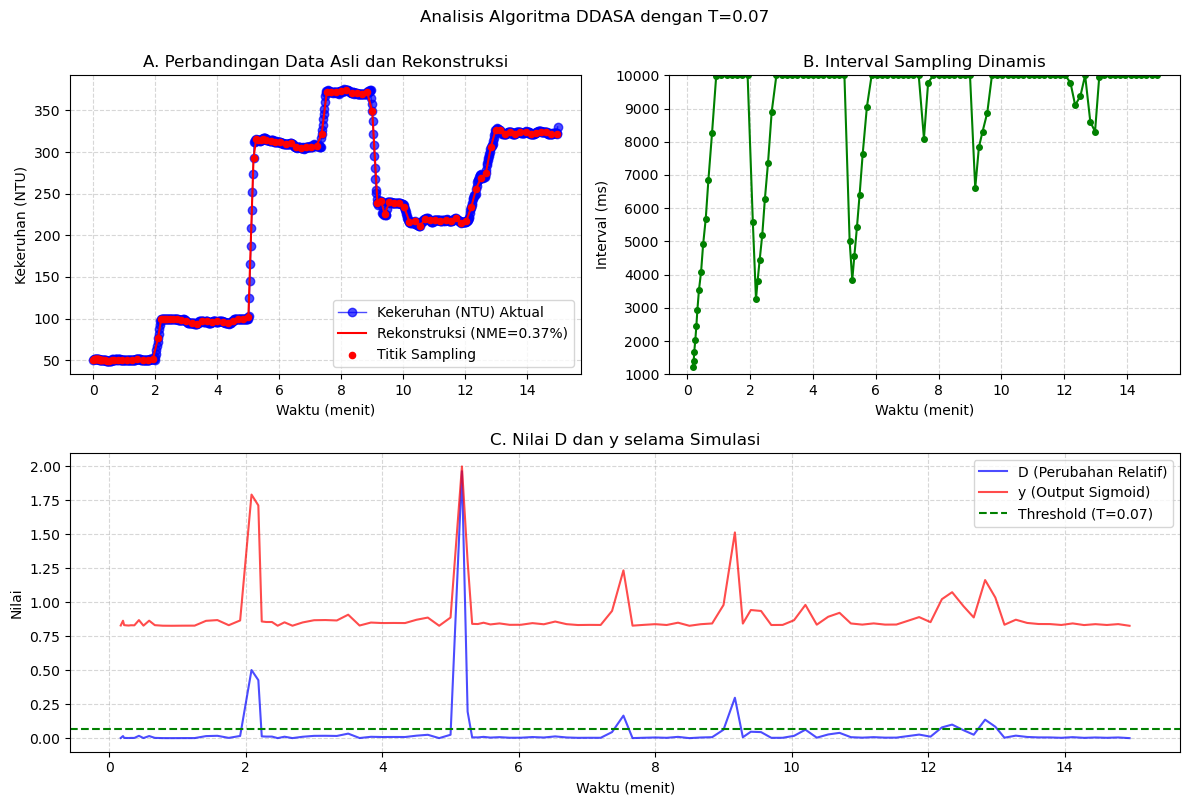

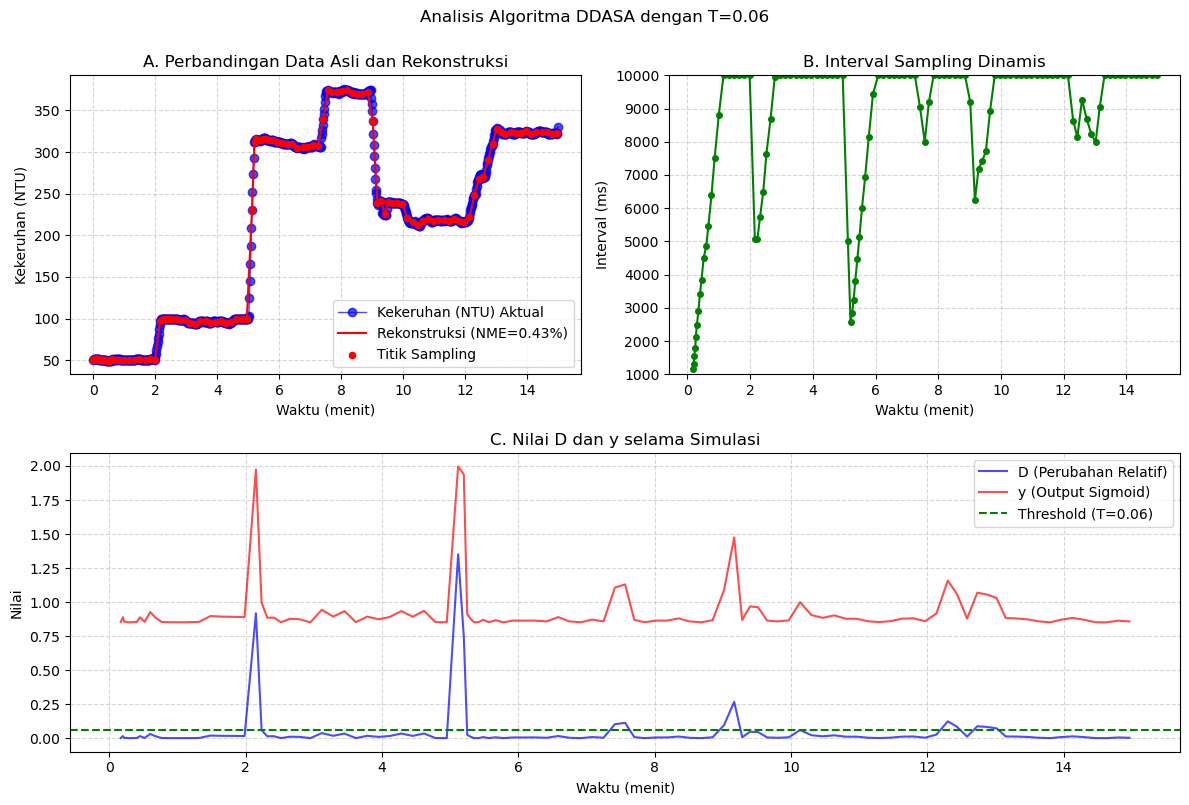

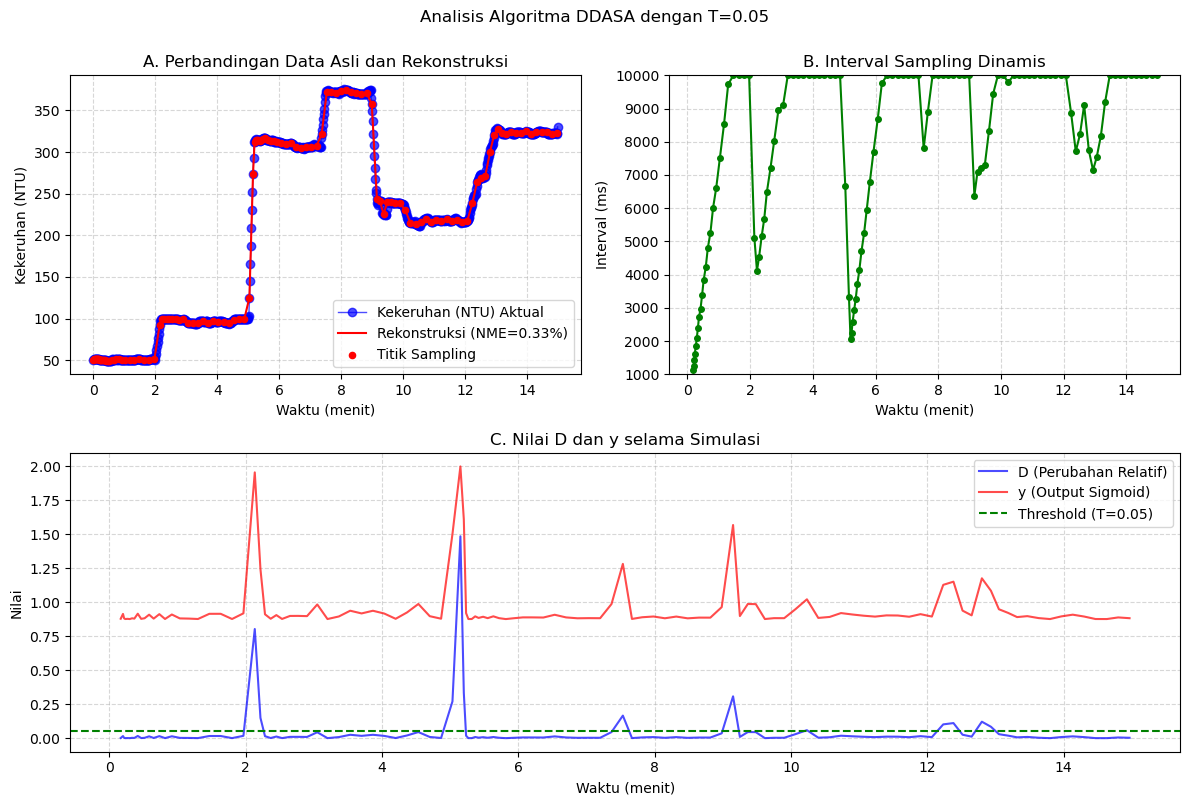

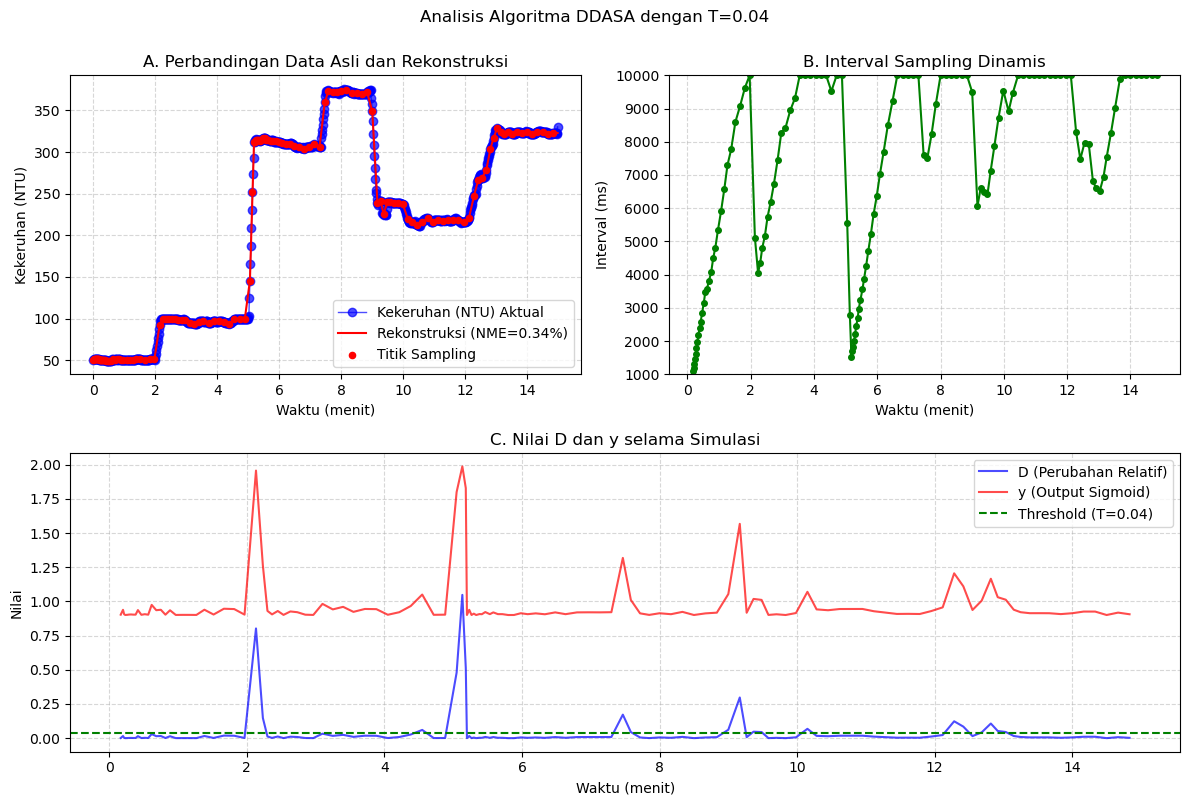

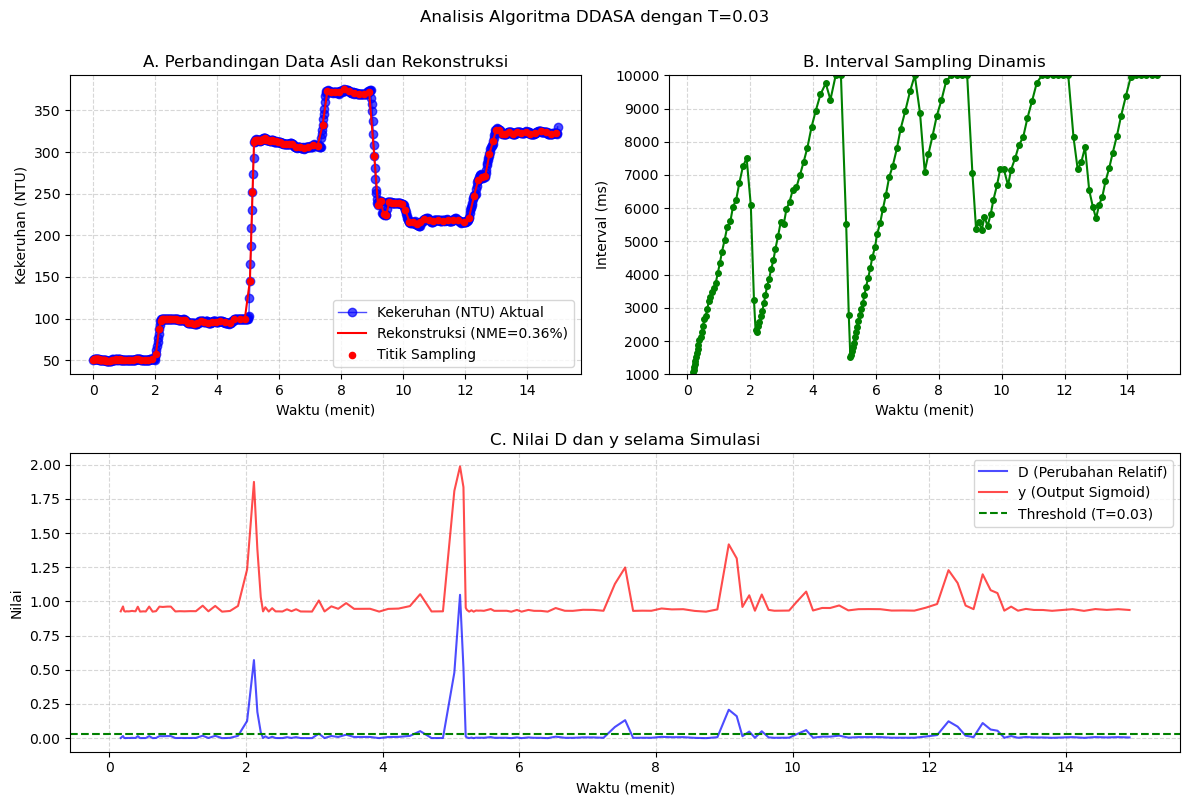

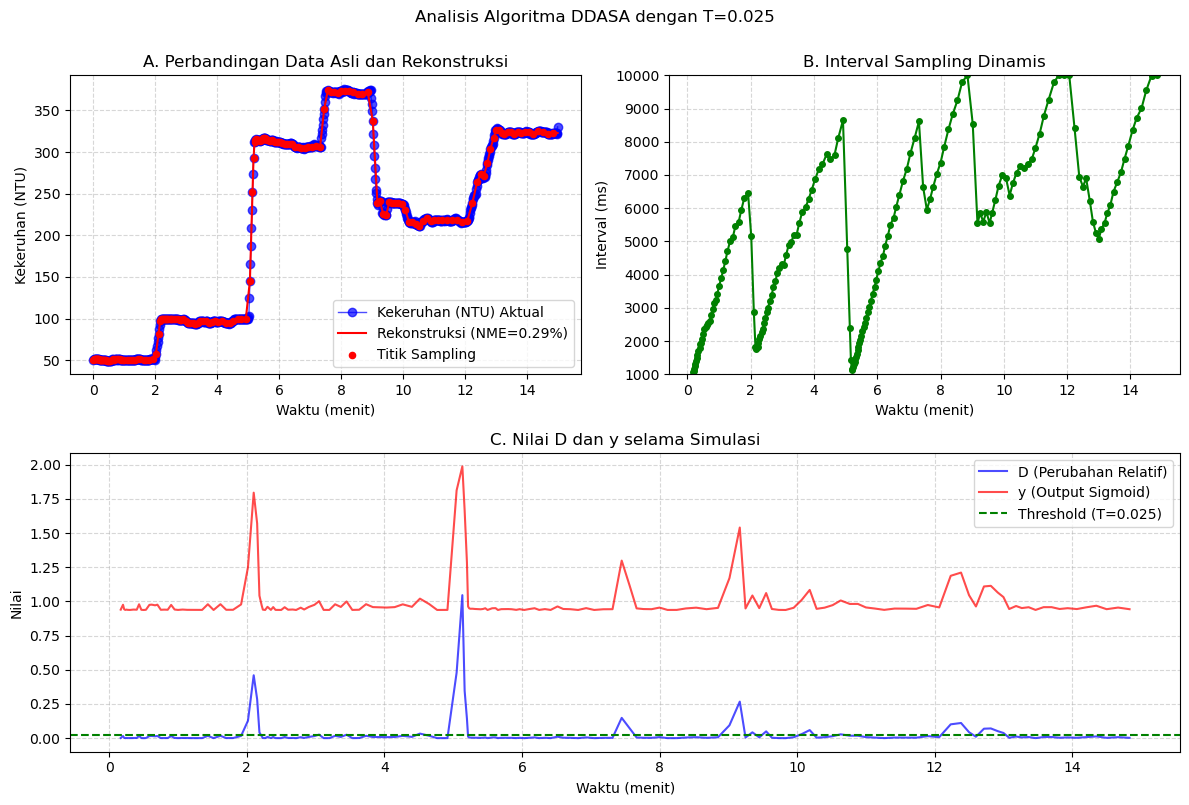

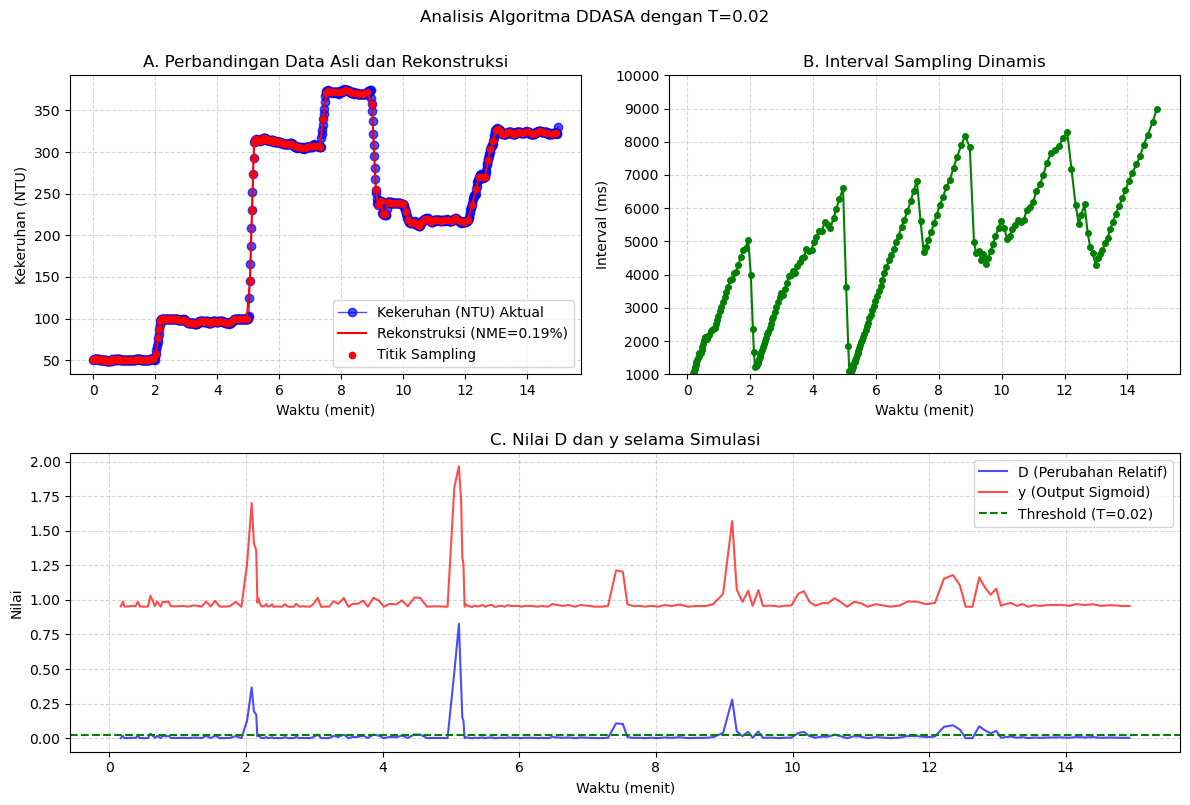

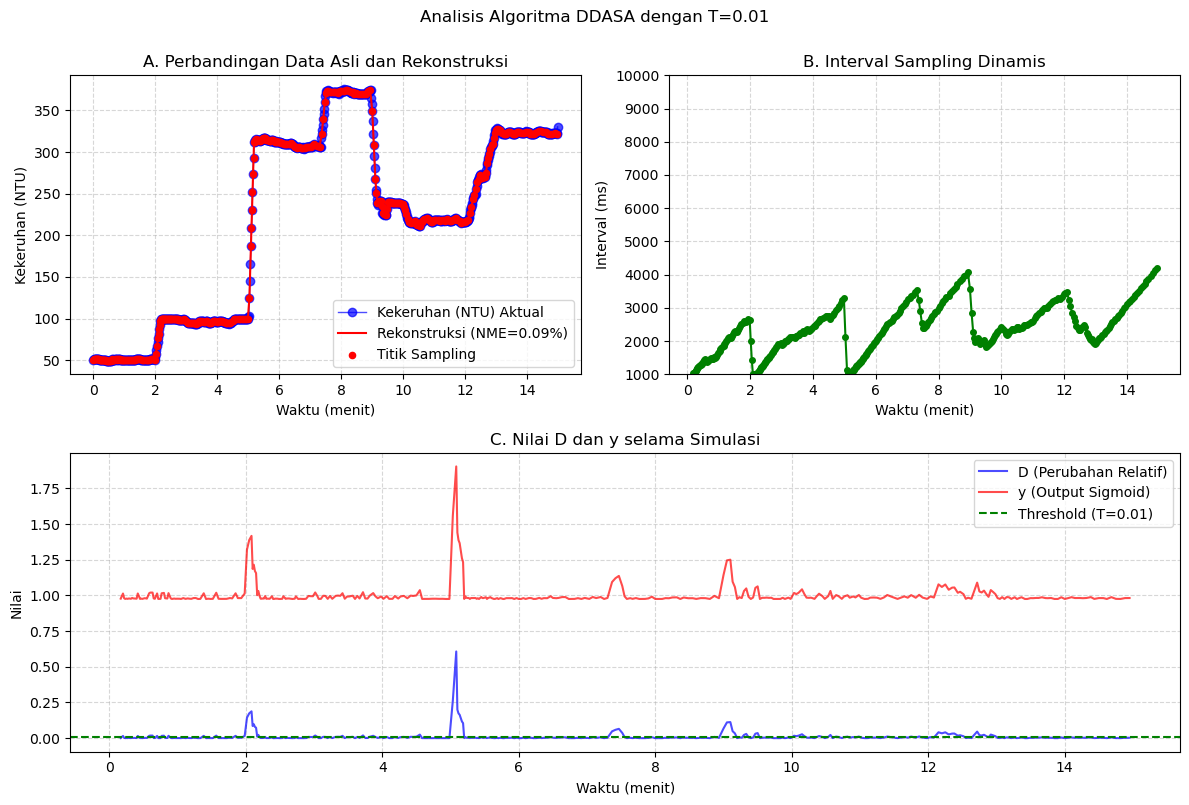

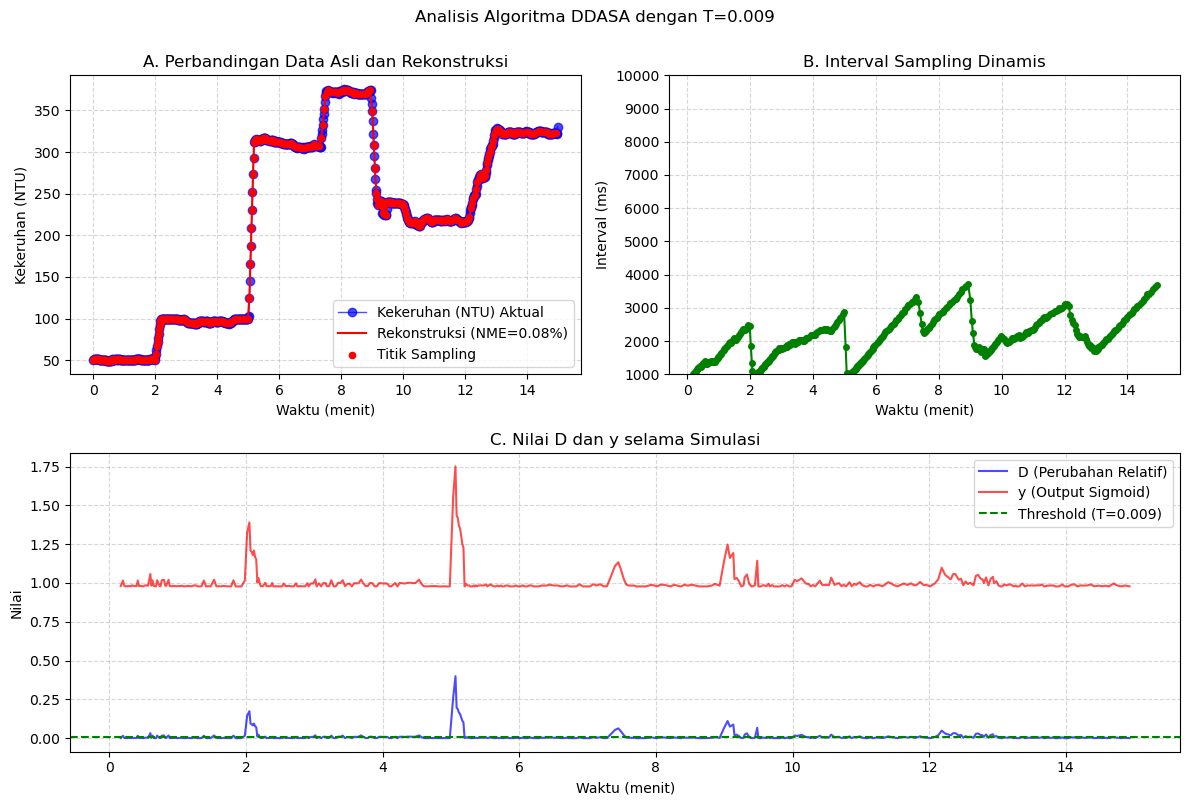

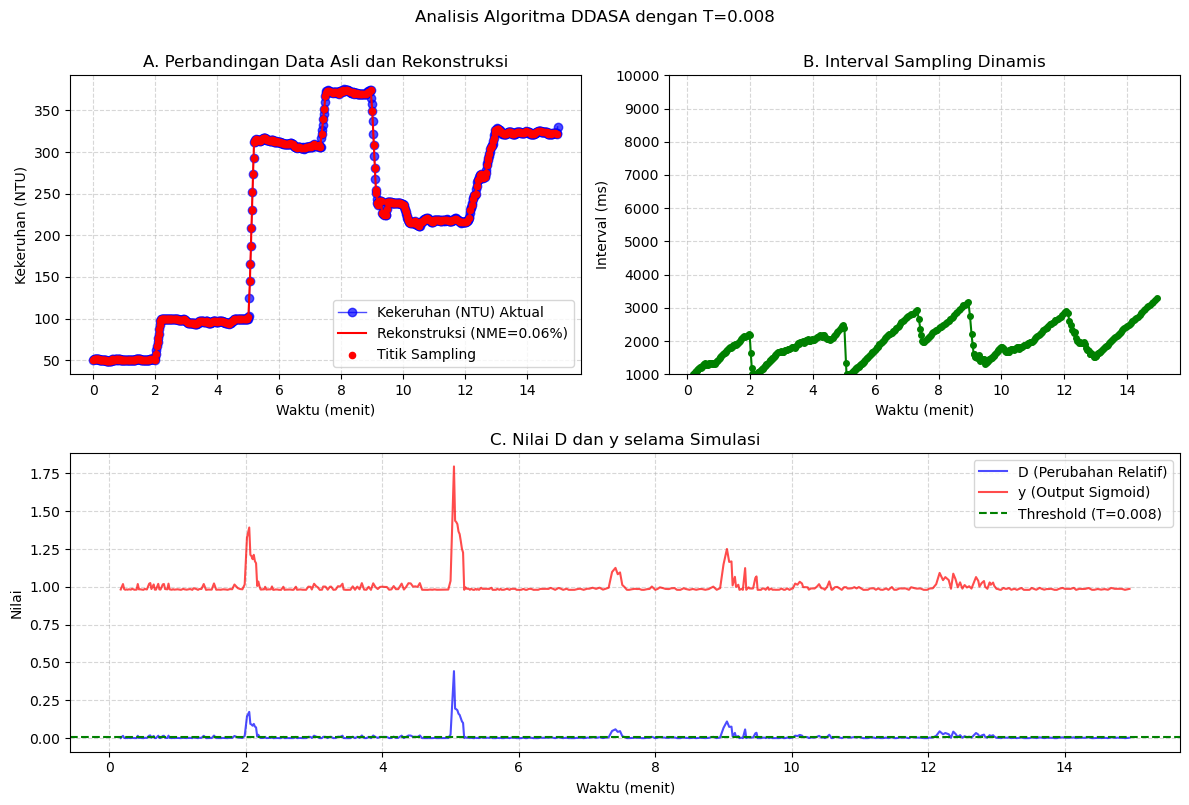


Ringkasan Hasil untuk Semua Nilai T:
T	Samples	NME(%)	Efisiensi(%)	Daya Normal(µA)		Daya DDASA(µA) 
----------------------------------------------------------------------------------------------------
0.9	100	0.41	0.06		9,428,270			9,422,270
0.09	112	0.47	0.06		9,428,270			9,422,360
0.08	111	0.37	0.06		9,428,270			9,422,352
0.07	115	0.37	0.06		9,428,270			9,422,382
0.06	119	0.43	0.06		9,428,270			9,422,412
0.05	126	0.33	0.06		9,428,270			9,422,465
0.04	137	0.34	0.06		9,428,270			9,422,548
0.03	162	0.36	0.06		9,428,270			9,422,735
0.025	187	0.29	0.06		9,428,270			9,422,922
0.02	231	0.19	0.05		9,428,270			9,423,252
0.01	410	0.09	0.04		9,428,270			9,424,595
0.009	445	0.08	0.04		9,428,270			9,424,858
0.008	487	0.06	0.03		9,428,270			9,425,172


In [11]:
from math import exp
import numpy as np
import matplotlib.pyplot as plt

with open('Data_1s_Turb_new.txt', 'r') as f:
    data = [float(line.strip().strip(',')) for line in f if line.strip()]

np.random.seed(42)
noise = np.random.normal(0, 0.05, len(data))
noisy_data = [x + noise[i] for i, x in enumerate(data)]

N = 10                  
T_values = [0.9, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.025, 0.02, 0.01, 0.009, 0.008]               
initial_interval = 1000  # ms
min_interval = 1000      # ms
max_interval = 10000     # ms
idle_current = 10480      # µA 
active_current = 10490    # µA 
delta_current = active_current - idle_current  

def sigmoid(D, T):
    return 2.0 / (1 + exp(-5*(D - T)))

def calculate_D(new_turb, prev_turb, history):
    avg = np.mean(history) 
    if avg != 0: 
        D = abs(new_turb - prev_turb) / avg
    else:
        D = 0
    return D

def simulate_ddasa(data, T):
    intervals = []
    sampling_points = list(range(N))
    D_values = []  
    y_values = []  
    history = data[:N]
    prev_turb = history[-1]
    current_interval = initial_interval
    accumulated_time = 0
    time_step = 1000  
    sample_count = N
    total_operation_time = (len(data) - 1) * 1000  

    for i in range(N, len(data)):
        new_turb = data[i]
        accumulated_time += time_step
        
        if accumulated_time < current_interval:
            continue
        
        accumulated_time -= current_interval
        
        D = calculate_D(new_turb, prev_turb, history)
        y = sigmoid(D, T)
        
        D_values.append(D)
        y_values.append(y)
        sampling_points.append(i)
        sample_count += 1
        
        new_interval = current_interval / y
        new_interval = max(min_interval, min(max_interval, new_interval))
        intervals.append(new_interval)
        current_interval = new_interval
        
        history.pop(0)
        history.append(new_turb)
        prev_turb = new_turb
    
    return sample_count, intervals, sampling_points, D_values, y_values, total_operation_time

def calculate_nme(original, sampling_points, N):
    data_min, data_max = np.min(original), np.max(original)
    original_normalized = (original - data_min) / (data_max - data_min)
    
    reconstructed_normalized = np.interp(
        np.arange(len(original)), 
        sampling_points, 
        original_normalized[sampling_points]
    )
    
    error = np.abs(reconstructed_normalized[N:] - original_normalized[N:])
    nme = np.mean(error) * 100

    reconstructed = reconstructed_normalized * (data_max - data_min) + data_min
    
    return nme, reconstructed

def calculate_power_efficiency(
    total_time_ms,
    n_normal,          
    n_ddasa,           
    idle_current,
    active_current,
    t_active=1      
):
    total_time_sec = total_time_ms / 1000
   
    energy_normal = (idle_current * total_time_sec) + (active_current - idle_current) * n_normal * t_active
    energy_ddasa = (idle_current * total_time_sec) + (active_current - idle_current) * n_ddasa * t_active
    
    efficiency = (1 - energy_ddasa / energy_normal) * 100
    return efficiency, energy_normal, energy_ddasa

results = {}

for T in T_values:
    sample_count, intervals, sampling_points, D_values, y_values, total_time_ms = simulate_ddasa(noisy_data, T)
    nme, reconstructed = calculate_nme(np.array(data), sampling_points, N)
    n_normal = len(data)
    n_ddasa = sample_count
    efficiency, power_normal, power_ddasa = calculate_power_efficiency(
        total_time_ms = total_time_ms,
        n_normal = n_normal,
        n_ddasa = n_ddasa, 
        idle_current = idle_current, 
        active_current = active_current,
        t_active = 0.75
    )
    
    results[T] = {
        'sample_count': sample_count,
        'intervals': intervals,
        'sampling_points': sampling_points,
        'D_values': D_values,
        'y_values': y_values,
        'nme': nme,
        'reconstructed': reconstructed,
        'efficiency': efficiency,
        'power_normal': power_normal,
        'power_ddasa': power_ddasa
    }

for T in T_values:
    res = results[T]
    time_axis = np.arange(len(data)) / 60  
    sampling_time_axis = np.array(res['sampling_points'])/60
    
    # Buat figure untuk setiap nilai T
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Analisis Algoritma DDASA dengan T={T}', y=1, fontsize=12)
    
    # Grafik 1 (kiri atas): Perbandingan data asli dan rekonstruksi
    plt.subplot(2, 2, 1)
    plt.plot(time_axis, data, 'b-o', label='Kekeruhan (NTU) Aktual', alpha=0.7, linewidth=1)
    plt.plot(time_axis, res['reconstructed'], 'r-', label=f'Rekonstruksi (NME={res["nme"]:.2f}%)', linewidth=1.5)
    plt.scatter(
        sampling_time_axis,
        np.array(data)[res['sampling_points']], 
        color='red', s=20, label='Titik Sampling', zorder=3
    )
    plt.title('A. Perbandingan Data Asli dan Rekonstruksi')
    plt.xlabel('Waktu (menit)')
    plt.ylabel('Kekeruhan (NTU)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    # Grafik 2 (kanan atas): Interval sampling
    plt.subplot(2, 2, 2)
    if res['intervals']:  
        adaptive_sampling_time = np.array(res['sampling_points'][N:]) / 60
        plt.plot(adaptive_sampling_time, res['intervals'], 'g-', marker='o', markersize=4)
    plt.title('B. Interval Sampling Dinamis')
    plt.xlabel('Waktu (menit)')
    plt.ylabel('Interval (ms)')
    plt.ylim(min_interval, 10000)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Grafik 3 (kiri bawah): Nilai D dan y
    plt.subplot(2, 1, 2)
    if res['D_values']:  
        adaptive_time_axis = np.array(res['sampling_points'][N:]) / 60
        plt.plot(adaptive_time_axis, res['D_values'], 'b-', label='D (Perubahan Relatif)', alpha=0.7)
        plt.plot(adaptive_time_axis, res['y_values'], 'r-', label='y (Output Sigmoid)', alpha=0.7)
    plt.axhline(y=T, color='g', linestyle='--', label=f'Threshold (T={T})')
    plt.title('C. Nilai D dan y selama Simulasi')
    plt.xlabel('Waktu (menit)')
    plt.ylabel('Nilai')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Tampilkan tabel ringkasan
print("\nRingkasan Hasil untuk Semua Nilai T:")
print("="*100)
print("T\tSamples\tNME(%)\tEfisiensi(%)\tDaya Normal(µA)\t\tDaya DDASA(µA) ")
print("-"*100)
for T in T_values:
    res = results[T]
    print(f"{T}\t{res['sample_count']}\t{res['nme']:.2f}\t{res['efficiency']:.2f}\t\t{res['power_normal']:,.0f}\t\t\t{res['power_ddasa']:,.0f}")
print("="*100)

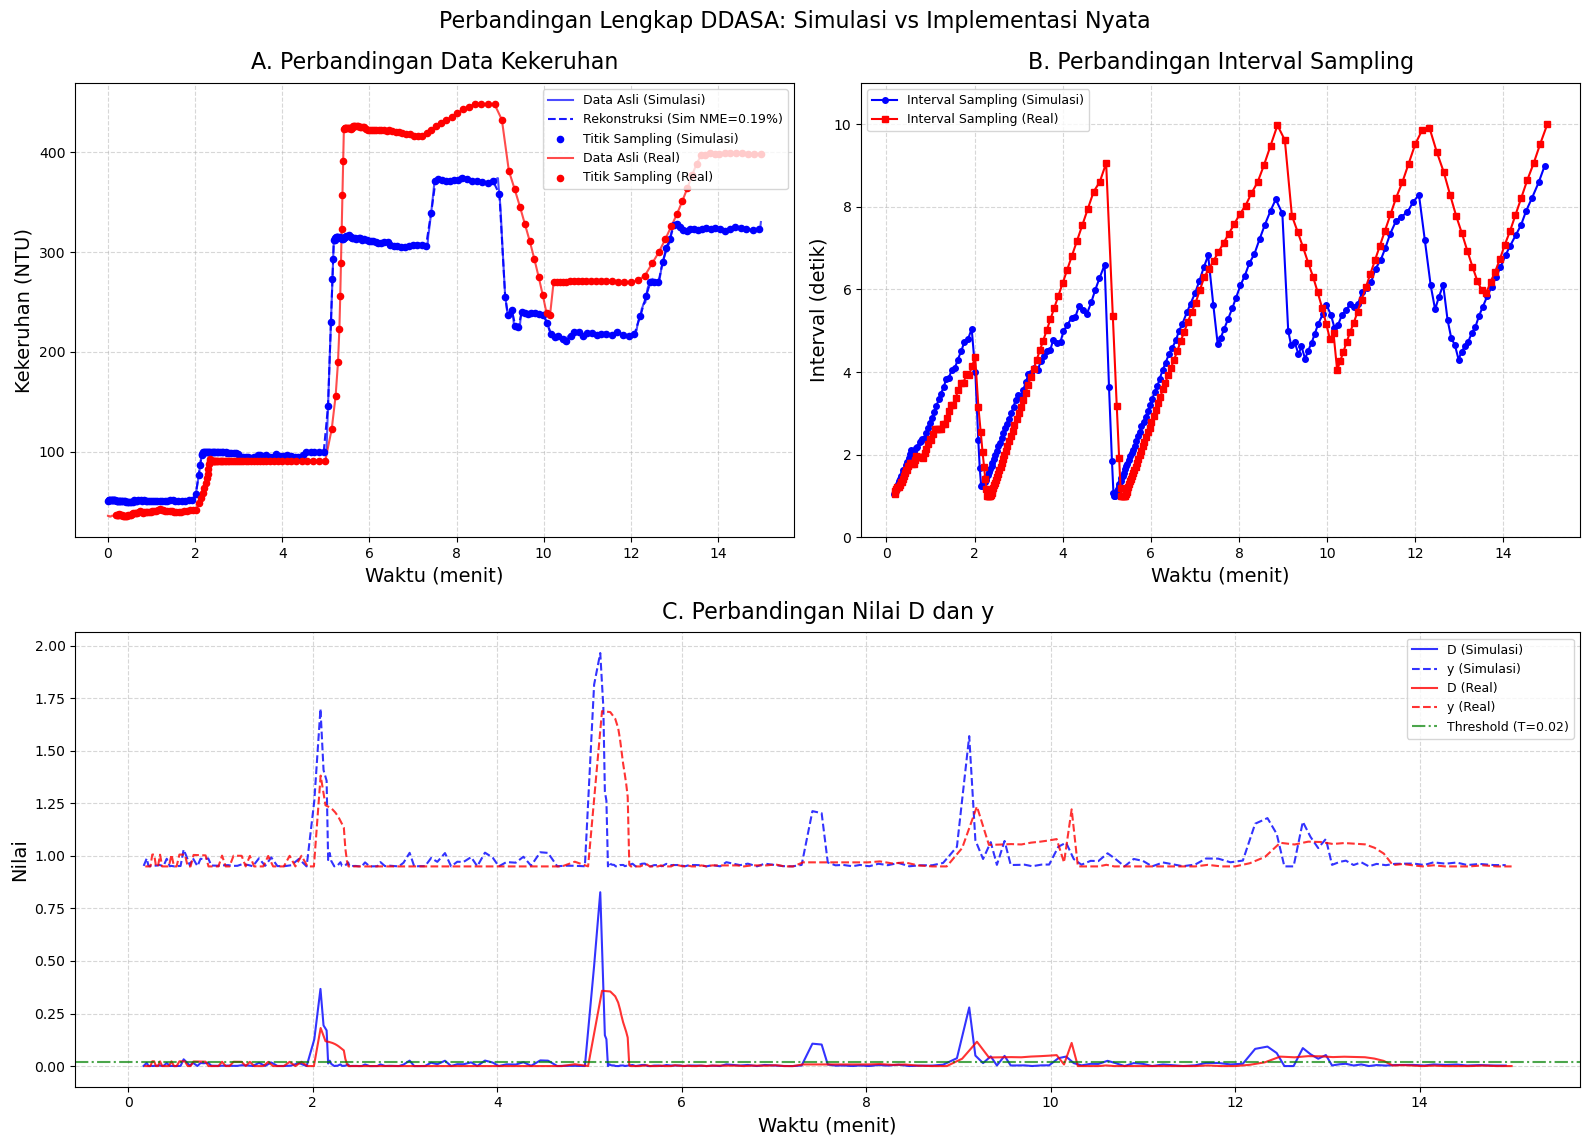


PERBANDINGAN KINERJA DDASA KEKERUHAN (T=0.02)
+--------------------+------------+----------------------+
|       Metric       |  Simulasi  |  Implementasi Nyata  |
+====================+============+======================+
|   Jumlah Sampel    |    231     |         228          |
+--------------------+------------+----------------------+
|      NME (%)       |   0.19%    |        11.67%        |
+--------------------+------------+----------------------+
|   Efisiensi (%)    |   0.05%    |        0.05%         |
+--------------------+------------+----------------------+
| Daya Normal (mA·s) |   9428.3   |        9436.7        |
+--------------------+------------+----------------------+
| Daya DDASA (mA·s)  |   9423.3   |        9431.7        |
+--------------------+------------+----------------------+


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from datetime import datetime, timedelta, date
from tabulate import tabulate

def parse_real_data(file_content):
    real_data_all_turb = [] 
    real_all_times = []      
    real_ddasa_recorded_turb = []
    real_ddasa_times = []
    real_ddasa_D_values = []
    real_ddasa_y_values = []
    real_ddasa_intervals = []
    actual_sampling_indices_in_full_data = []

    lines = [line for line in file_content.split('\n') if '-> NTU:' in line]
    if not lines:
        raise ValueError("Tidak ditemukan data yang sesuai format")
    
    start_time_obj = None
    rollover_days = 0
    prev_datetime_obj = None 
    
    for line_idx, line in enumerate(lines):
        try:
            time_part_full = line.split('->')[0].strip()
            if ']' in time_part_full: 
                time_part_cleaned = time_part_full.split(']', 1)[1].strip()
            else:
                time_part_cleaned = time_part_full 

            current_time_parsed = None
            try:
                current_time_parsed = datetime.strptime(time_part_cleaned, '%H:%M:%S.%f').time()
            except ValueError:
                current_time_parsed = datetime.strptime(time_part_cleaned, '%H:%M:%S').time()
            
            current_date_to_use = date(2000, 1, 1) + timedelta(days=rollover_days) 
            current_datetime = datetime.combine(current_date_to_use, current_time_parsed)
            
            if prev_datetime_obj:
                if current_time_parsed < prev_datetime_obj.time() and \
                   (prev_datetime_obj - datetime.combine(prev_datetime_obj.date(), current_time_parsed)).total_seconds() > 12 * 3600:
                    rollover_days += 1
                    current_date_to_use = date(2000, 1, 1) + timedelta(days=rollover_days)
                    current_datetime = datetime.combine(current_date_to_use, current_time_parsed)
            
            if start_time_obj is None:
                start_time_obj = current_datetime 
            
            delta_seconds = (current_datetime - start_time_obj).total_seconds()
            real_all_times.append(delta_seconds)
            prev_datetime_obj = current_datetime
            
            data_part_str = line.split('-> NTU:')[1].strip()
            split_data_parts = data_part_str.split('|')
            
            turb = float(split_data_parts[0].strip())
            real_data_all_turb.append(turb)
            
            current_idx_in_all_turb = len(real_data_all_turb) - 1

            if len(split_data_parts) > 1: 
                actual_sampling_indices_in_full_data.append(current_idx_in_all_turb)
                real_ddasa_recorded_turb.append(turb) 
                real_ddasa_times.append(delta_seconds) 
                real_ddasa_D_values.append(float(split_data_parts[1].replace('D:', '').strip()))
                real_ddasa_y_values.append(float(split_data_parts[2].replace('y(D):', '').strip()))
                real_ddasa_intervals.append(float(split_data_parts[3].replace('Interval:', '').replace('ms', '').strip()))
                
        except Exception as e:
            print(f"Gagal parsing baris {line_idx + 1}: {line}\nError: {str(e)}")
            continue
            
    return {
        'turb': real_data_all_turb,    
        'times': real_all_times,                
        'ddasa_recorded_turb': real_ddasa_recorded_turb, 
        'ddasa_times': real_ddasa_times,                   
        'ddasa_intervals': real_ddasa_intervals,
        'ddasa_D_values': real_ddasa_D_values,
        'ddasa_y_values': real_ddasa_y_values,
        'sampling_indices': actual_sampling_indices_in_full_data 
    }

# Baca data real dari file
with open('Data_DDASA_Turb_new.txt', 'r') as f:
    real_content = f.read()
real_results = parse_real_data(real_content)

# Baca data untuk simulasi
with open('Data_1s_Turb_new.txt', 'r') as f:
    sim_data = [float(line.strip().strip(',')) for line in f if line.strip()]

np.random.seed(42)
noise = np.random.normal(0, 0.05, len(sim_data))
noisy_data = [x + noise[i] for i, x in enumerate(sim_data)]

N = 10  
T = 0.02
initial_interval = 1000  # ms
min_interval = 1000      # ms
max_interval = 10000     # ms
idle_current = 10480       # µA 
active_current = 10490     # µA 
t_active = 0.75          # Durasi sampling (detik)

def sigmoid(D_val, T_val):
    return 2.0 / (1 + exp(-5*(D_val - T_val)))

def calculate_D(new_turb, prev_turb, history):
    if not history: 
        return 0
    avg = np.mean(history)
    D_val = abs(new_turb - prev_turb) / avg if avg != 0 else 0
    return D_val

def simulate_ddasa(data, T_threshold):
    intervals = []
    sampling_points = list(range(N)) 
    D_values = []  
    y_values = []  
    history = data[:N]
    prev_turb = history[-1]
    current_interval = initial_interval
    accumulated_time = 0
    time_step = 1000
    sample_count = N  

    for i in range(N, len(data)):
        new_turb = data[i]
        accumulated_time += time_step 

        if accumulated_time < current_interval:
            continue
            
        accumulated_time -= current_interval
        
        D = calculate_D(new_turb, prev_turb, history)
        y = sigmoid(D, T_threshold)
        
        D_values.append(D)
        y_values.append(y)
        sampling_points.append(i)
        sample_count += 1
        
        new_interval = current_interval / y
        new_interval = max(min_interval, min(max_interval, new_interval))
        intervals.append(new_interval)
        
        current_interval = new_interval 

        history.pop(0)
        history.append(new_turb)
        prev_turb = new_turb
    
    return sample_count, intervals, sampling_points, D_values, y_values

def calculate_direct_nme(ground_truth, recorded_turb, recorded_times, total_points):
    if not recorded_turb or not recorded_times or not ground_truth:
        return 100.0
    
    data_min = min(min(ground_truth), min(recorded_turb))
    data_max = max(max(ground_truth), max(recorded_turb))
    range_val = data_max - data_min
    
    if range_val == 0:
        return 0.0
    
    errors = []
    for turb, time in zip(recorded_turb, recorded_times):
        idx = min(int(time), total_points - 1)
        ground_truth_val = ground_truth[idx]
        
        norm_truth = (ground_truth_val - data_min) / range_val
        norm_recorded = (turb - data_min) / range_val
        
        errors.append(abs(norm_truth - norm_recorded))
    
    start_index = min(10, len(errors))
    return np.mean(errors[start_index:]) * 100

def calculate_power_efficiency_corrected(
    total_time_sec,
    n_normal,          
    n_ddasa,           
    idle_curr,
    active_curr,
    t_active=1      
):
    energy_normal = idle_curr * total_time_sec + (active_curr - idle_curr) * n_normal * t_active
    energy_ddasa = idle_curr * total_time_sec + (active_curr - idle_curr) * n_ddasa * t_active
    
    if energy_normal == 0:
        efficiency = 0
    else:
        efficiency = (1 - energy_ddasa / energy_normal) * 100
    return efficiency, energy_normal, energy_ddasa

def calculate_nme(original, sampling_points, N):
    data_min, data_max = np.min(original), np.max(original)
    original_normalized = (original - data_min) / (data_max - data_min)
    
    reconstructed_normalized = np.interp(
        np.arange(len(original)), 
        sampling_points, 
        original_normalized[sampling_points]
    )
    
    error = np.abs(reconstructed_normalized[N:] - original_normalized[N:])
    nme = np.mean(error) * 100

    reconstructed = reconstructed_normalized * (data_max - data_min) + data_min
    
    return nme, reconstructed
    
sim_sample_count, sim_intervals, sim_sampling_indices, sim_D_values, sim_y_values = simulate_ddasa(noisy_data, T)
sim_nme, sim_reconstructed = calculate_nme(np.array(sim_data), sim_sampling_indices, N)

real_direct_nme = calculate_direct_nme(
    ground_truth=sim_data,
    recorded_turb=real_results['ddasa_recorded_turb'],
    recorded_times=real_results['ddasa_times'],
    total_points=len(sim_data)
)

total_time_sim_sec = len(sim_data) - 1  
n_normal_sim = len(sim_data)            
sim_efficiency, sim_power_normal, sim_power_ddasa = calculate_power_efficiency_corrected(
    total_time_sec=total_time_sim_sec,
    n_normal=n_normal_sim,
    n_ddasa=sim_sample_count,
    idle_curr=idle_current,
    active_curr=active_current,
    t_active=t_active
)

if real_results['sampling_indices']:
    N_init_real_count = real_results['sampling_indices'][0]
else:
    N_init_real_count = len(real_results['turb'])

num_dynamic_real_samples = len(real_results['ddasa_intervals'])
total_real_samples = N_init_real_count + num_dynamic_real_samples

total_time_real_sec = real_results['times'][-1] if real_results['times'] else 0
n_normal_real = total_time_real_sec + 1  

real_efficiency, real_power_normal, real_power_ddasa = calculate_power_efficiency_corrected(
    total_time_sec=total_time_real_sec,
    n_normal=n_normal_real,
    n_ddasa=total_real_samples,
    idle_curr=idle_current,
    active_curr=active_current,
    t_active=t_active
)

plt.figure(figsize=(16, 12))
plt.suptitle('Perbandingan Lengkap DDASA: Simulasi vs Implementasi Nyata', fontsize=16, y=0.95)

# 1. Perbandingan data suhu
ax1 = plt.subplot(2, 2, 1)

sim_time_min = np.arange(len(sim_data)) / 60.0
plt.plot(sim_time_min, sim_data, 'b-', label='Data Asli (Simulasi)', alpha=0.7, linewidth=1.5)
plt.plot(sim_time_min, sim_reconstructed, 'b--', label=f'Rekonstruksi (Sim NME={sim_nme:.2f}%)', alpha=0.9, linewidth=1.5)


plt.scatter(
    np.array(sim_sampling_indices)/60.0, 
    np.array(sim_data)[sim_sampling_indices], 
    color='blue', s=20, label='Titik Sampling (Simulasi)', zorder=3
)


real_time_min = np.array(real_results['times']) / 60.0
plt.plot(real_time_min, real_results['turb'], 'r-', label='Data Asli (Real)', alpha=0.7, linewidth=1.5)


plt.scatter(
    np.array(real_results['ddasa_times'])/60.0, 
    real_results['ddasa_recorded_turb'], 
    color='red', s=20, label='Titik Sampling (Real)', zorder=3
)

plt.title('A. Perbandingan Data Kekeruhan', pad=10,fontsize=16)
plt.xlabel('Waktu (menit)', fontsize=14)
plt.ylabel('Kekeruhan (NTU)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9, loc='upper right')

# 2. Perbandingan interval sampling
ax2 = plt.subplot(2, 2, 2)
# Simulasi: hanya titik adaptif (setelah N)
sim_adaptive_times = np.array(sim_sampling_indices[N:]) / 60.0
plt.plot(sim_adaptive_times, np.array(sim_intervals)/1000, 'b-', marker='o', markersize=4, 
         label='Interval Sampling (Simulasi)')

# Nyata: semua titik sampling DDASA
plt.plot(np.array(real_results['ddasa_times'])/60.0, np.array(real_results['ddasa_intervals'])/1000, 
         'r-', marker='s', markersize=4, label='Interval Sampling (Real)')

plt.title('B. Perbandingan Interval Sampling', pad=10,fontsize=16)
plt.xlabel('Waktu (menit)', fontsize=14)
plt.ylabel('Interval (detik)', fontsize=14)
plt.ylim(min_interval/1000 - 1, max_interval/1000 + 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9)

# 3. Perbandingan nilai D dan y
ax3 = plt.subplot(2, 1, 2)
# Simulasi: D dan y
plt.plot(sim_adaptive_times, sim_D_values, 'b-', label='D (Simulasi)', alpha=0.8, linewidth=1.5)
plt.plot(sim_adaptive_times, sim_y_values, 'b--', label='y (Simulasi)', alpha=0.8, linewidth=1.5)

# Nyata: D dan y
real_ddasa_times_min = np.array(real_results['ddasa_times']) / 60.0
plt.plot(real_ddasa_times_min, real_results['ddasa_D_values'], 'r-', label='D (Real)', alpha=0.8, linewidth=1.5)
plt.plot(real_ddasa_times_min, real_results['ddasa_y_values'], 'r--', label='y (Real)', alpha=0.8, linewidth=1.5)

plt.axhline(y=T, color='g', linestyle='-.', label=f'Threshold (T={T})', linewidth=1.5, alpha=0.7)
plt.title('C. Perbandingan Nilai D dan y', pad=10,fontsize=16)
plt.xlabel('Waktu (menit)', fontsize=14)
plt.ylabel('Nilai', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('perbandingan_komprehensif.png', dpi=300, bbox_inches='tight')
plt.show()

summary_data = [
    ["Jumlah Sampel", f"{sim_sample_count}", f"{total_real_samples}"],
    ["NME (%)", f"{sim_nme:.2f}%", f"{real_direct_nme:.2f}%"],
    ["Efisiensi (%)", f"{sim_efficiency:.2f}%", f"{real_efficiency:.2f}%"],
    ["Daya Normal (mA·s)", f"{sim_power_normal/1000:.1f}", f"{real_power_normal/1000:.1f}"],
    ["Daya DDASA (mA·s)", f"{sim_power_ddasa/1000:.1f}", f"{real_power_ddasa/1000:.1f}"]
]

print("\nPERBANDINGAN KINERJA DDASA KEKERUHAN (T=0.02)")
print(tabulate(summary_data, headers=["Metric", "Simulasi", "Implementasi Nyata"], 
               tablefmt="grid", stralign="center", numalign="center"))